In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import cortex
import numpy as np
import matplotlib.pyplot as pl
import sys
import yaml
import time
from scipy.stats import sem, ks_2samp
from statsmodels.stats import weightstats
from sklearn.linear_model import LinearRegression
from nibabel.freesurfer.io import read_morph_data, write_morph_data

opj =os.path.join

sys.path.append("..")

from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder, CSS_Iso2DGaussianGridder, Norm_Iso2DGaussianGridder, DoG_Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

from utils.utils import create_full_stim, roi_mask, fwhmax_fwatmin

In [2]:
#import subject from freesurfer to pycortex database
#this only works if line 335 in cortex.freesurfer.py is commented out (the extra fp.readline())
#cortex.freesurfer.import_subj('sub-006', freesurfer_subject_dir='/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer', 
#                              whitematter_surf='smoothwm')



#create flatmaps with tksurfer, then run the folowing
#to be tested, to import flatmaps made with the procedure
#cortex.freesurfer.import_flat(subject='sub-006', patch='full', hemis=['lh', 'rh'], 
#                freesurfer_subject_dir='/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer', clean=True)

In [53]:
#load data sub 006 mean 100 tc fit (refit normalized RFs)
normalize_RFs = True
subj='sub-006'

gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-gauss_space-fsnative2019-11-20-14-33-34.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-css_space-fsnative2019-11-20-14-33-34.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-dog_space-fsnative2019-11-20-14-33-34.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-norm_space-fsnative2019-11-20-14-33-34.npy")

norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_gridparams-norm_space-fsnative2019-11-20-14-33-34.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_gridparams-gauss_space-fsnative2019-11-20-14-33-34.npy")

#timecourse and mask (from before)
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_timecourse_space-fsnative.npy')

#mean 100 tc continued
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-gauss_space-fsnative2019-11-21-21-08-07.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-css_space-fsnative2019-11-21-21-08-07.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-dog_space-fsnative2019-11-21-21-08-07.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-norm_space-fsnative2019-11-21-21-08-07.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

#load data fsnative sub 006 posi prf constraints tc first
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-gauss_space-fsnative2019-11-21-10-32-09.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-css_space-fsnative2019-11-21-10-32-09.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-dog_space-fsnative2019-11-21-10-32-09.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-norm_space-fsnative2019-11-21-10-32-09.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

#load data fsnative sub 006 posi prf constraints tc first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-gauss_space-fsnative2019-11-21-09-23-30.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-css_space-fsnative2019-11-21-09-23-30.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-dog_space-fsnative2019-11-21-09-23-30.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs/sub-006_iterparams-norm_space-fsnative2019-11-21-09-23-30.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])



In [49]:
#load data sub 006 mean 100 tc fit (large surrounds)
normalize_RFs = False
subj='sub-006'

gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-gauss_space-fsnative2019-11-16-08-04-40.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-css_space-fsnative2019-11-16-08-04-40.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-dog_space-fsnative2019-11-16-08-04-40.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-norm_space-fsnative2019-11-16-08-04-40.npy")

norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_gridparams-norm_space-fsnative2019-11-15-11-36-38.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_gridparams-gauss_space-fsnative2019-11-15-11-36-38.npy")

#timecourse and mask
#nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_nonlow-var-mask_space-fsnative.npy")
#timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_timecourse_space-fsnative.npy')

#mean 100 tc continued
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-gauss_space-fsnative2019-11-16-11-05-09.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-css_space-fsnative2019-11-16-11-05-09.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-dog_space-fsnative2019-11-16-11-05-09.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-norm_space-fsnative2019-11-16-11-05-09.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

#load data fsnative sub 006 posi prf constraints tc first
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-gauss_space-fsnative2019-11-15-11-36-38.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-css_space-fsnative2019-11-15-11-36-38.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-dog_space-fsnative2019-11-15-11-36-38.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-norm_space-fsnative2019-11-15-11-36-38.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

#load data fsnative sub 006 posi prf constraints tc first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-gauss_space-fsnative2019-11-15-15-53-43.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-css_space-fsnative2019-11-15-15-53-43.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-dog_space-fsnative2019-11-15-15-53-43.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-norm_space-fsnative2019-11-15-15-53-43.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

gauss_first = np.copy(gauss)
css_res_first = np.copy(css_res)
dog_res_first = np.copy(dog_res)
norm_res_first = np.copy(norm_res)

#load data sub 006 mean 100 tc fit (second attempt, after too large surrounds)

gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-gauss_space-fsnative2019-11-17-15-48-59.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-css_space-fsnative2019-11-17-15-48-59.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-dog_space-fsnative2019-11-17-15-48-59.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-norm_space-fsnative2019-11-17-15-48-59.npy")

norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_gridparams-norm_space-fsnative2019-11-17-15-48-59.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_gridparams-gauss_space-fsnative2019-11-17-15-48-59.npy")

#timecourse and mask
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_timecourse_space-fsnative.npy')

#mean 100 tc continued
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-gauss_space-fsnative2019-11-18-17-44-11.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-css_space-fsnative2019-11-18-17-44-11.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-dog_space-fsnative2019-11-18-17-44-11.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-norm_space-fsnative2019-11-18-17-44-11.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

#load data fsnative sub 006 posi prf constraints tc first
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-gauss_space-fsnative2019-11-18-21-16-52.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-css_space-fsnative2019-11-18-21-16-52.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-dog_space-fsnative2019-11-18-21-16-52.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-norm_space-fsnative2019-11-18-21-16-52.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

#load data fsnative sub 006 posi prf constraints tc first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-gauss_space-fsnative2019-11-19-09-14-56.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-css_space-fsnative2019-11-19-09-14-56.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-dog_space-fsnative2019-11-19-09-14-56.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_iterparams-norm_space-fsnative2019-11-19-09-14-56.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

order = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_order_space-fsnative.npy')

gauss[order] = np.copy(gauss)
css_res[order] = np.copy(css_res)
dog_res[order] = np.copy(dog_res)
norm_res[order] = np.copy(norm_res)

gauss[(gauss[:,-1]<gauss_first[:,-1])] = np.copy(gauss_first[(gauss[:,-1]<gauss_first[:,-1])])
css_res[(css_res[:,-1]<css_res_first[:,-1])] = np.copy(css_res_first[(css_res[:,-1]<css_res_first[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_first[:,-1])] = np.copy(dog_res_first[(dog_res[:,-1]<dog_res_first[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_first[:,-1])] = np.copy(norm_res_first[(norm_res[:,-1]<norm_res_first[:,-1])])

In [2]:
#load data sub 006 posi prf constraints num first (RELIABLE)
normalize_RFs = False
subj='sub-006'

gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-gauss_space-fsnative20191109165849.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-css_space-fsnative20191109165849.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-dog_space-fsnative20191109165849.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-norm_space-fsnative20191109165849.npy")

norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_gridparams-norm_space-fsnative20191109165849.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_gridparams-gauss_space-fsnative20191109165849.npy")

#timecourse and mask are same as before
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_nonlow-var-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_timecourse_space-fsnative.npy')

#load data fsnative sub 006 posi prf constraints num first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-gauss_space-fsnative20191110131514.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-css_space-fsnative20191110131514.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-dog_space-fsnative20191110131514.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-norm_space-fsnative20191110131514.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

#load data fsnative sub 006 posi prf constraints tc first
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative20191109100256.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-css_space-fsnative20191109100256.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-dog_space-fsnative20191109100256.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-norm_space-fsnative20191109100256.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

#load data fsnative sub 006 posi prf constraints tc first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative20191109141507.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-css_space-fsnative20191109141507.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-dog_space-fsnative20191109141507.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-norm_space-fsnative20191109141507.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = np.copy(gauss_it[(gauss[:,-1]<gauss_it[:,-1])])
css_res[(css_res[:,-1]<css_res_it[:,-1])] = np.copy(css_res_it[(css_res[:,-1]<css_res_it[:,-1])])
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = np.copy(dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])])
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = np.copy(norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])])

In [57]:
#load data fsnative sub 007 posi prf constraints tc first
normalize_RFs = False
subj='sub-007'

gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-gauss_space-fsnative.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-css_space-fsnative.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-norm_space-fsnative.npy")

gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_gridparams-gauss_space-fsnative.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_gridparams-norm_space-fsnative.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_nonlow-var-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_timecourse_space-fsnative.npy')

#load data fsnative sub 007 posi prf constraints tc first iterated with num
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-gauss_space-fsnative20191112083058.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-css_space-fsnative20191112083058.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-dog_space-fsnative20191112083058.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-norm_space-fsnative20191112083058.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

#load data fsnative sub 007 posi prf constraints num first
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-gauss_space-fsnative20191112180440.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-css_space-fsnative20191112180440.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-dog_space-fsnative20191112180440.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-norm_space-fsnative20191112180440.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

#load data fsnative sub 006 posi prf constraints num first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-gauss_space-fsnative20191113094719.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-css_space-fsnative20191113094719.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-dog_space-fsnative20191113094719.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-norm_space-fsnative20191113094719.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

In [58]:
%%capture
#transferring Wang 2015 atlas labels from fsaverage to subject (or simply parsing if already transferred)
#for transfer, change src_subject to fsaverage
idx_rois = {}
values = {}
wang_rois = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "VO1", "VO2", "PHC1", "PHC2",
    "TO2", "TO1", "LO2", "LO1", "V3B", "V3A", "IPS0", "IPS1", "IPS2", "IPS3", "IPS4", 
    "IPS5", "SPL1", "FEF"]
for roi in wang_rois:
    idx_rois[roi], values_roi = cortex.freesurfer.get_label(subject=subj,
                                              label='wang2015atlas.'+roi,
                                              fs_dir='/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer',
                                              src_subject=subj)
    

idx_rois['visual_system'] = np.concatenate(tuple([idx_rois[roi] for roi in idx_rois]), axis=0)
idx_rois['V1']=np.concatenate((idx_rois['V1v'],idx_rois['V1d']))
idx_rois['V2']=np.concatenate((idx_rois['V2v'],idx_rois['V2d']))
idx_rois['V3']=np.concatenate((idx_rois['V3v'],idx_rois['V3d']))

#wang V1V2V3
V1V2V3 = np.concatenate((idx_rois['V1'],idx_rois['V2'],idx_rois['V3']))
#np.save('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/'+subj+'_roi-V1V2V3.npy', V1V2V3)

In [59]:
#parse custom ROIs if they have been created
for roi in ['custom.V1','custom.V2','custom.V3']:
    idx_rois[roi], values_roi = cortex.freesurfer.get_label(subject=subj,
                                              label=roi,
                                              fs_dir='/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer',
                                              src_subject=subj)

looking for ['/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/sub-007/label/lh.custom.V1.label', '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/sub-007/label/rh.custom.V1.label']
looking for ['/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/sub-007/label/lh.custom.V2.label', '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/sub-007/label/rh.custom.V2.label']
looking for ['/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/sub-007/label/lh.custom.V3.label', '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/sub-007/label/rh.custom.V3.label']


In [272]:
ds_rois = {}
data = np.zeros(nonzerovar_mask.shape[0])
for i, roi in enumerate(wang_rois):
    
    roi_data = np.zeros(nonzerovar_mask.shape[0])
    roi_data[idx_rois[roi]] = 1
    data[idx_rois[roi]] = i+1
    ds_rois[roi] = cortex.Vertex2D(roi_data, roi_data.astype('bool'), subj, cmap='RdBu_r_alpha').raw
    
    #need properly flattened brain to do this
    #cortex.add_roi(ds_rois[roi], name=roi, open_inkscape=False, add_path=True)
    


ds_rois['Wang2015Atlas'] = cortex.Vertex2D(data, data.astype('bool'), subj, cmap='Retinotopy_HSV_alpha').raw
cortex.webgl.show(ds_rois,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True,
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 54038


<JS: window.viewer>

In [273]:
#old time series for masking of low mean if using fits to 100 mean timeseries
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_timecourse_space-fsnative.npy')
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_nonlow-var-mask_space-fsnative.npy")


<IPython.core.display.Javascript object>


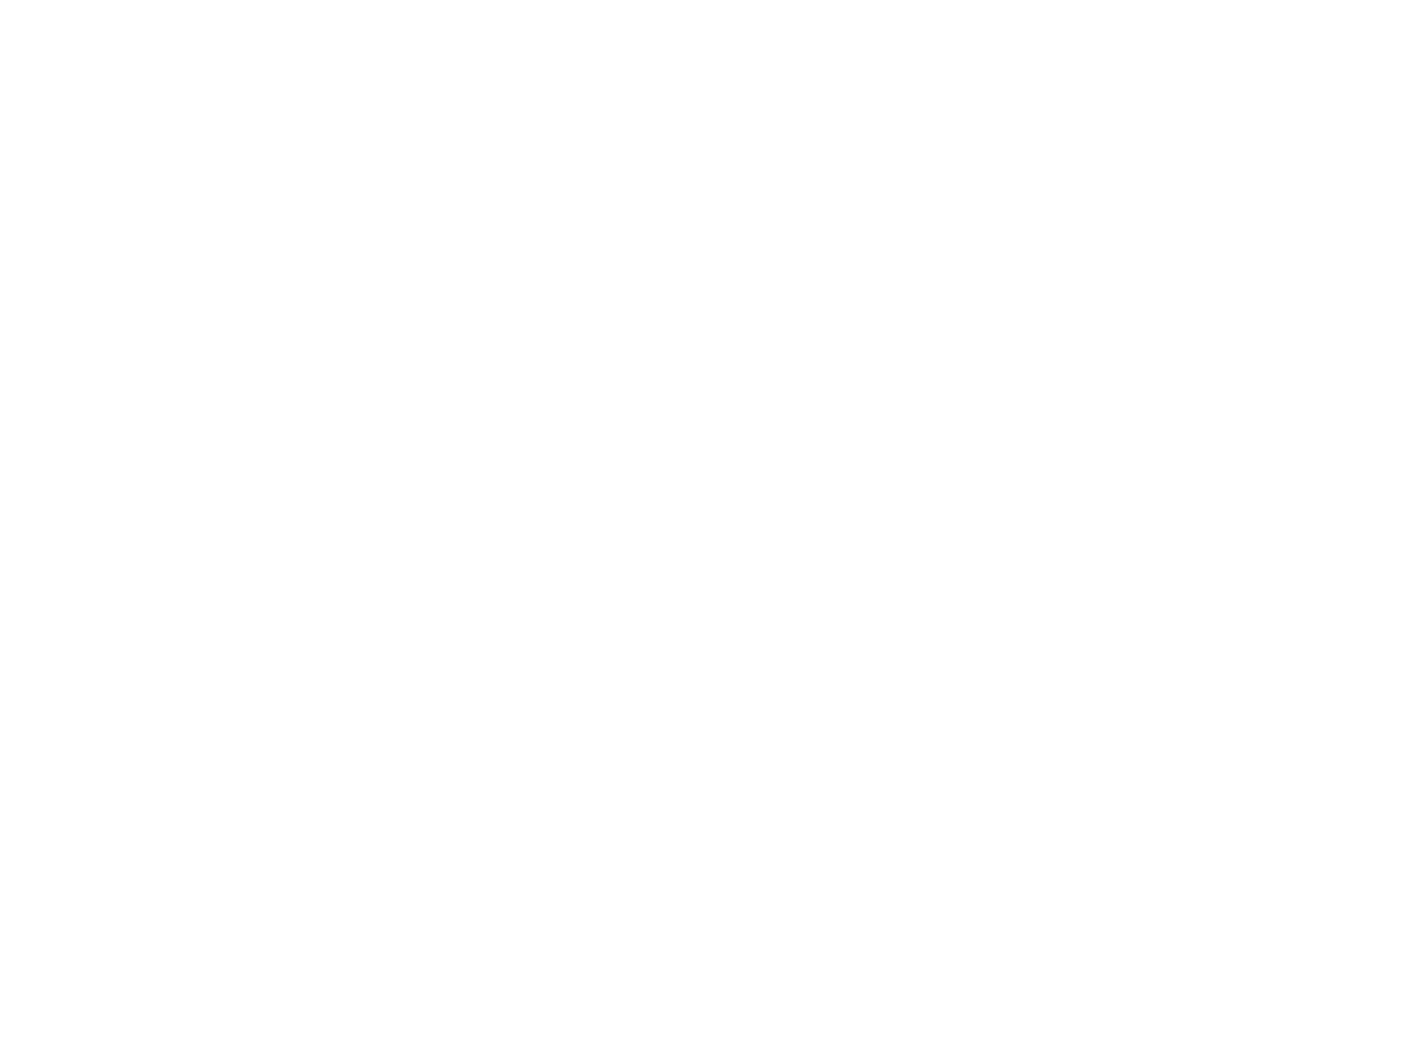

<IPython.core.display.Javascript object>


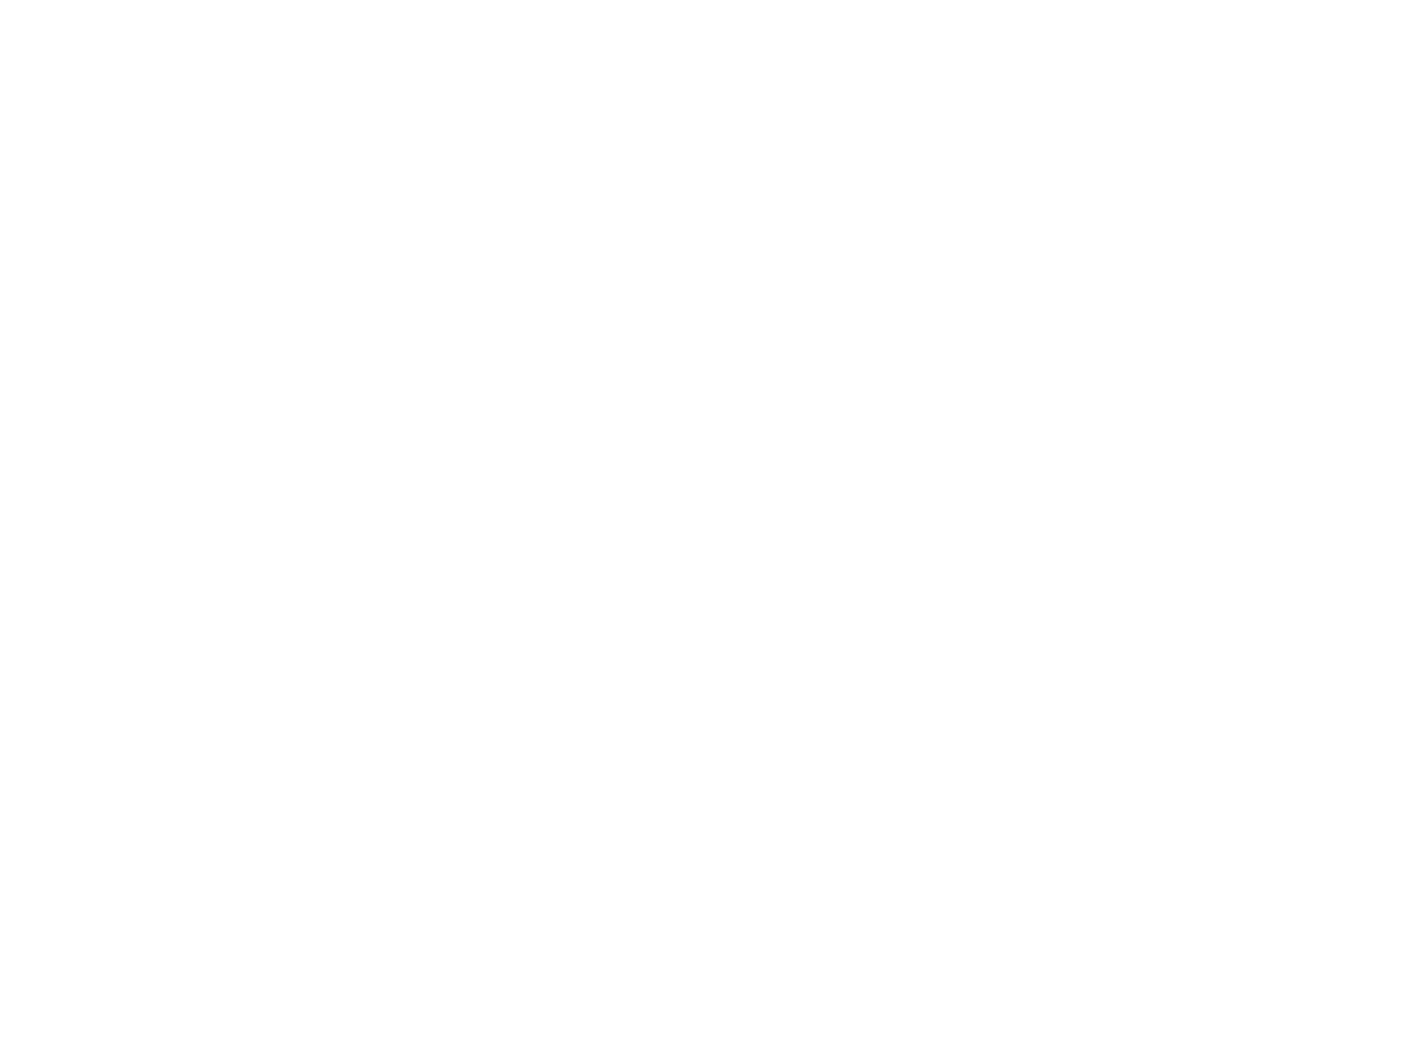

<IPython.core.display.Javascript object>


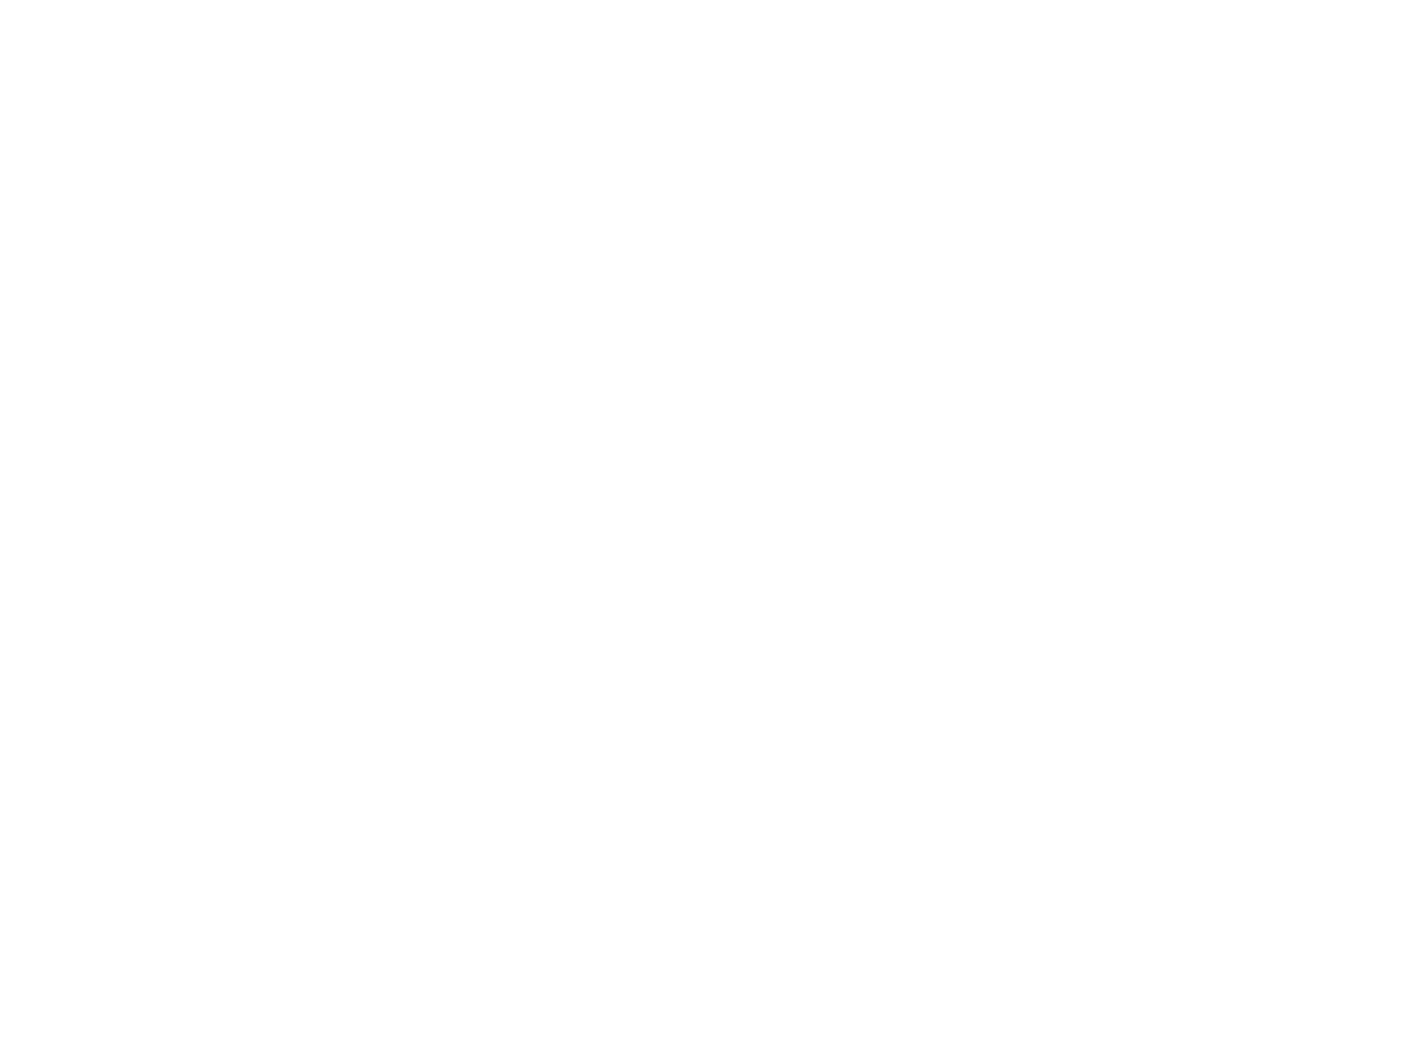

In [60]:
#plotting histograms of mean signal intensity per ROI
tc_mean_full = np.zeros(nonzerovar_mask.shape)
tc_mean = timecourse.mean(-1)
tc_mean_full[nonzerovar_mask]=tc_mean
for roi in ["V1","V2","V3"]:#idx_rois:
    pl.figure()
    pl.title(roi)
    pl.hist(tc_mean_full[idx_rois[roi]],bins=100)
    pl.show()   
    pl.close()


<IPython.core.display.Javascript object>


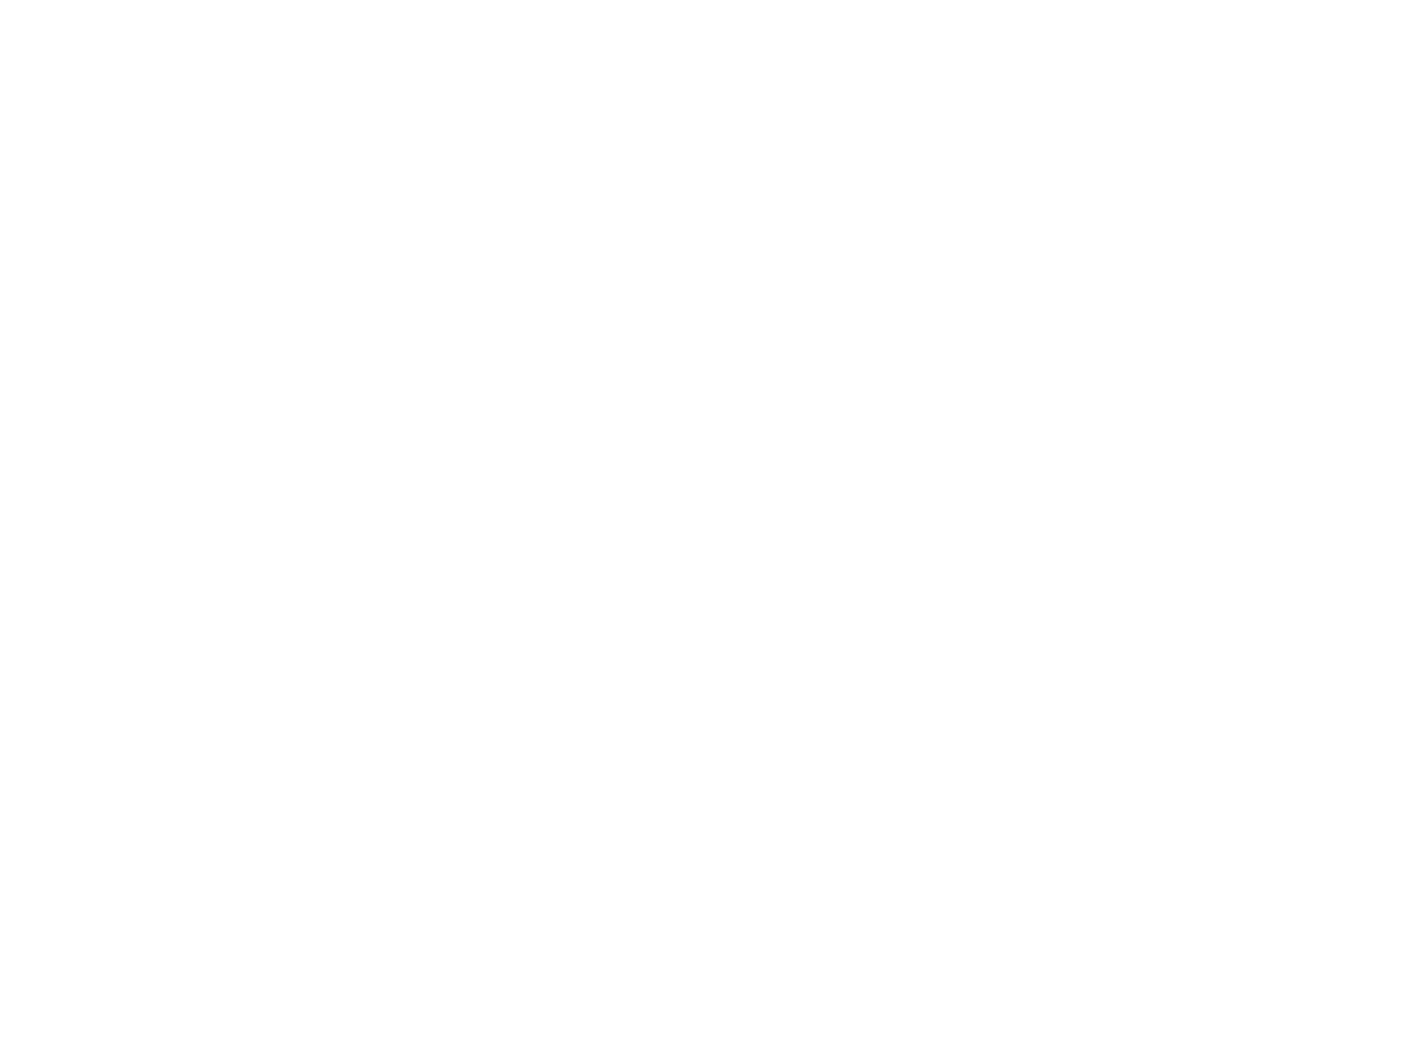

<IPython.core.display.Javascript object>


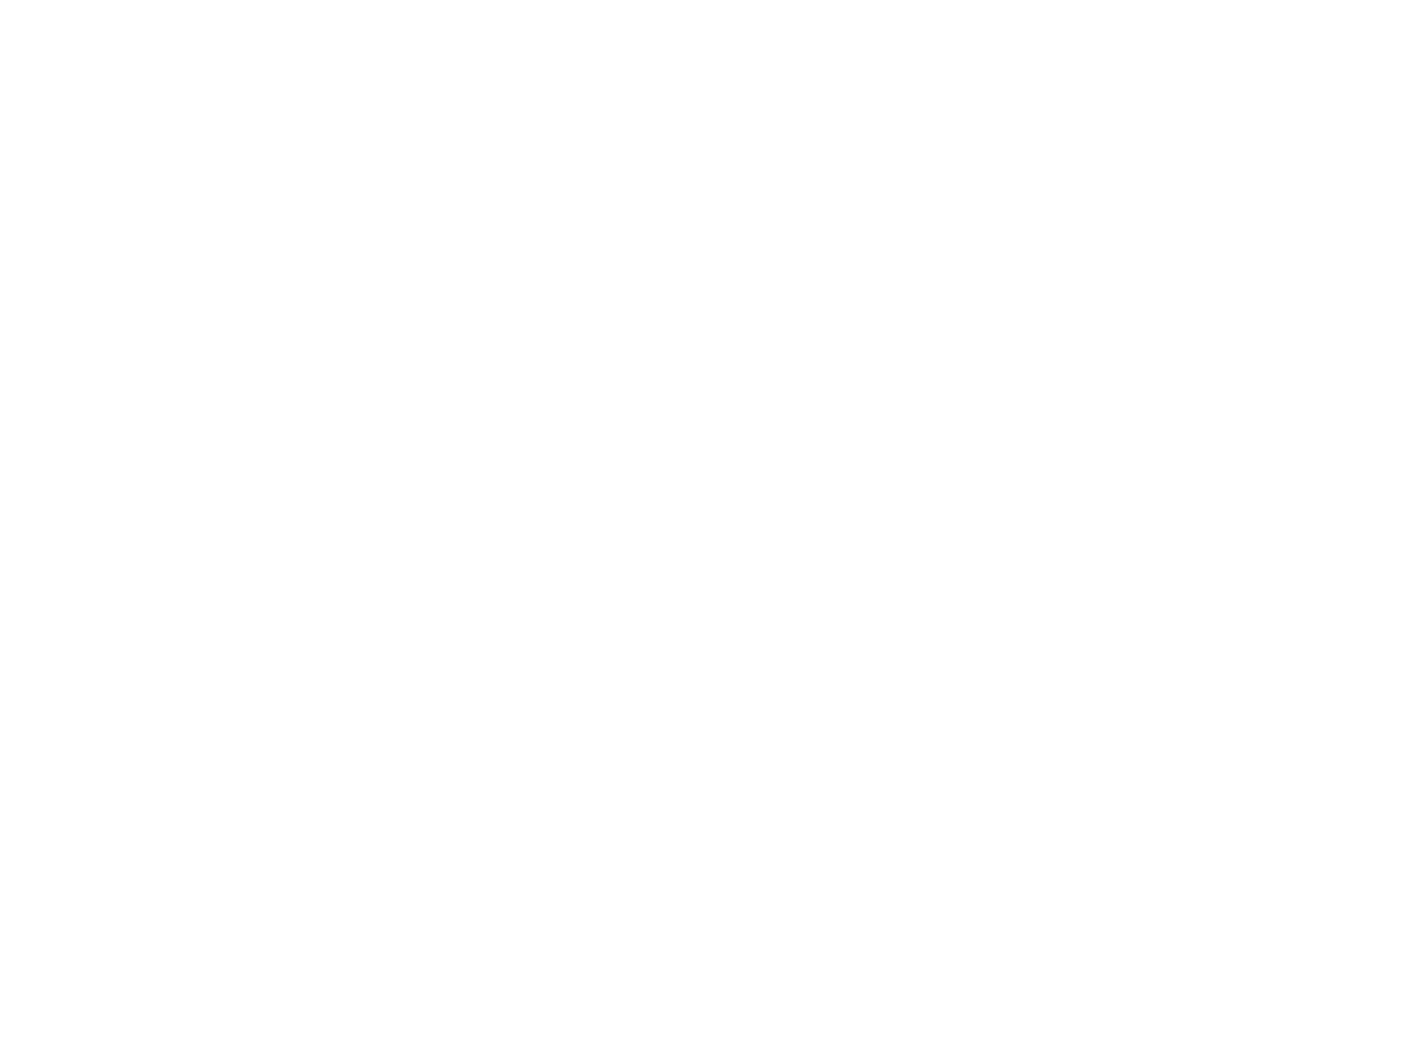

<IPython.core.display.Javascript object>


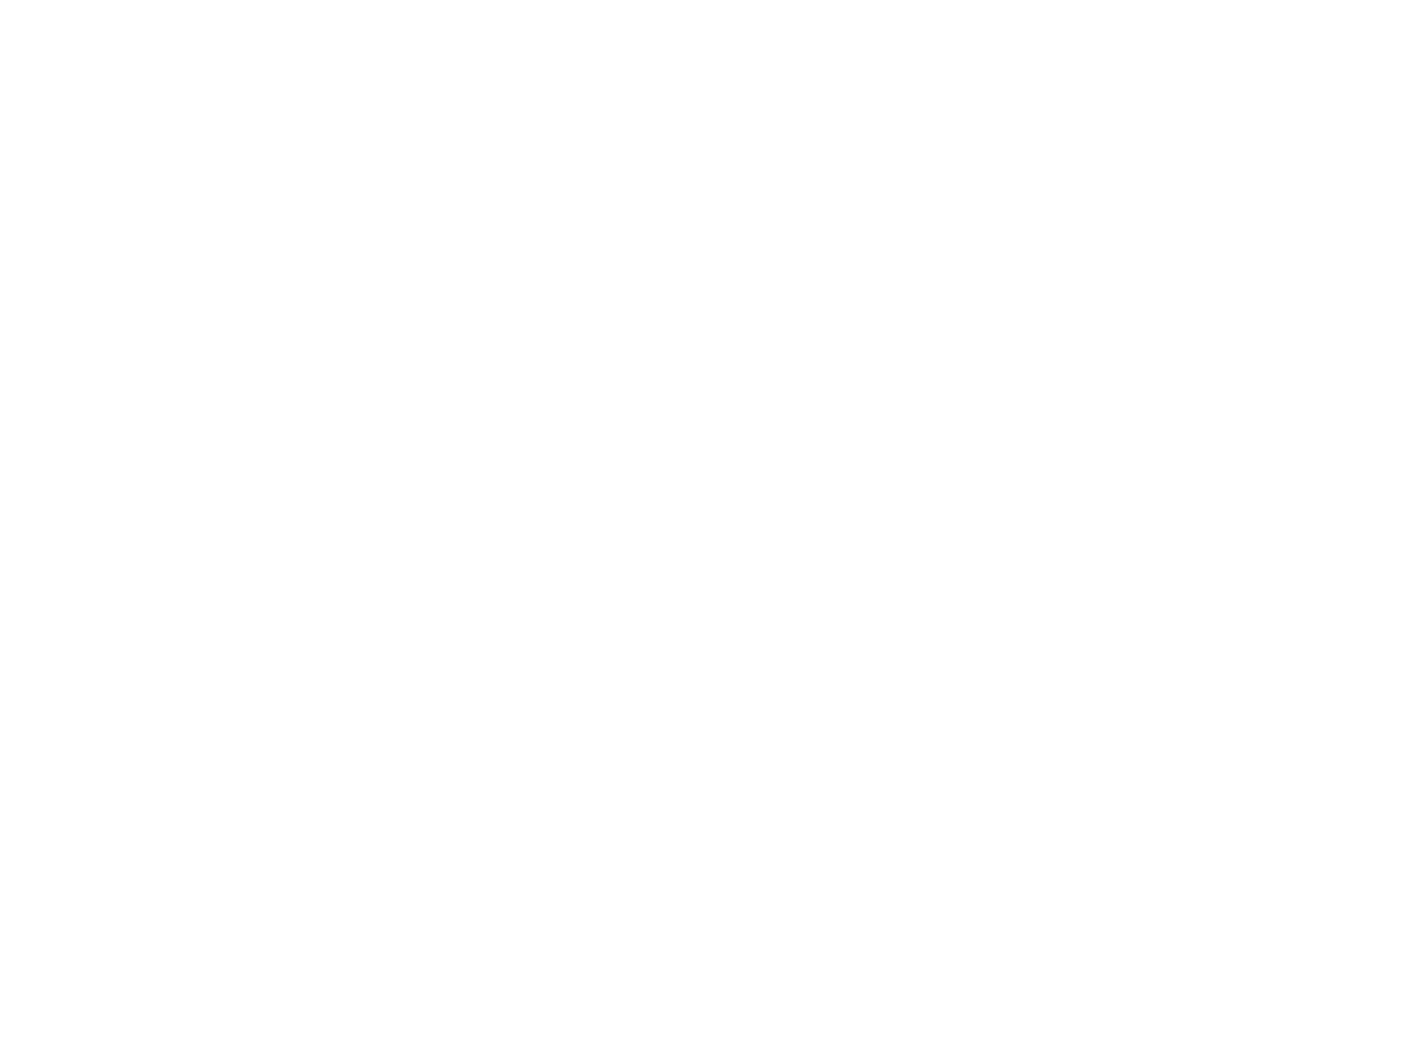

In [248]:
#plotting histograms of variance per ROI
tc_var_full = np.zeros(nonzerovar_mask.shape)
tc_var = timecourse.var(-1)
tc_var_full[nonzerovar_mask]= tc_var
for roi in ["V1","V2","V3"]:
    pl.figure()
    pl.title(roi)
    pl.hist(tc_var_full[idx_rois[roi]],bins=100)
    pl.show()
    pl.close()

<IPython.core.display.Javascript object>


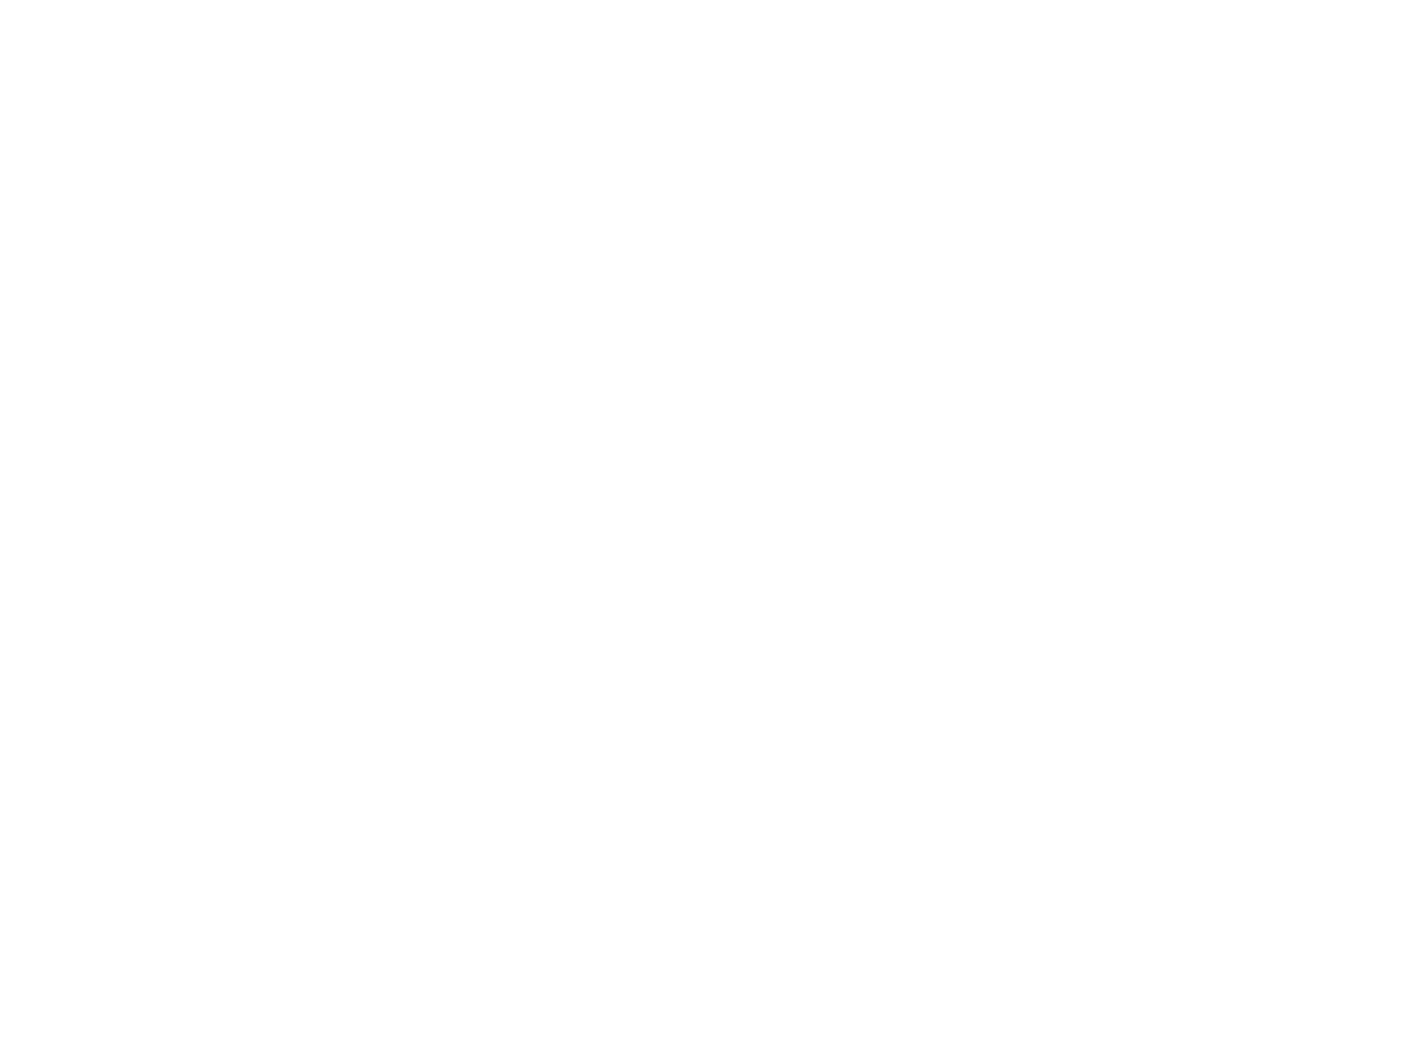

<IPython.core.display.Javascript object>


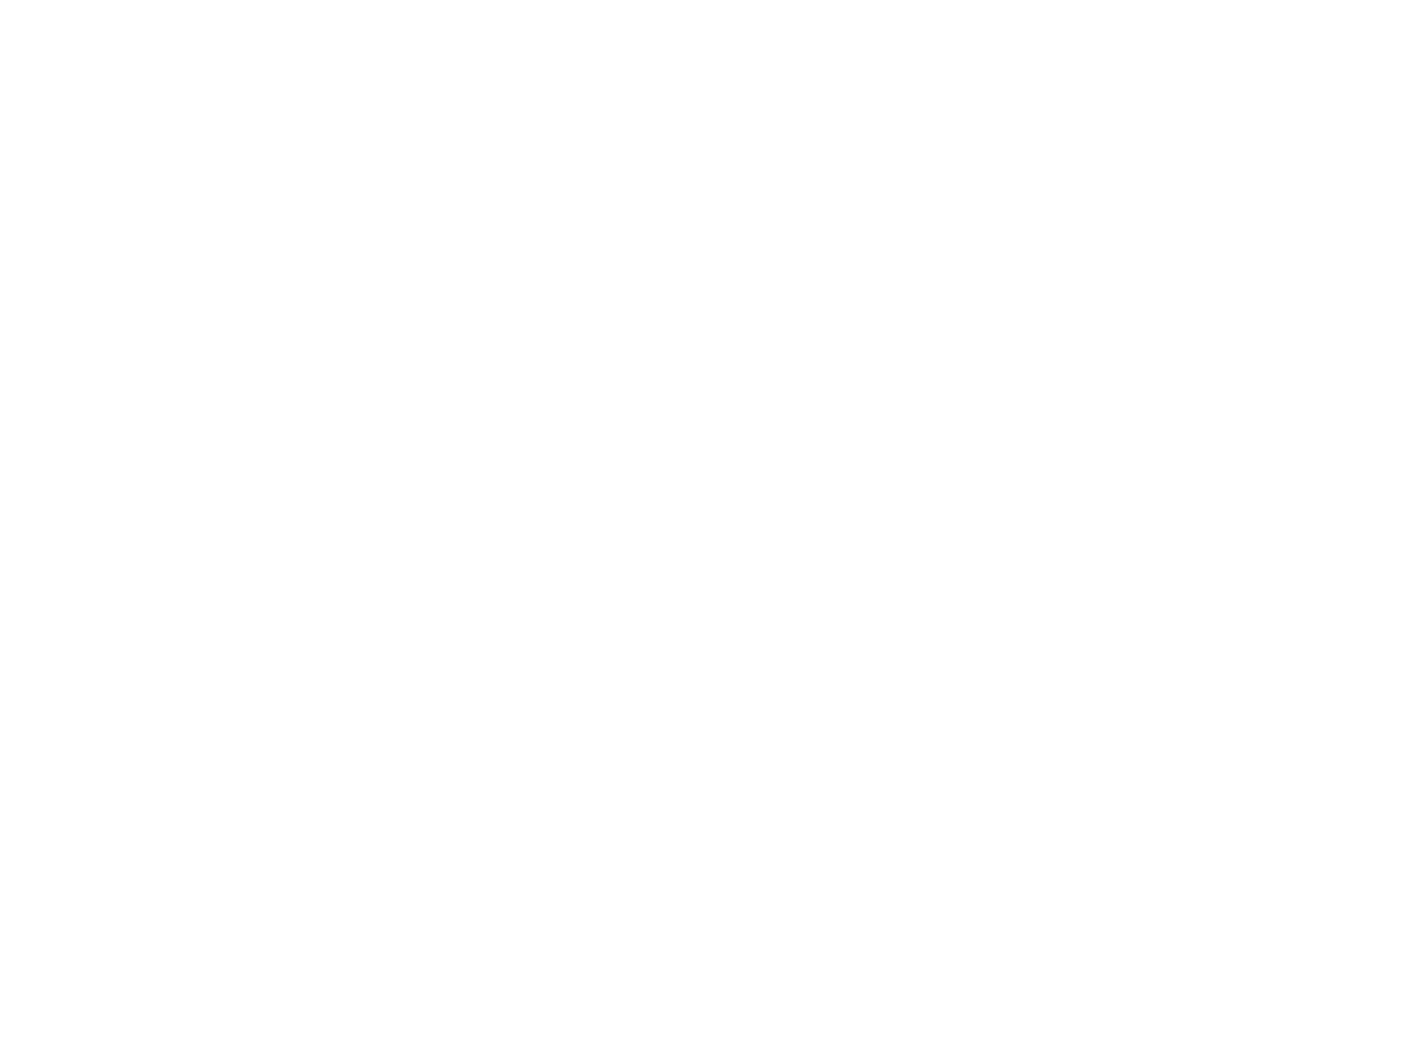

<IPython.core.display.Javascript object>


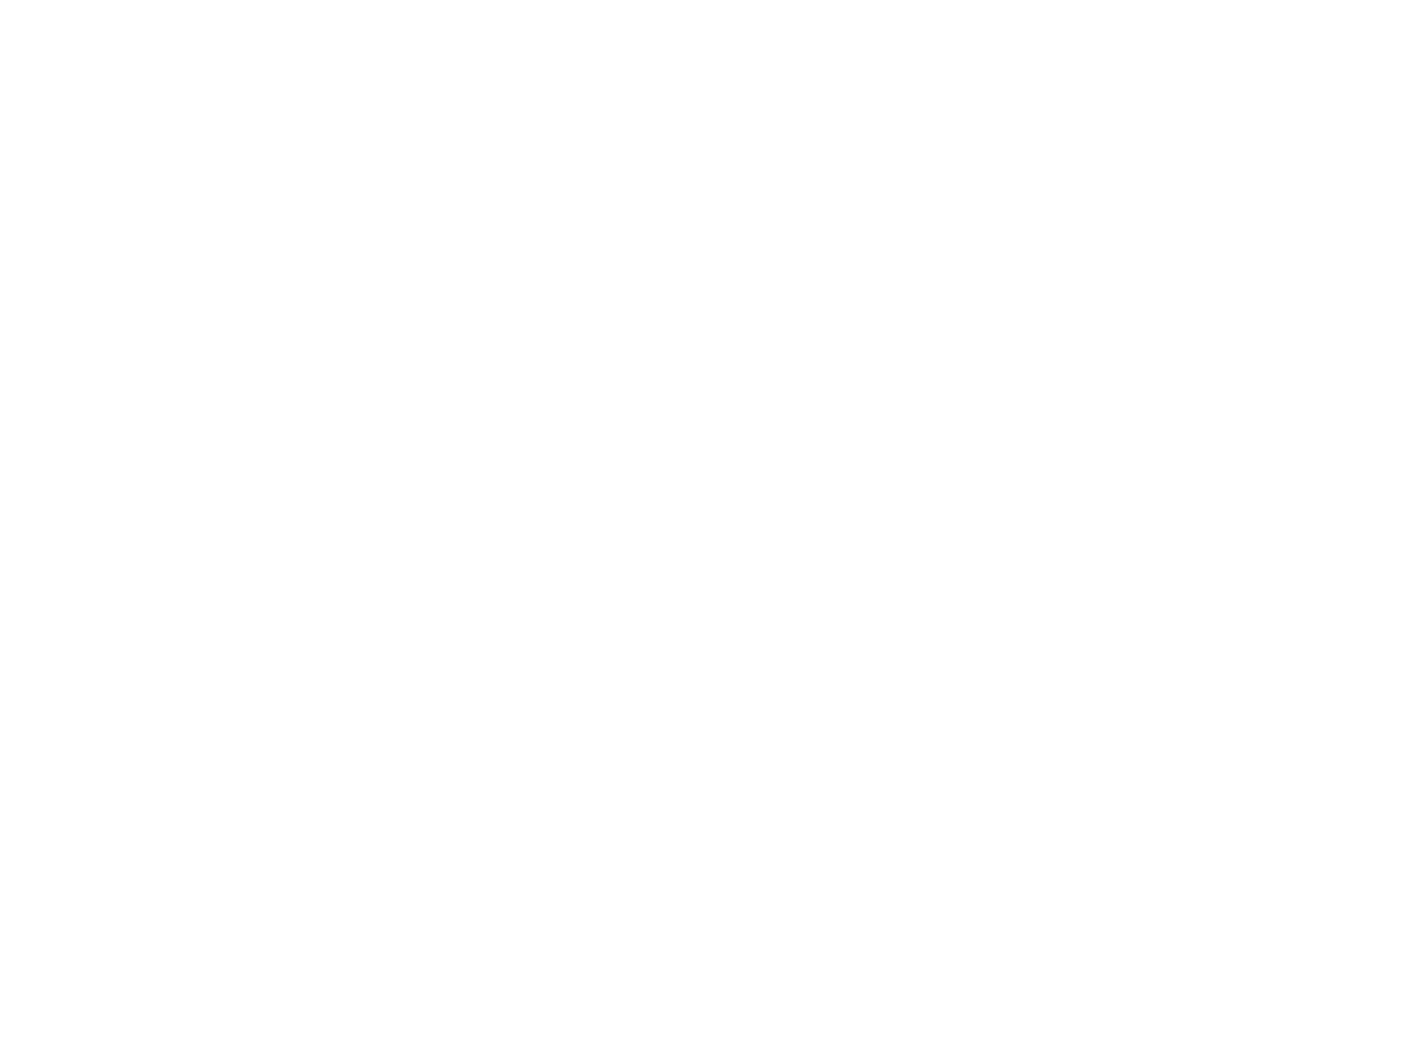

In [249]:
#plotting histograms of tSNR per ROI
tsnr_full = np.zeros(nonzerovar_mask.shape)
tsnr = tc_mean/np.sqrt(tc_var)
tsnr_full[nonzerovar_mask]=tsnr
for roi in ["V1","V2","V3"]:
    pl.figure()
    pl.title(roi)
    pl.hist(tsnr_full[idx_rois[roi]],bins=100)
    pl.show()
    pl.close()

In [252]:
#data quality/stats cortex visualization
pl.close('all')
mean_ts_vert = cortex.Vertex2D(tc_mean_full, nonzerovar_mask*(tc_mean_full>35000), subject=subj, cmap='Jet_2D_alpha')
var_ts_vert = cortex.Vertex2D(tc_var_full, nonzerovar_mask, subject=subj, cmap='Jet_2D_alpha')
tsnr_vert = cortex.Vertex2D(tsnr_full, nonzerovar_mask, subject=subj, cmap='Jet_2D_alpha')

data_stats ={'mean':mean_ts_vert.raw, 'var':var_ts_vert.raw, 'tsnr':tsnr_vert.raw}

cortex.webgl.show(data_stats,
                 with_curvature=False, 
                 with_labels=True, 
                 with_rois=True,
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 8591


<JS: window.viewer>

Stopping server


In [110]:
#(this is now included in preprocessing) correcting for low variance TCs (below 0.25% signal change) 
tc_mean = timecourse.mean(-1)
low_var = (timecourse - tc_mean[...,np.newaxis]).max(-1) < tc_mean*0.25/100

print("low var vertices: "+str(np.sum(low_var)))

gauss[low_var]=0
css_res[low_var]=0
dog_res[low_var]=0
norm_res[low_var]=0

low var vertices: 0


In [61]:
%%capture
#RSQ
rsq = np.zeros((nonzerovar_mask.shape[0],4))
rsq[nonzerovar_mask,0] = gauss[:,-1]
rsq[nonzerovar_mask,1] = css_res[:, -1]
rsq[nonzerovar_mask,2] = dog_res[:, -1]
rsq[nonzerovar_mask,3] = norm_res[:, -1]

#prf ecc
ecc = np.zeros((nonzerovar_mask.shape[0],4))
ecc[nonzerovar_mask,0] = np.sqrt(gauss[:,0]**2+gauss[:,1]**2)
ecc[nonzerovar_mask,1] = np.sqrt(css_res[:,0]**2+css_res[:,1]**2)
ecc[nonzerovar_mask,2] = np.sqrt(dog_res[:,0]**2+dog_res[:,1]**2)
ecc[nonzerovar_mask,3] = np.sqrt(norm_res[:,0]**2+norm_res[:,1]**2)

#prf polar angle
polar = np.zeros((nonzerovar_mask.shape[0],4))
polar[nonzerovar_mask,0] = np.arctan2(-gauss[:,0], gauss[:,1])
polar[nonzerovar_mask,1] = np.arctan2(-css_res[:,0], css_res[:,1])
polar[nonzerovar_mask,2] = np.arctan2(-dog_res[:,0], dog_res[:,1])
polar[nonzerovar_mask,3] = np.arctan2(-norm_res[:,0], norm_res[:,1])

#prf size
size = np.zeros((nonzerovar_mask.shape[0],4))
size[nonzerovar_mask,0] = gauss[:,2]
size[nonzerovar_mask,1] = css_res[:,2]
size[nonzerovar_mask,2] = dog_res[:,2]
size[nonzerovar_mask,3] = norm_res[:,2]

#prf amplitude
amp = np.zeros((nonzerovar_mask.shape[0],4))
amp[nonzerovar_mask,0] = gauss[:,3]
amp[nonzerovar_mask,1] = css_res[:,3]
amp[nonzerovar_mask,2] = dog_res[:,3]
amp[nonzerovar_mask,3] = norm_res[:,3]

#BOLD baseline
bold_base = np.zeros((nonzerovar_mask.shape[0],4))
bold_base[nonzerovar_mask,0] = gauss[:,4]
bold_base[nonzerovar_mask,1] = css_res[:,4]
bold_base[nonzerovar_mask,2] = dog_res[:,4]
bold_base[nonzerovar_mask,3] = norm_res[:,4]

#css exponent
css_exp = np.zeros(nonzerovar_mask.shape[0])
css_exp[nonzerovar_mask] = css_res[:,5]

#surround amplitude
surr_amp = np.zeros((nonzerovar_mask.shape[0],2))
surr_amp[nonzerovar_mask,0] = dog_res[:,5]
surr_amp[nonzerovar_mask,1] = norm_res[:,5]

#surround size
surr_size = np.zeros((nonzerovar_mask.shape[0],2))
surr_size[nonzerovar_mask,0] = dog_res[:,6]
surr_size[nonzerovar_mask,1] = norm_res[:,6]

#fwhmax fwatmin
fw_hmax = np.zeros((nonzerovar_mask.shape[0],4))
fw_atmin = np.zeros((nonzerovar_mask.shape[0],2))
norm_profiles = np.zeros((1000, nonzerovar_mask.shape[0]))
fw_hmax[nonzerovar_mask,0] = fwhmax_fwatmin('Gauss', gauss, normalize_RFs)
fw_hmax[nonzerovar_mask,1] = fwhmax_fwatmin('CSS', css_res, normalize_RFs)
fw_hmax[nonzerovar_mask,2], fw_atmin[nonzerovar_mask,0] = fwhmax_fwatmin('DoG', dog_res, normalize_RFs)
(fw_hmax[nonzerovar_mask,3], fw_atmin[nonzerovar_mask,1]), norm_profiles[:,nonzerovar_mask] = fwhmax_fwatmin('Norm', norm_res, normalize_RFs,
                                                                                      return_profiles=True)

#normalization model baselines (neural and surround, ratio, (a+b/(c+d), ad-bc))
baselines = np.zeros((nonzerovar_mask.shape[0],5))
baselines[nonzerovar_mask,0] = norm_res[:,7]
baselines[nonzerovar_mask,1] = norm_res[:,8]
baselines[nonzerovar_mask,2] = norm_res[:,7]/norm_res[:,8]
baselines[nonzerovar_mask,3] = (norm_res[:,3]+norm_res[:,7])/(norm_res[:,5]+norm_res[:,8])
baselines[nonzerovar_mask,4] = (norm_res[:,3]*norm_res[:,8])-(norm_res[:,5]*norm_res[:,7])

In [81]:
norm_params_full = np.zeros((nonzerovar_mask.shape[0],10))
norm_params_full[nonzerovar_mask,:] = np.copy(norm_res)

In [92]:
#min time series threshold for each subject determined by inspecting mean tc map
if subj == 'sub-006':
    tc_min = 45000
elif subj == 'sub-007':
    tc_min = 35000
elif subj == 'sub-001':
    tc_min = 35000

ecc_min=0.25
ecc_max=4

w_max = 90

alpha = rsq.max(-1) * (ecc.max(-1)<ecc_max) * (ecc.min(-1)>ecc_min) * (amp.min(-1)>0) * (tc_mean_full>tc_min) 

alpha_gauss = rsq[:,0] * (ecc[:,0]<ecc_max) * (ecc[:,0]>ecc_min) * (amp[:,0]>0) * (tc_mean_full>tc_min) * (fw_hmax[:,0]<w_max) 
alpha_css = rsq[:,1] * (ecc[:,1]<ecc_max) * (ecc[:,1]>ecc_min) * (amp[:,1]>0) * (tc_mean_full>tc_min) * (fw_hmax[:,1]<w_max) 
alpha_dog = rsq[:,2] * (ecc[:,2]<ecc_max) * (ecc[:,2]>ecc_min) * (amp[:,2]>0) * (tc_mean_full>tc_min) * (fw_hmax[:,2]<w_max) 
alpha_norm = rsq[:,3] * (ecc[:,3]<ecc_max) * (ecc[:,3]>ecc_min) * (amp[:,3]>0) * (tc_mean_full>tc_min) * (fw_hmax[:,3]<w_max)

alpha_dict = {'all':alpha,
             'Gauss':alpha_gauss,
             'CSS':alpha_css,
             'DoG':alpha_dog,
             'Norm':alpha_norm}


In [264]:
#output freesurefer-format polar angle maps to draw custom ROIs in freeview
lh_c = read_morph_data('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/'+subj+'/surf/lh.curv')

polar_freeview = np.median(polar, axis=-1)

alpha_freeview = rsq.max(-1) * (amp.min(-1)>0) * (tc_mean_full>tc_min) * (ecc.max(-1)<ecc_max)

polar_freeview[alpha_freeview<0.2] = -10

write_morph_data('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/'+subj+'/surf/lh.polar'
                                       ,polar_freeview[:lh_c.shape[0]])
write_morph_data('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer/'+subj+'/surf/rh.polar'
                                       ,polar_freeview[lh_c.shape[0]:])

Stopping server


In [299]:
#use e.g. roi_mask(V1,alpha) or roi_mask(idx_rois["FEF"],alpha) as dim2 to plot only for specific ROIs

rsq_diff_cssgauss = cortex.Vertex2D(rsq[:,1]-rsq[:,0], alpha, subject=subj,
                                              vmin=0, vmax=0.1, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

rsq_diff_doggauss = cortex.Vertex2D(rsq[:,2]-rsq[:,0], alpha, subject=subj,
                                          vmin=-0.02, vmax=0.02, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

rsq_diff_normgauss = cortex.Vertex2D(rsq[:,3]-rsq[:,0], alpha, subject=subj,
                                          vmin=0, vmax=0.1, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

rsq_diff_normdog = cortex.Vertex2D(rsq[:,3]-rsq[:,2], alpha, subject=subj,
                                          vmin=0, vmax=0.1, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

rsq_diff_normcss = cortex.Vertex2D(rsq[:,3]-rsq[:,1], alpha, subject=subj, 
                                          vmin=-0.02, vmax=0.02, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

#NOTE: MULTIPLE VERTEX2D IN ONE DATASET = BUGGY
ds_rsq = {'CSS - Gauss':rsq_diff_cssgauss.raw, 'DoG -  Gauss':rsq_diff_doggauss.raw, 'Norm - Gauss':rsq_diff_normgauss.raw,
    'Norm - DoG':rsq_diff_normdog.raw, 'Norm - CSS':rsq_diff_normcss.raw}

js_handle = cortex.webgl.show(ds_rsq,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True,
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 58424
Stopping server


In [241]:
base_str = 'test'

# different views available, more views can be added  and the
# existing list can be removed
#views = dict(lateral=dict(radius=250, altitude=90.5, azimuth=181, pivot=180),
#             medial=dict(radius=10, altitude=90.5, azimuth=0, pivot=180),
#             front=dict(radius=250, altitude=90.5, azimuth=0, pivot=0),
#             back=dict(radius=250, altitude=90.5, azimuth=181, pivot=0),
#             top=dict(radius=250, altitude=0, azimuth=180, pivot=0),
#             bottom=dict(radius=250, altitude=180, azimuth=0, pivot=0)
#            )

views = dict(dorsal=dict(radius=191, altitude=73, azimuth=178, pivot=0),
             medial=dict(radius=10, altitude=101, azimuth=359, pivot=167),
             lateral=dict(radius=277, altitude=90, azimuth=177, pivot=123),
             ventral=dict(radius=221, altitude=131, azimuth=175, pivot=0)
            )

surfaces = dict(inflated=dict(unfold=0.5))#,
               # fiducial=dict(unfold=0.0))

# select path for the generated images on disk
image_path = '/Users/marcoaqil/PRFMapping/Figures/'

# pattern of the saved images names
file_pattern = "{base}_{view}_{surface}.png"

# utility functions to set the different views
prefix = dict(altitude='camera.', azimuth='camera.',
              pivot='surface.{subject}.', radius='camera.', target='camera.',
              unfold='surface.{subject}.')
_tolists = lambda p: {prefix[k]+k:[v] for k,v in p.items()}
_combine = lambda a,b: ( lambda c: [c, c.update(b)][0] )(dict(a))


# Save images by iterating over the different views and surfaces
for view,vparams in views.items():
    for surf,sparams in surfaces.items():
        # Combine basic, view, and surface parameters
        params = _combine(vparams, sparams)
        # Set the view
        print(params)
        time.sleep(5)
        js_handle._set_view(**_tolists(params))
        time.sleep(5)
        # Save image
        filename = file_pattern.format(base=base_str, view=view, surface=surf)
        output_path = os.path.join(image_path, filename)
        js_handle.getImage(output_path, size =(3000, 2000))

        # the block below trims the edges of the image:
        # wait for image to be written
        while not os.path.exists(output_path):
            pass
        time.sleep(0.5)
        try:
            import subprocess
            subprocess.call(["convert", "-trim", output_path, output_path])
        except:
            pass

# Close the window!
#js_handle.close() 

{'radius': 191, 'altitude': 73, 'azimuth': 178, 'pivot': 0, 'unfold': 0.5}
{'radius': 10, 'altitude': 101, 'azimuth': 359, 'pivot': 167, 'unfold': 0.5}
{'radius': 277, 'altitude': 90, 'azimuth': 177, 'pivot': 123, 'unfold': 0.5}
{'radius': 221, 'altitude': 131, 'azimuth': 175, 'pivot': 0, 'unfold': 0.5}
Stopping server


In [263]:
#plot ecc on cortex
ecc_gauss = cortex.Vertex2D(ecc[:,0], alpha, subject=subj, vmin=0.25, vmax=4.5, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
ecc_css = cortex.Vertex2D(ecc[:,1], alpha, subject=subj, vmin=0.25, vmax=4.5, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
ecc_dog = cortex.Vertex2D(ecc[:,2], alpha, subject=subj, vmin=0.25, vmax=4.5, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
ecc_norm = cortex.Vertex2D(ecc[:,3], alpha, subject=subj, vmin=0.25, vmax=4.5, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_ecc = {'Ecc Gauss':ecc_gauss.raw, 'Ecc CSS':ecc_css.raw, 'Ecc DoG':ecc_dog.raw, 'Ecc Norm':ecc_norm.raw}

cortex.webgl.show(ds_ecc,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 46730


<JS: window.viewer>

In [278]:
#plot polar angle on cortex
#alpha_roi = roi_mask(idx_rois['custom.V2'],alpha)

polar_gauss = cortex.Vertex2D(polar[:,0], alpha, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')
polar_css = cortex.Vertex2D(polar[:,1], alpha, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')
polar_dog = cortex.Vertex2D(polar[:,2], alpha, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')
polar_norm = cortex.Vertex2D(polar[:,3], alpha, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')



ds_polar = {'polar Gauss':polar_gauss.raw, 'polar CSS':polar_css.raw, 'polar DoG':polar_dog.raw, 'polar Norm':polar_norm.raw}

cortex.webgl.show(ds_polar,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 48874


<JS: window.viewer>

Stopping server


In [89]:
#plot fw_hmax on cortex
fw_hmax_gauss = cortex.Vertex2D(fw_hmax[:,0], alpha, subject=subj, vmin=0, vmax=6, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
fw_hmax_css = cortex.Vertex2D(fw_hmax[:,1], alpha, subject=subj, vmin=0, vmax=6, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
fw_hmax_dog = cortex.Vertex2D(fw_hmax[:,2], alpha, subject=subj, vmin=0, vmax=6, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
fw_hmax_norm = cortex.Vertex2D(fw_hmax[:,3], alpha, subject=subj, vmin=0, vmax=6, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_fw_hmax = {'fw_hmax Gauss':fw_hmax_gauss.raw, 'fw_hmax CSS':fw_hmax_css.raw, 'fw_hmax DoG':fw_hmax_dog.raw, 'fw_hmax Norm':fw_hmax_norm.raw}

cortex.webgl.show(ds_fw_hmax,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 45724


<JS: window.viewer>

Stopping server


In [147]:
#plot amp on cortex
amp_gauss = cortex.Vertex2D(amp[:,0], alpha, subject=subj, vmin=-1, vmax=1, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
amp_css = cortex.Vertex2D(amp[:,1], alpha, subject=subj, vmin=-1, vmax=1, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
amp_dog = cortex.Vertex2D(amp[:,2], alpha, subject=subj, vmin=-1, vmax=1, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
amp_norm = cortex.Vertex2D(amp[:,3], alpha, subject=subj, vmin=0, vmax=10, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_amp = {'amp Gauss':amp_gauss.raw, 
          'amp CSS':amp_css.raw, 
          'amp DoG':amp_dog.raw, 
          'amp Norm':amp_norm.raw}

cortex.webgl.show(ds_amp,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 2874


<JS: window.viewer>

Stopping server
Stopping server


In [857]:
#CSS exponent
ds_css_exp = {'CSS Exponent':cortex.Vertex2D(css_exp, alpha_css, subject=subj,
                                             vmin=0, vmax=0.75, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha').raw}
cortex.webgl.show(ds_css_exp,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)


Started server on port 63723


<JS: window.viewer>

Stopping server


In [90]:
#plot fw_atmin on cortex
fw_atmin_dog = cortex.Vertex2D(fw_atmin[:,0], alpha_dog, subject=subj,
                                vmax=50, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
fw_atmin_norm = cortex.Vertex2D(fw_atmin[:,1], alpha_norm, subject=subj,
                                  vmax=50, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_fw_atmin = {'fw_atmin DoG':fw_atmin_dog.raw, 'fw_atmin Norm':fw_atmin_norm.raw}

cortex.webgl.show(ds_fw_atmin,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 63434


<JS: window.viewer>

Stopping server


In [283]:
%%capture
#norm baselines non resc (-18 18 norm -8 8 surr -25 15 ratio, 3 9 abcd); resc: norm (-35 4), ratio -15,25, abcs -9, 2

#neural_baseline_resc = cortex.Vertex2D(np.log(baselines[:,0]/tc_mean_full), alpha_norm_norm, subject=subj,
#                                vmin=-35, vmax=4, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha_norm')

neural_baseline = cortex.Vertex2D(np.log(baselines[:,0]), alpha_norm, subject=subj,
                                vmin=-18, vmax=15, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

surr_baseline = cortex.Vertex2D(np.log(baselines[:,1]), alpha_norm, subject=subj,
                                 vmin=-8, vmax=8, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

ratio_baseline = cortex.Vertex2D(np.log(baselines[:,2]), alpha_norm, subject=subj,
                                 vmin=-25, vmax=15, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

abcd = cortex.Vertex2D(np.log(baselines[:,3]), alpha_norm, subject=subj,
                                 vmin=3, vmax=9, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

ad_bc = cortex.Vertex2D(np.log(baselines[:,4]), alpha_norm, subject=subj,
                                 vmin=-5, vmax=20, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

ds_baselines = {'Neural baseline':neural_baseline.raw,
                'Surround baseline':surr_baseline.raw,
               'Ratio (b/d)': ratio_baseline.raw, 'max norm amplitude (a+b)/(c+d)': abcd.raw,
               'Norm nonlinearity (ad-bc)':ad_bc.raw}


cortex.webgl.show(ds_baselines,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Stopping server


<IPython.core.display.Javascript object>


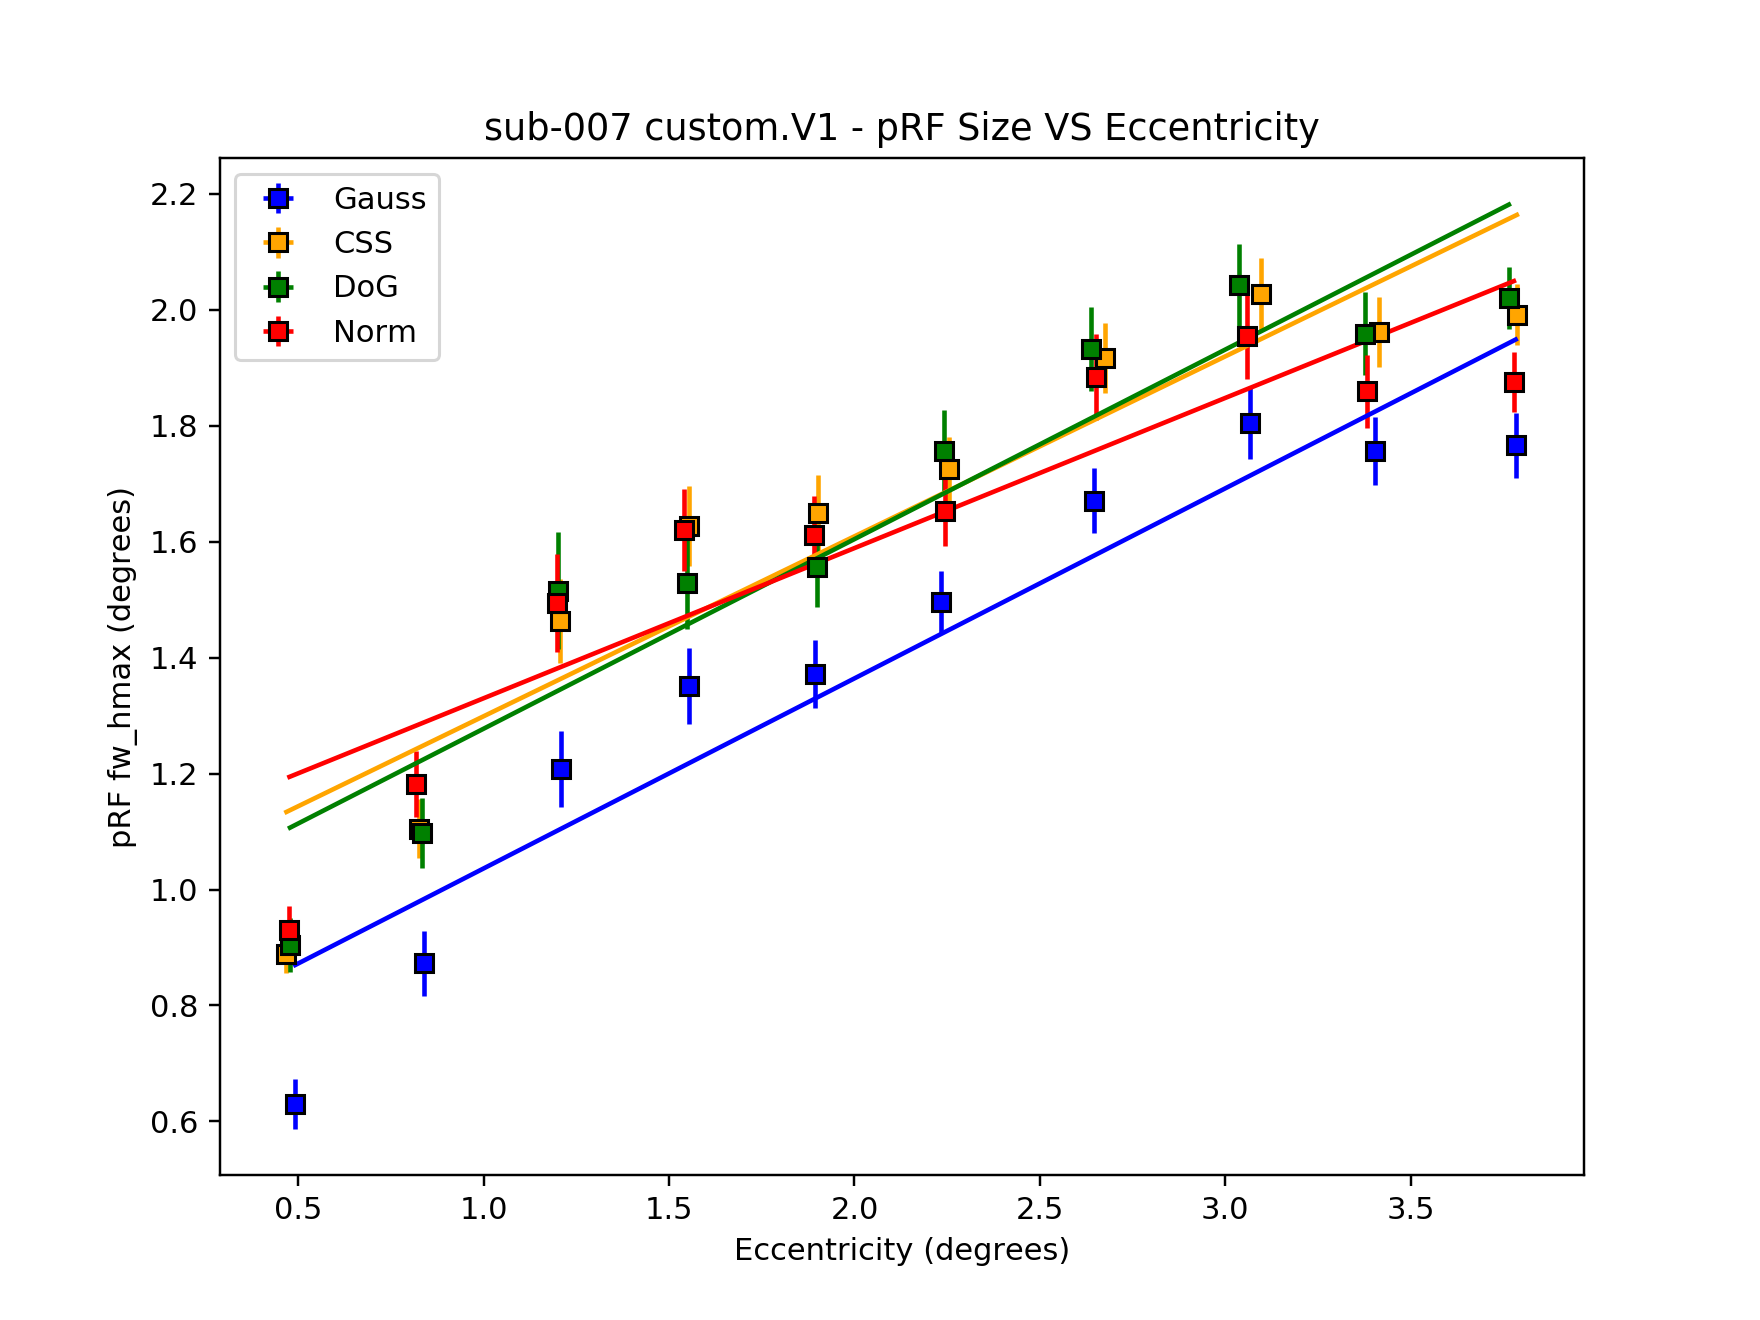

custom.V1 Gauss 0.32070955133817103
custom.V1 CSS 0.26632654711539194
custom.V1 DoG 0.23620224059103626
custom.V1 Norm 0.17043298794257244


<IPython.core.display.Javascript object>


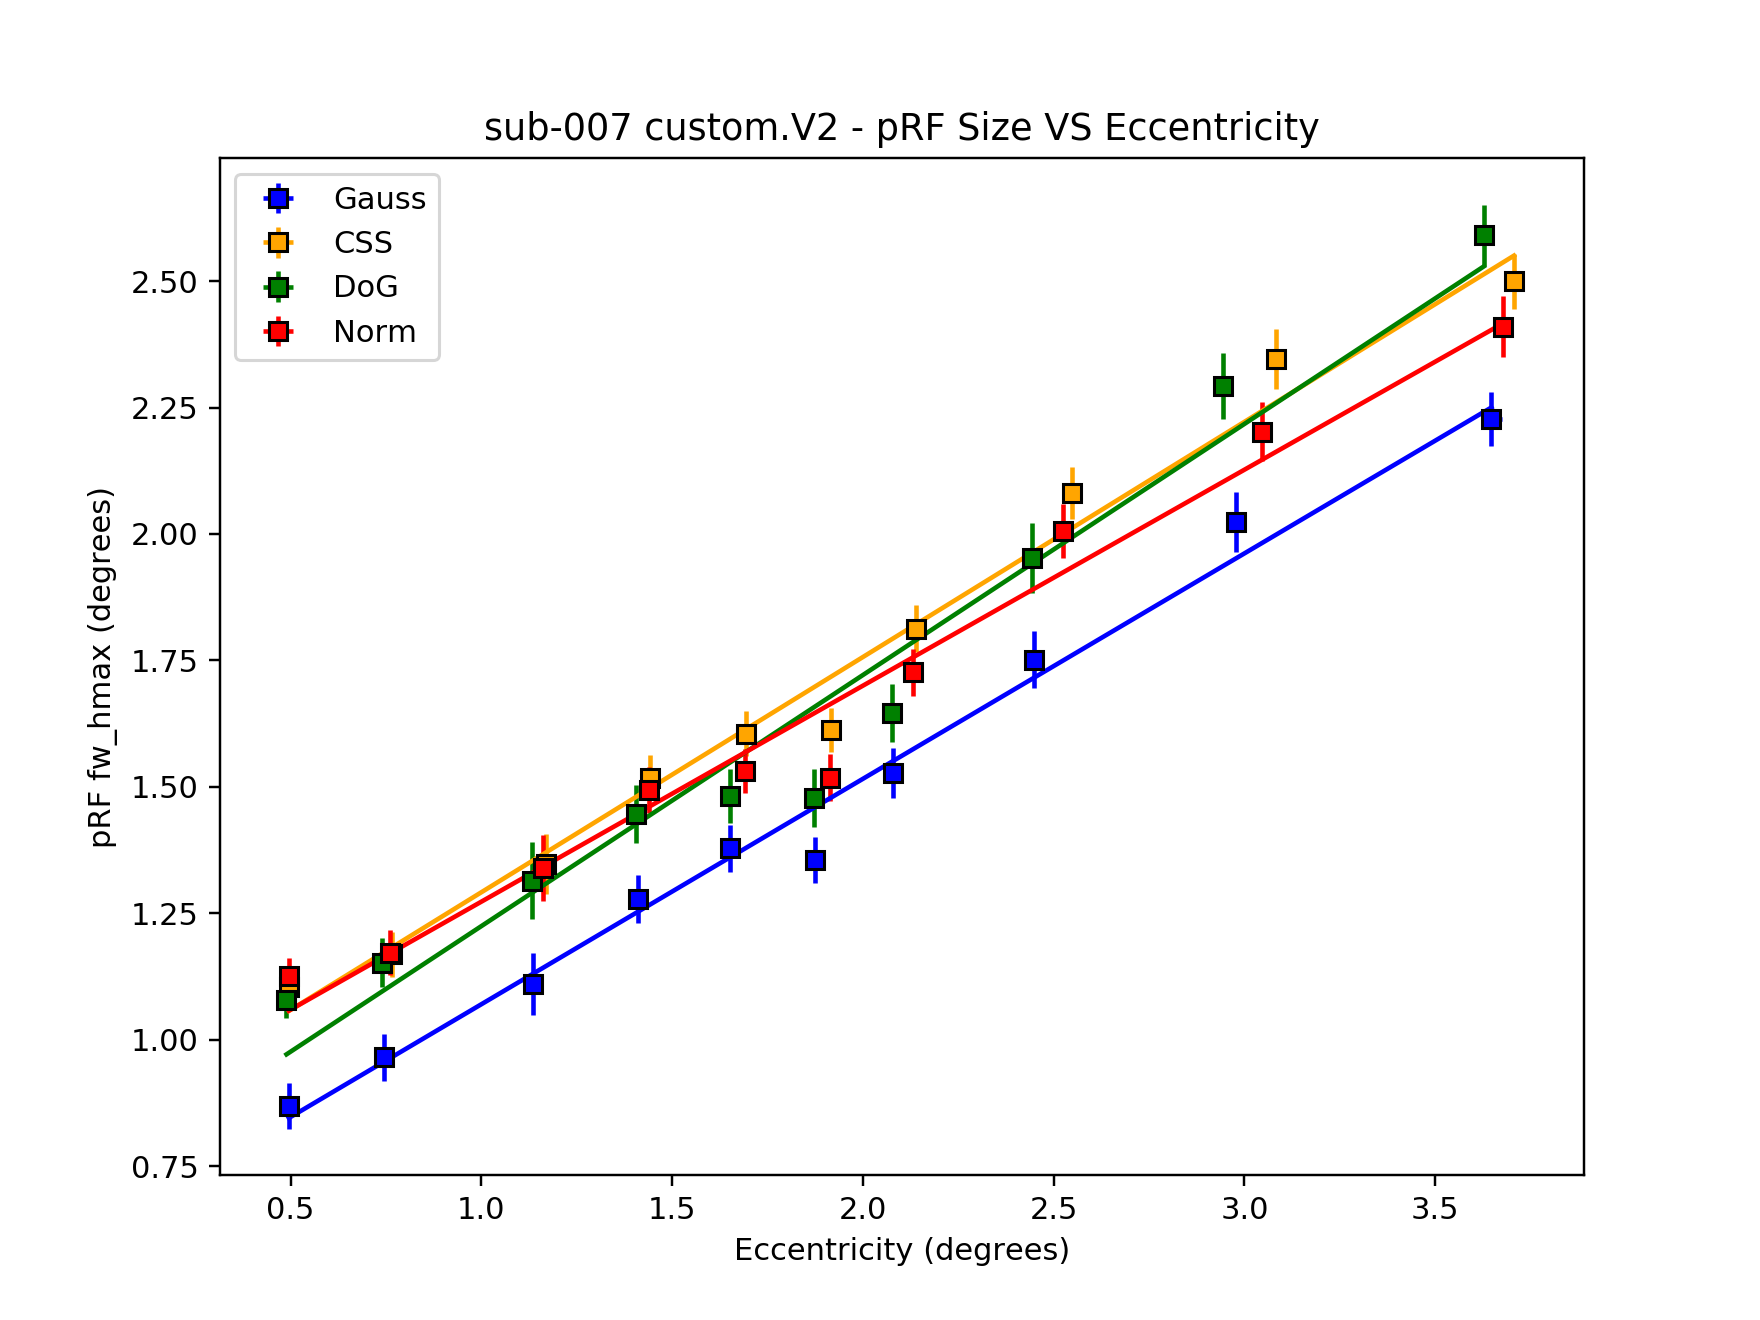

custom.V2 Gauss 0.5570719343920141
custom.V2 CSS 0.57971078679945
custom.V2 DoG 0.5270011573022525
custom.V2 Norm 0.5141921276995101


<IPython.core.display.Javascript object>


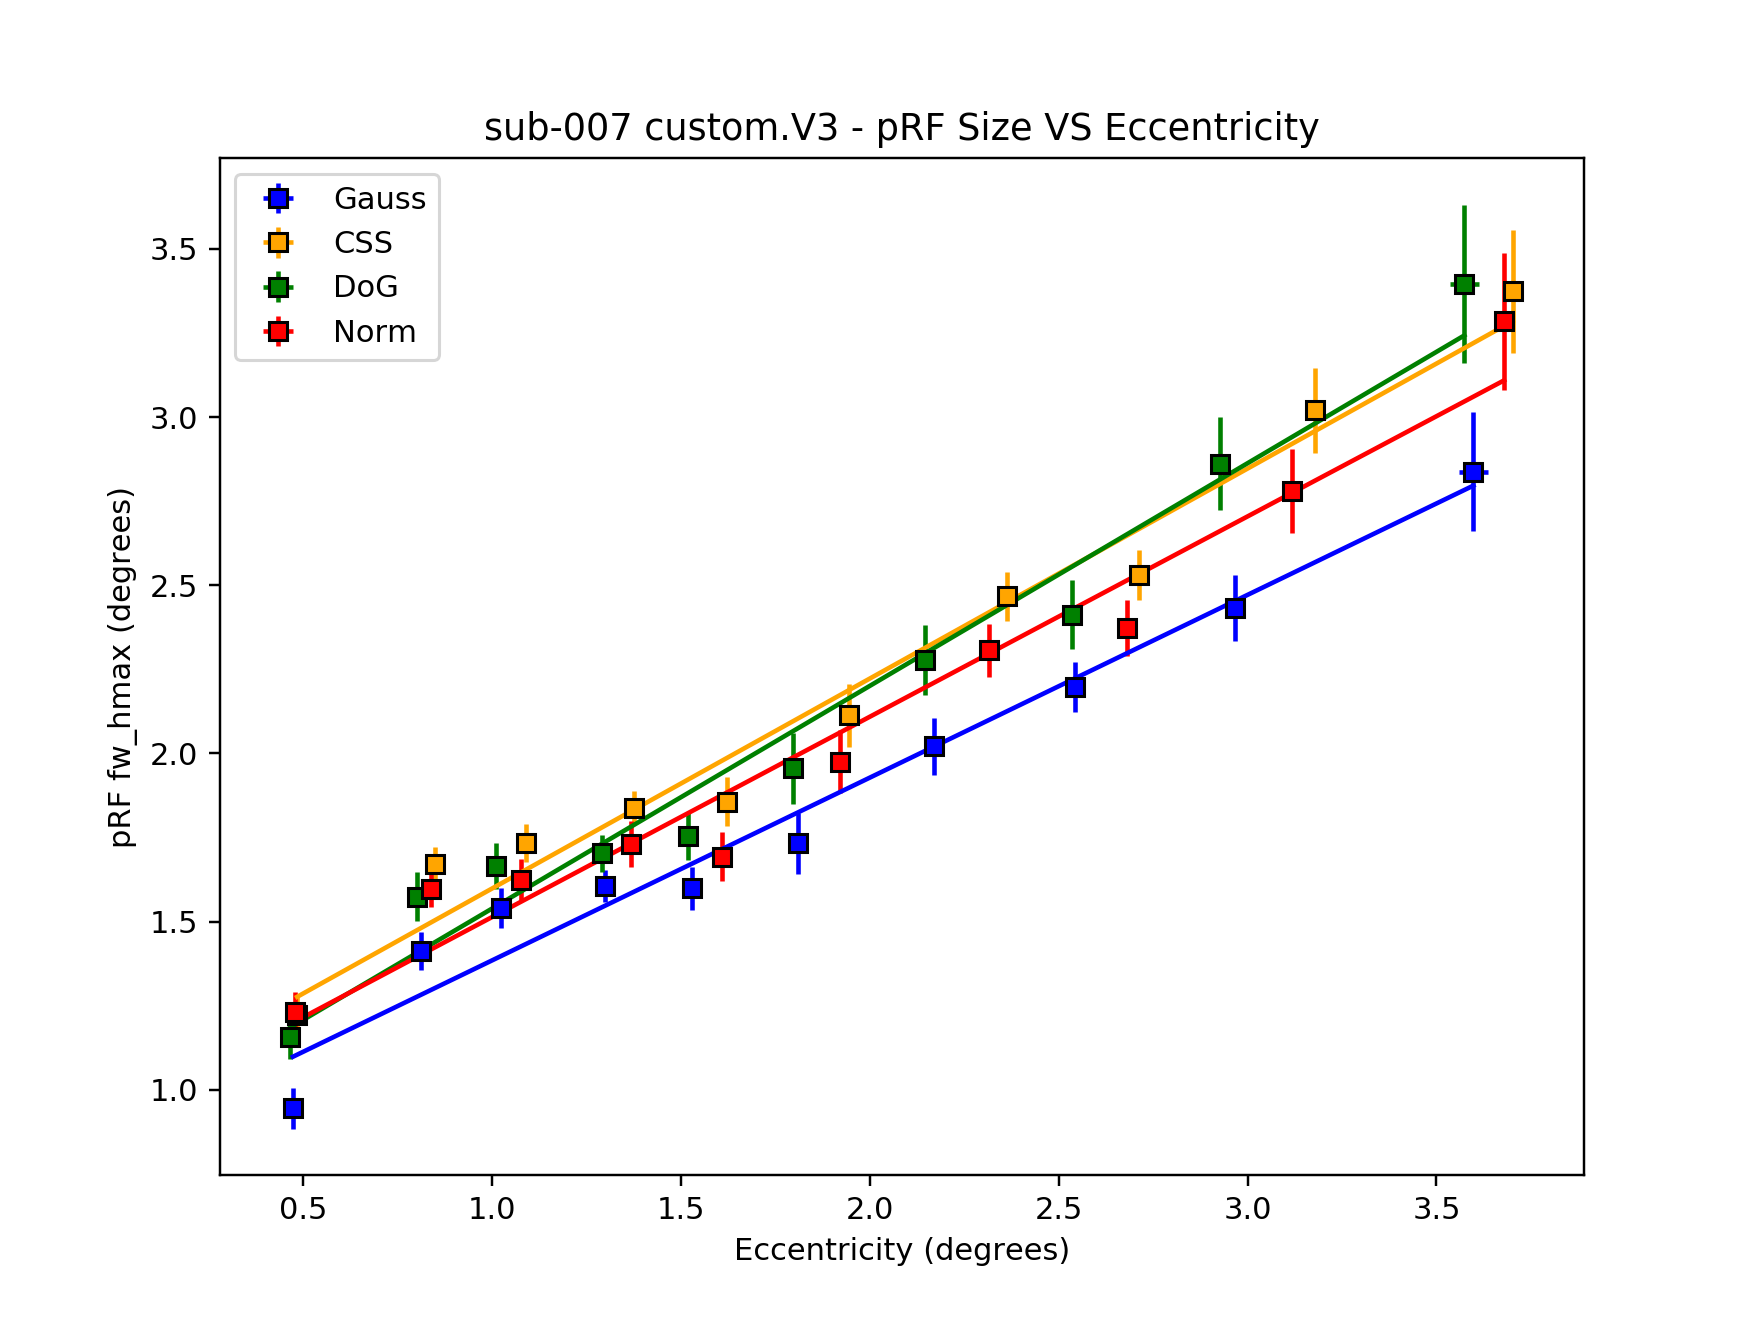

custom.V3 Gauss 0.4632266922631554
custom.V3 CSS 0.4903898881396465
custom.V3 DoG 0.4276835958515138
custom.V3 Norm 0.42825778322726943


In [97]:
# binned eccentricity vs other parameters relationships
rsq_thresh = 0.3

colors = ['blue','orange','green','red']

fw_hmax_stats = {}
ecc_stats = {}

for roi in ['custom.V1', 'custom.V2', 'custom.V3']:#idx_rois:
    
    pl.figure(roi+' fw_hmax', figsize=(8, 6))
    pl.title(subj+' '+roi+' - pRF Size VS Eccentricity')
    
    fw_hmax_stats[roi] = {}
    ecc_stats[roi] = {}
    
    #same alpha for all
    #alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    #ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
    #split_ecc_bins = np.array_split(ecc_sorted, 20, axis=0)    
    
    for i, model in enumerate(['Gauss','CSS','DoG','Norm']):
        fw_hmax_stats[roi][model]=[]
        ecc_stats[roi][model]=[]
        
        #model-specific alpha
        alpha_roi = (roi_mask(idx_rois[roi],alpha_dict[model])>rsq_thresh)    
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)
    
        for ecc_quantile in split_ecc_bins:
            fw_hmax_stats[roi][model].append(weightstats.DescrStatsW(fw_hmax[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

            ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))
            


        WLS = LinearRegression()
        WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])
        pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
                color=colors[i])
        
        print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])))
        
        plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
           [ss.mean for ss in fw_hmax_stats[roi][model]],
           yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_hmax_stats[roi][model]]).T,
           xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
           fmt='s', mfc=colors[i], mec='black', label=model, ecolor=colors[i])
        
        pl.xlabel('Eccentricity (degrees)')
        pl.ylabel('pRF fw_hmax (degrees)')
    pl.legend(loc=0)    
    #pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
    #               roi+'_fw-hmax.png', dpi=200, bbox_inches='tight')
    
    
    


<IPython.core.display.Javascript object>


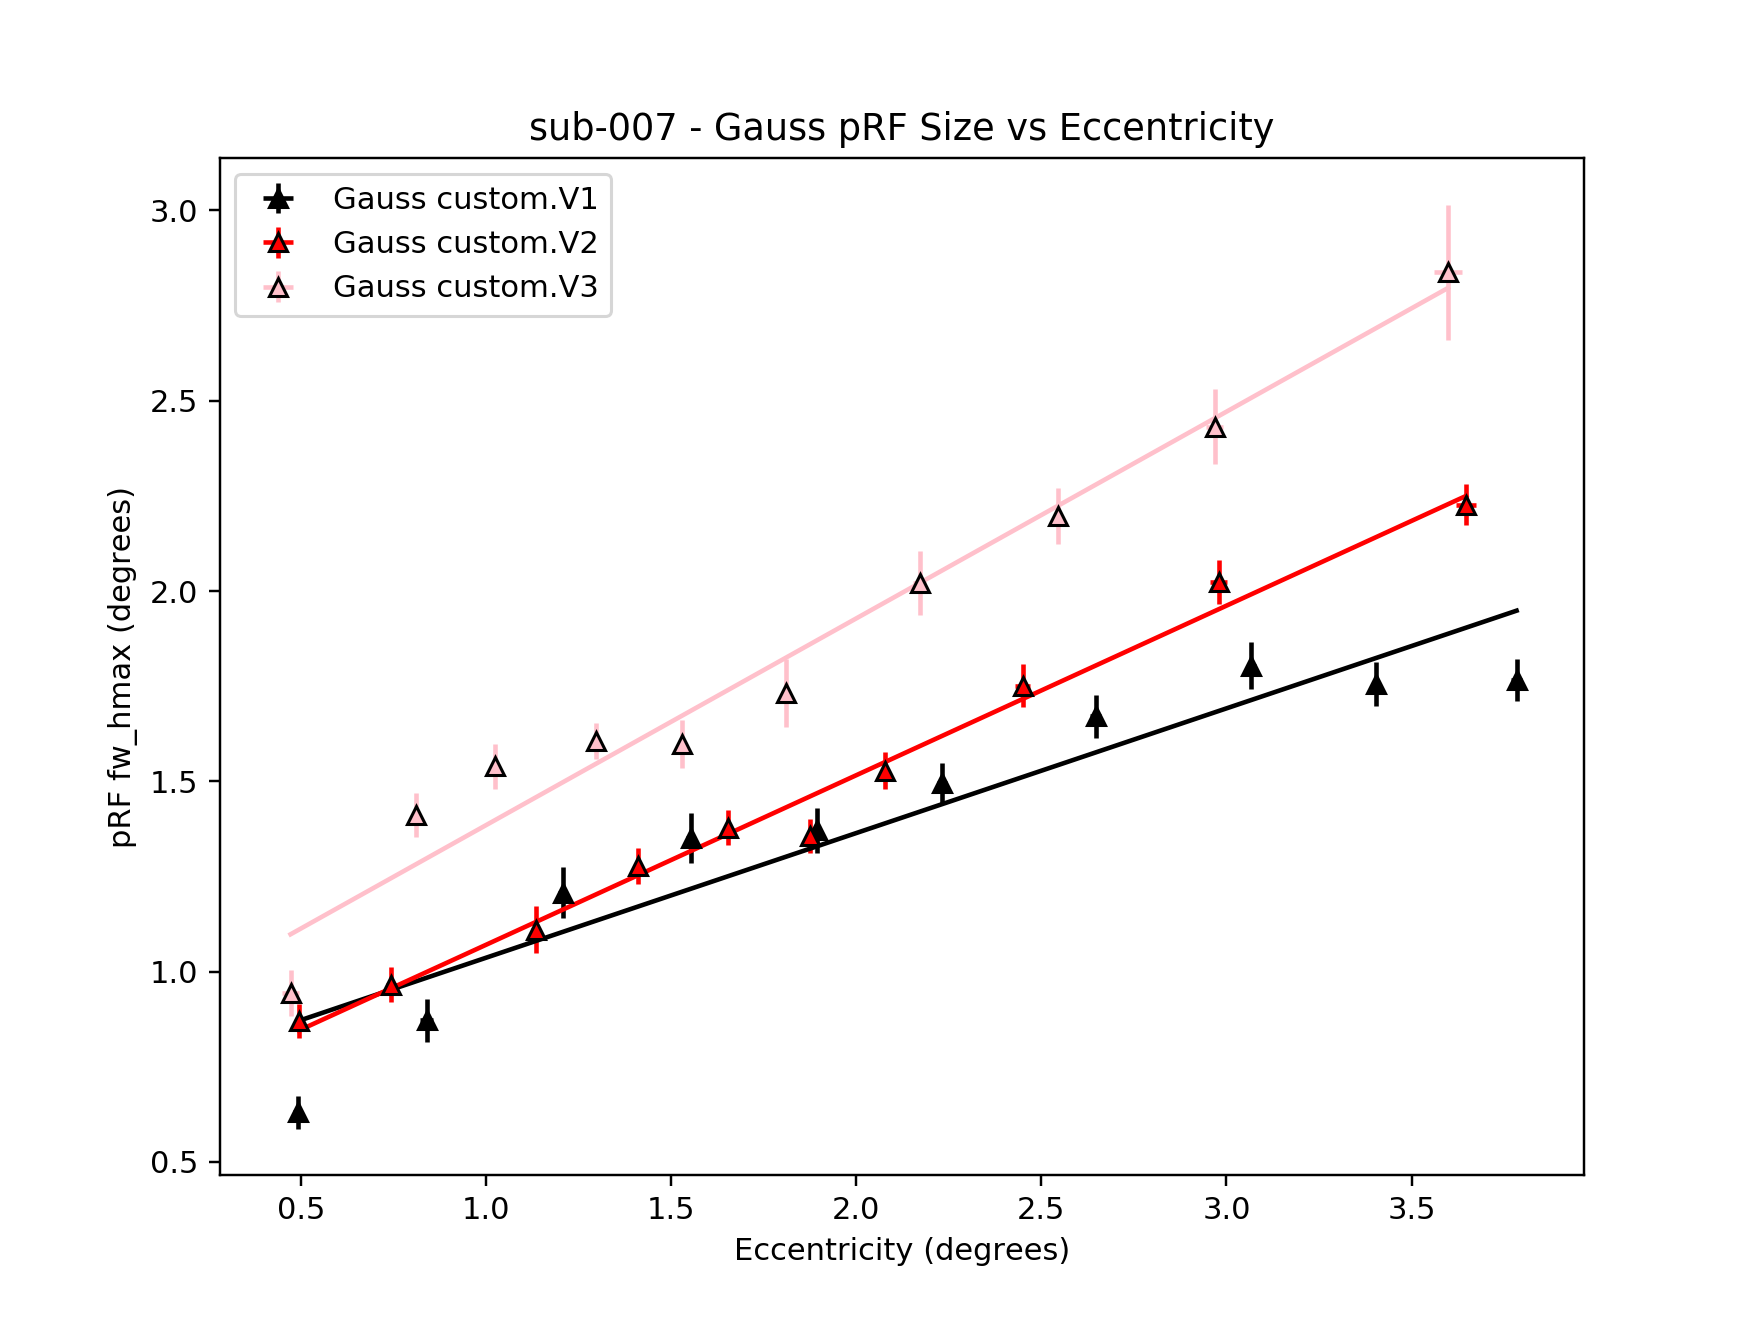

<IPython.core.display.Javascript object>


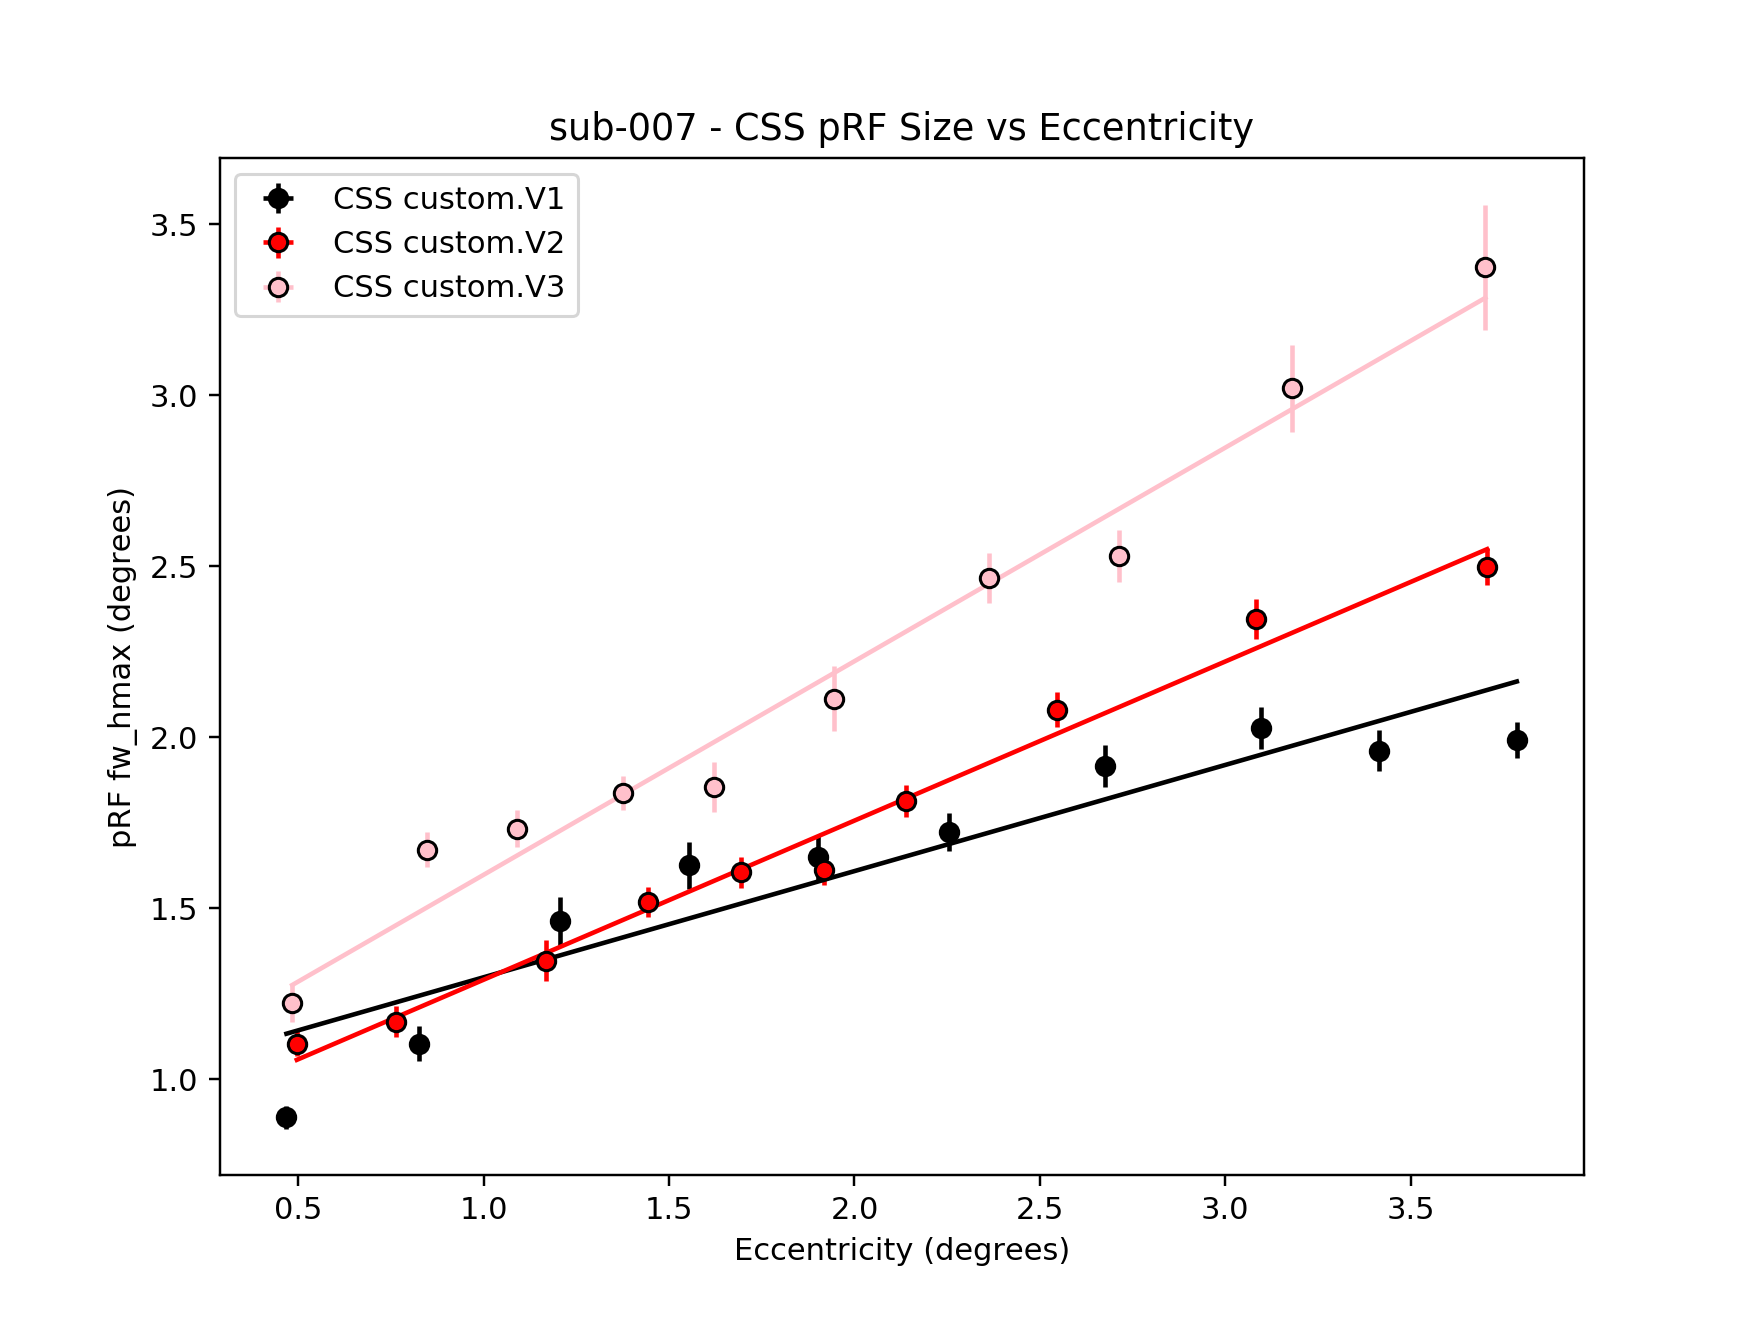

<IPython.core.display.Javascript object>


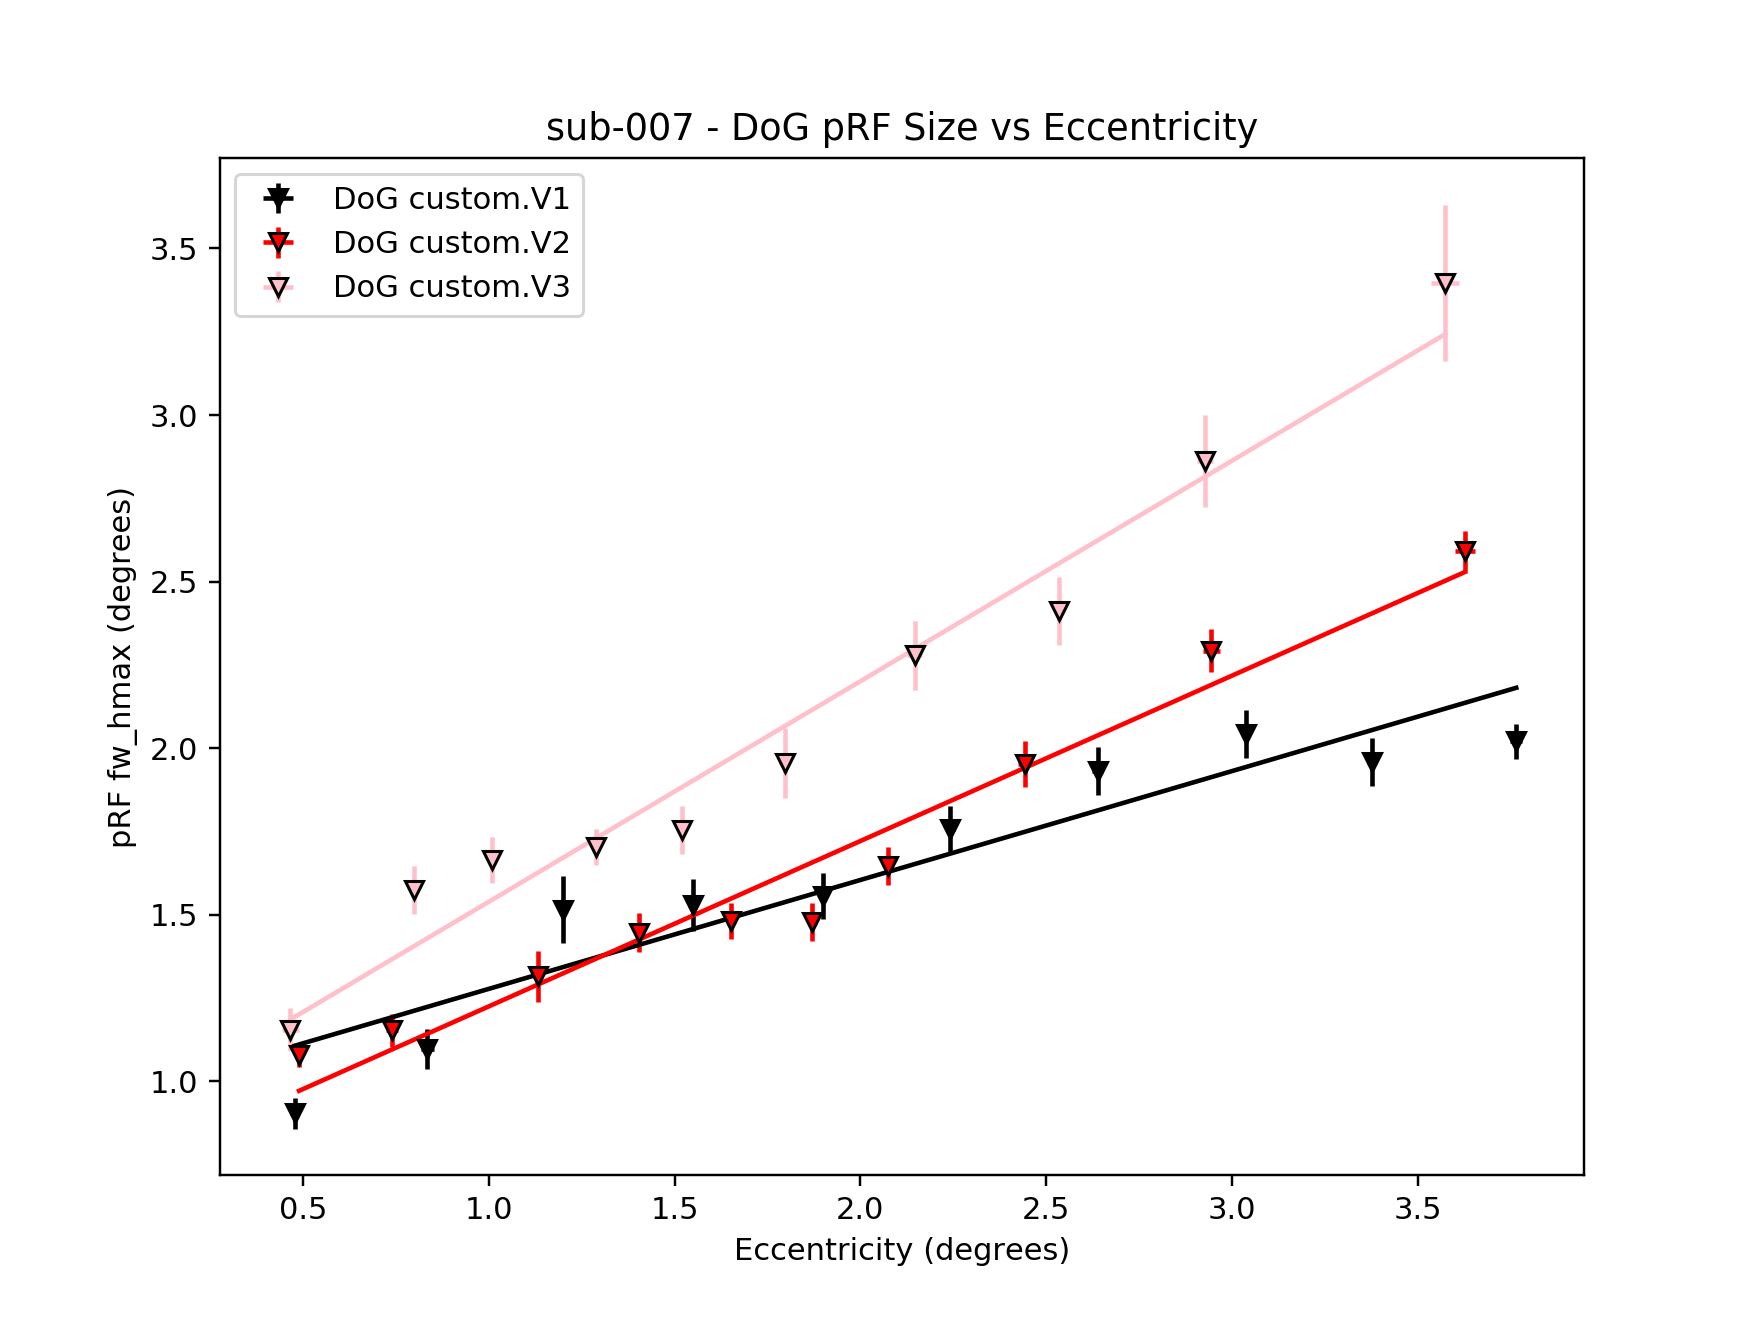

<IPython.core.display.Javascript object>


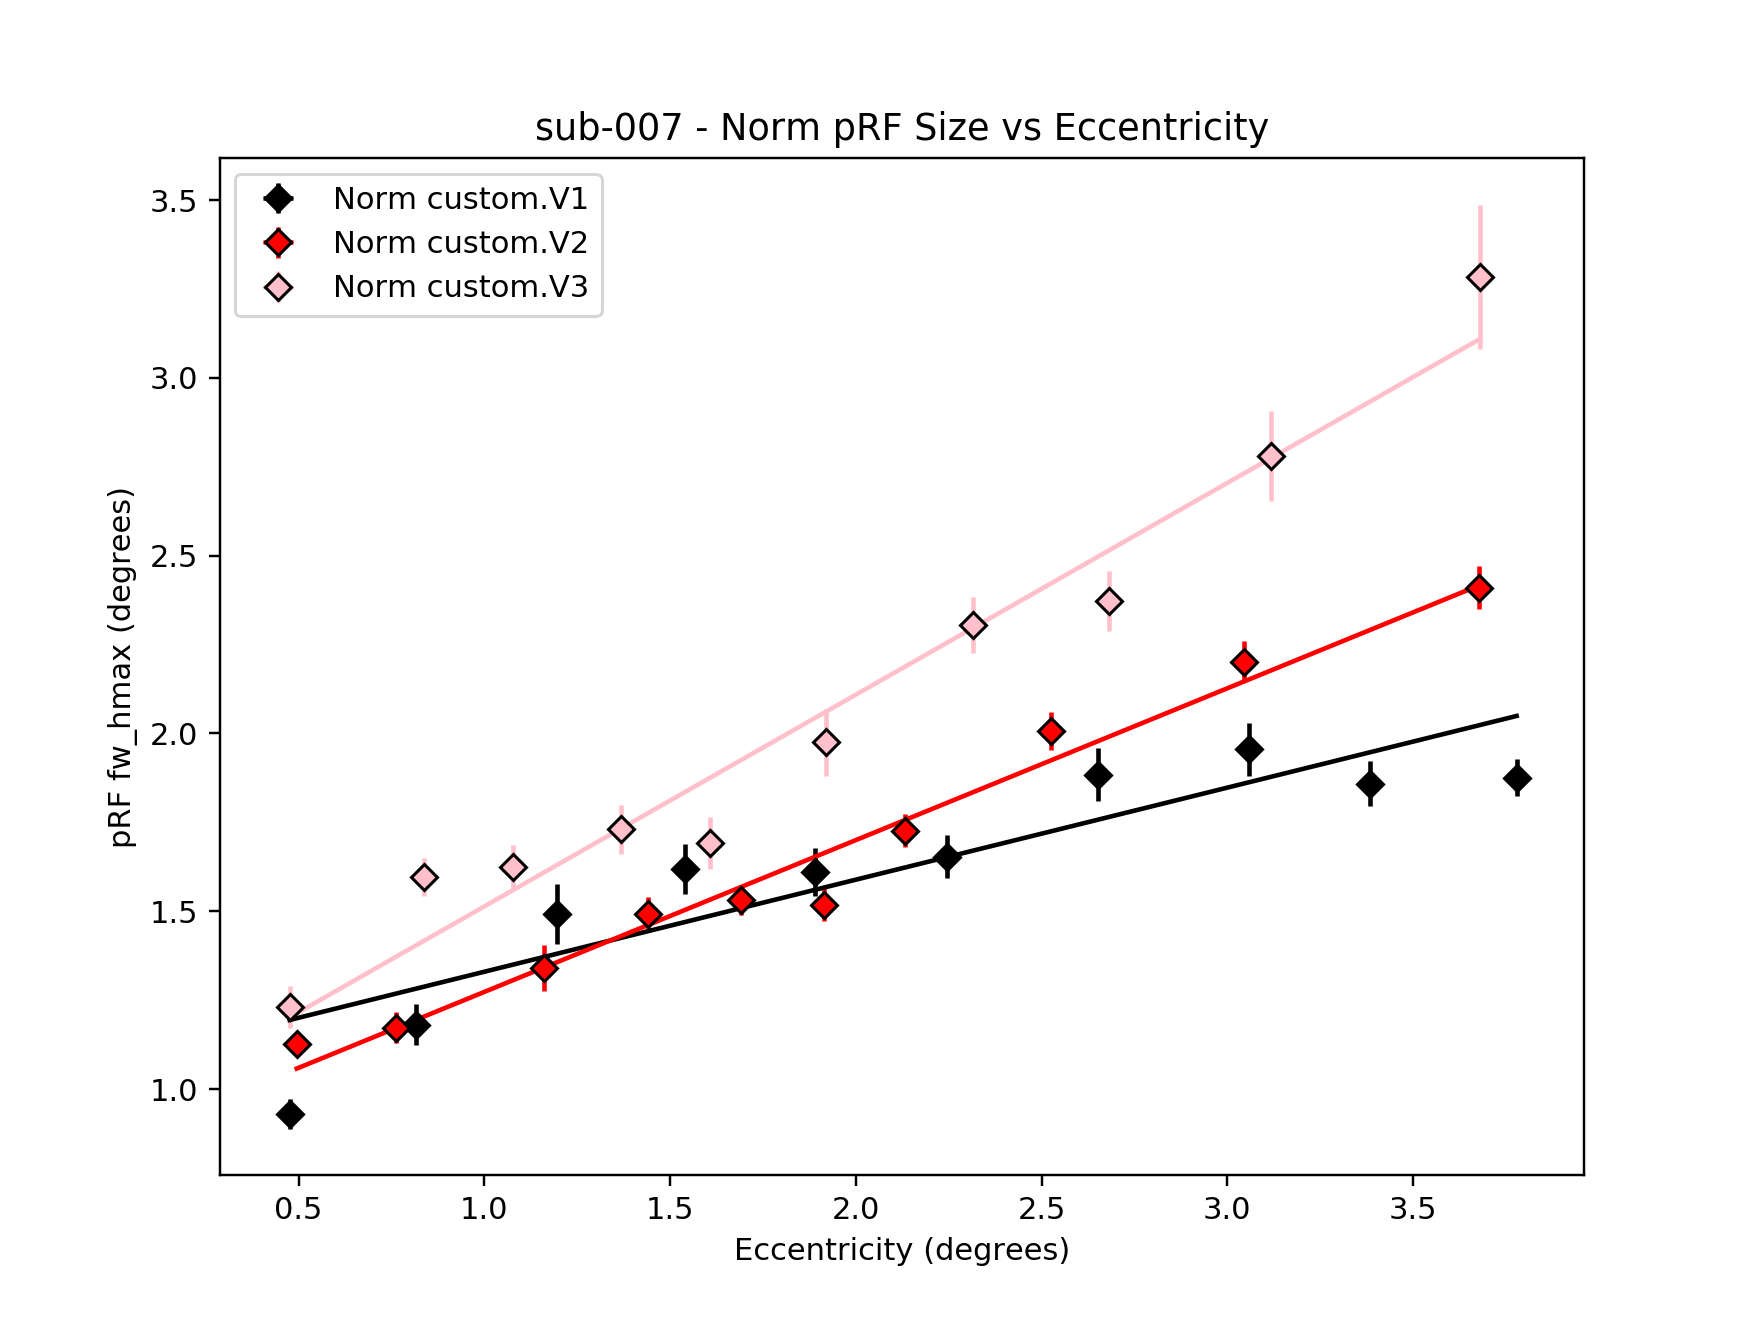

In [98]:
# binned eccentricity vs other parameters relationships
pl.close('all')
rsq_thresh = 0.3

colors = {}
colors['custom.V1']= 'black'
colors['custom.V2']= 'red'
colors['custom.V3']= 'pink'

symbol = {}
symbol['Gauss'] = '^'
symbol['CSS'] = 'o'
symbol['DoG'] = 'v'
symbol['Norm'] = 'D'

fw_hmax_stats = {}
ecc_stats = {}

for roi in colors:#idx_rois:
    
    fw_hmax_stats[roi] = {}
    ecc_stats[roi] = {}
    
    #same alpha for all
    #alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    #ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
    #split_ecc_bins = np.array_split(ecc_sorted, 20, axis=0)    
    
    for i, model in enumerate(['Gauss','CSS','DoG','Norm']):
        
        pl.figure(model+' fw_hmax', figsize=(8, 6))
        pl.title(subj+' - '+model+' pRF Size vs Eccentricity')
                
        fw_hmax_stats[roi][model]=[]
        ecc_stats[roi][model]=[]
        
        #model-specific alpha
        alpha_roi = (roi_mask(idx_rois[roi],alpha_dict[model])>rsq_thresh)    
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)
    
        for ecc_quantile in split_ecc_bins:
            fw_hmax_stats[roi][model].append(weightstats.DescrStatsW(fw_hmax[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

            ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))
            

        WLS = LinearRegression()
        WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])
        
        pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
                color=colors[roi])
        
        #print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])))
        
        plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
           [ss.mean for ss in fw_hmax_stats[roi][model]],
           yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_hmax_stats[roi][model]]).T,
           xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
           fmt=symbol[model], mfc=colors[roi], mec='black', label=model+ " "+roi, ecolor=colors[roi])
        
        pl.xlabel('Eccentricity (degrees)')
        pl.ylabel('pRF fw_hmax (degrees)')
        
        pl.legend(loc=0)
        
        #pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
        #           model+'_fw-hmax.png', dpi=200, bbox_inches='tight')
    
        
    


<IPython.core.display.Javascript object>


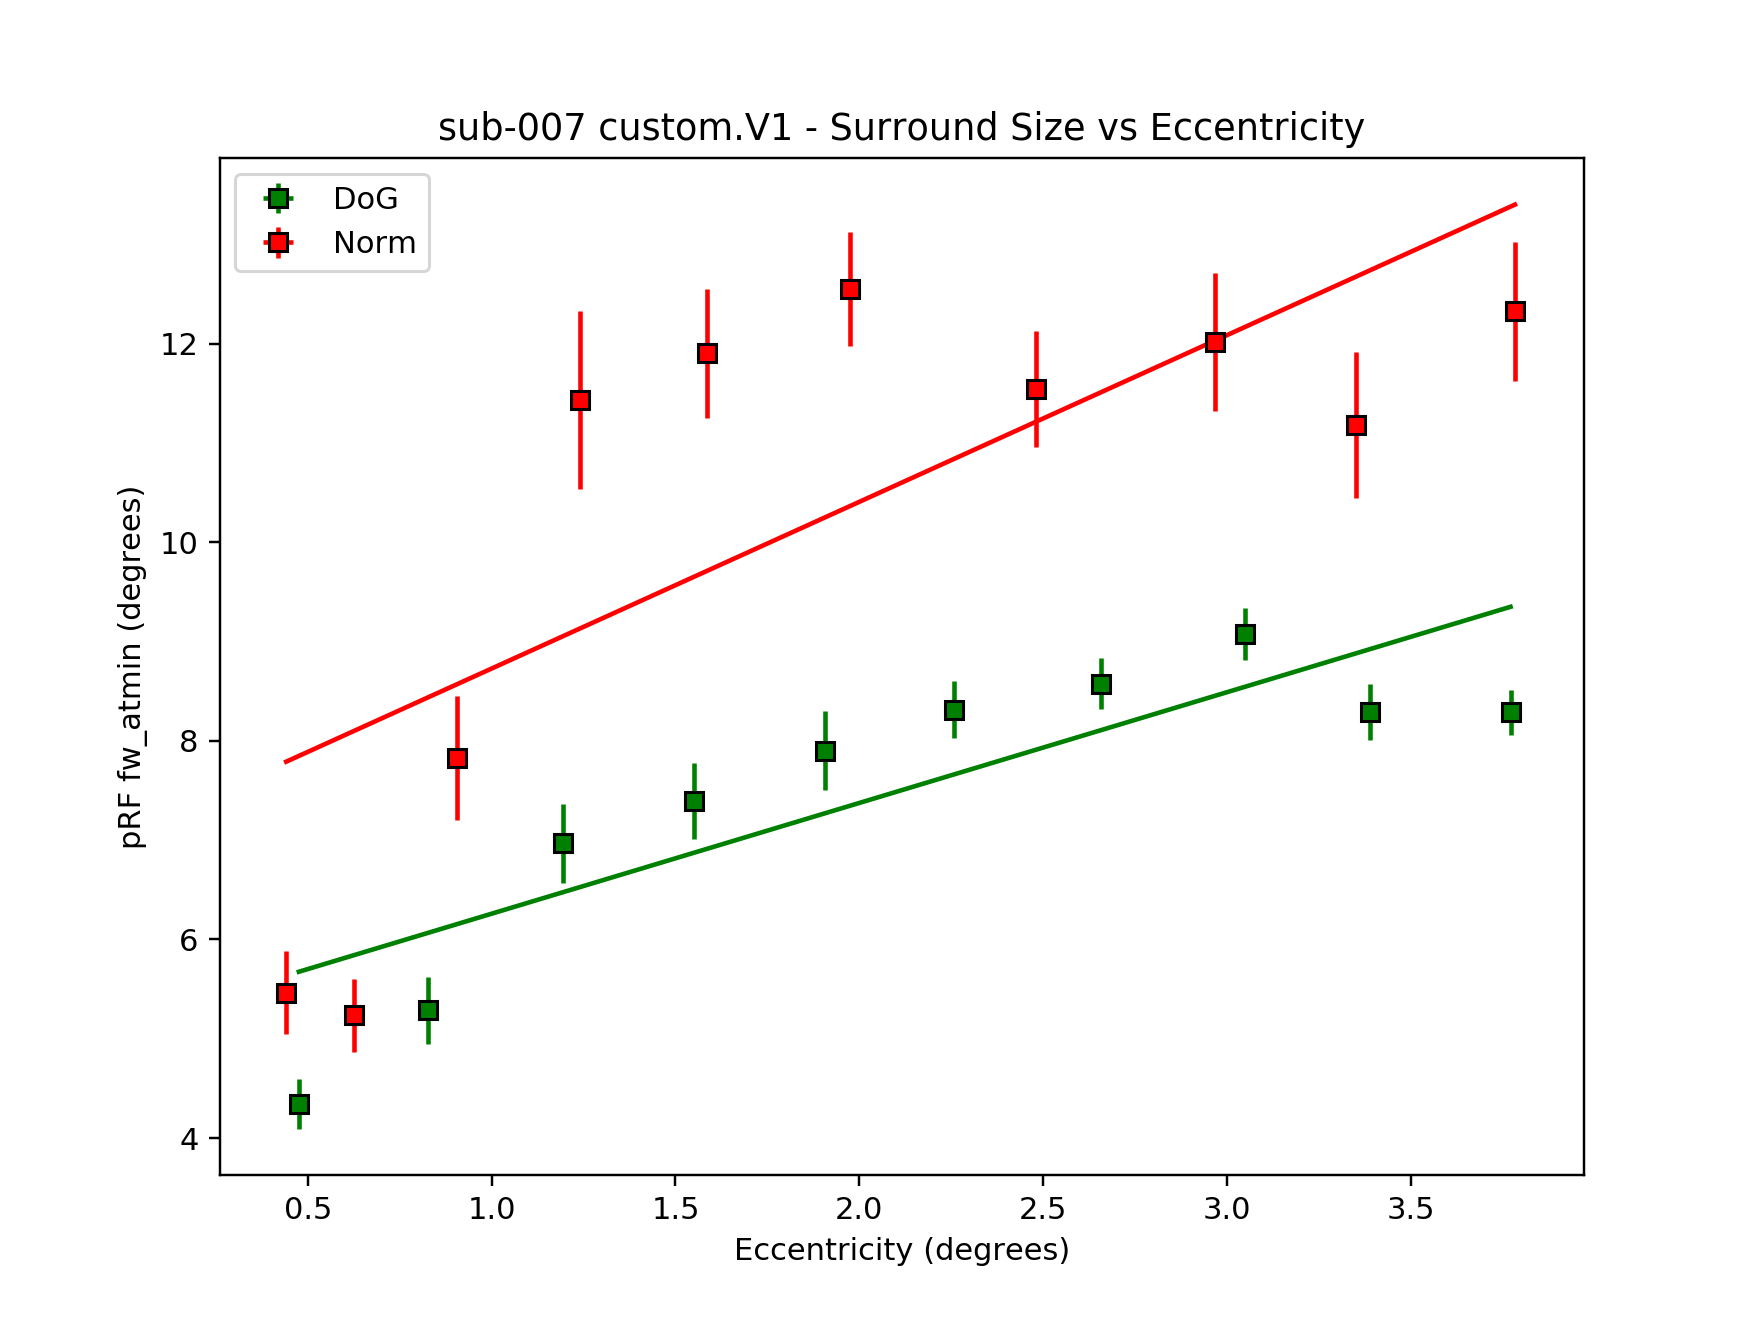

custom.V1 DoG 0.15502567223830943
custom.V1 Norm 0.138621602069246


<IPython.core.display.Javascript object>


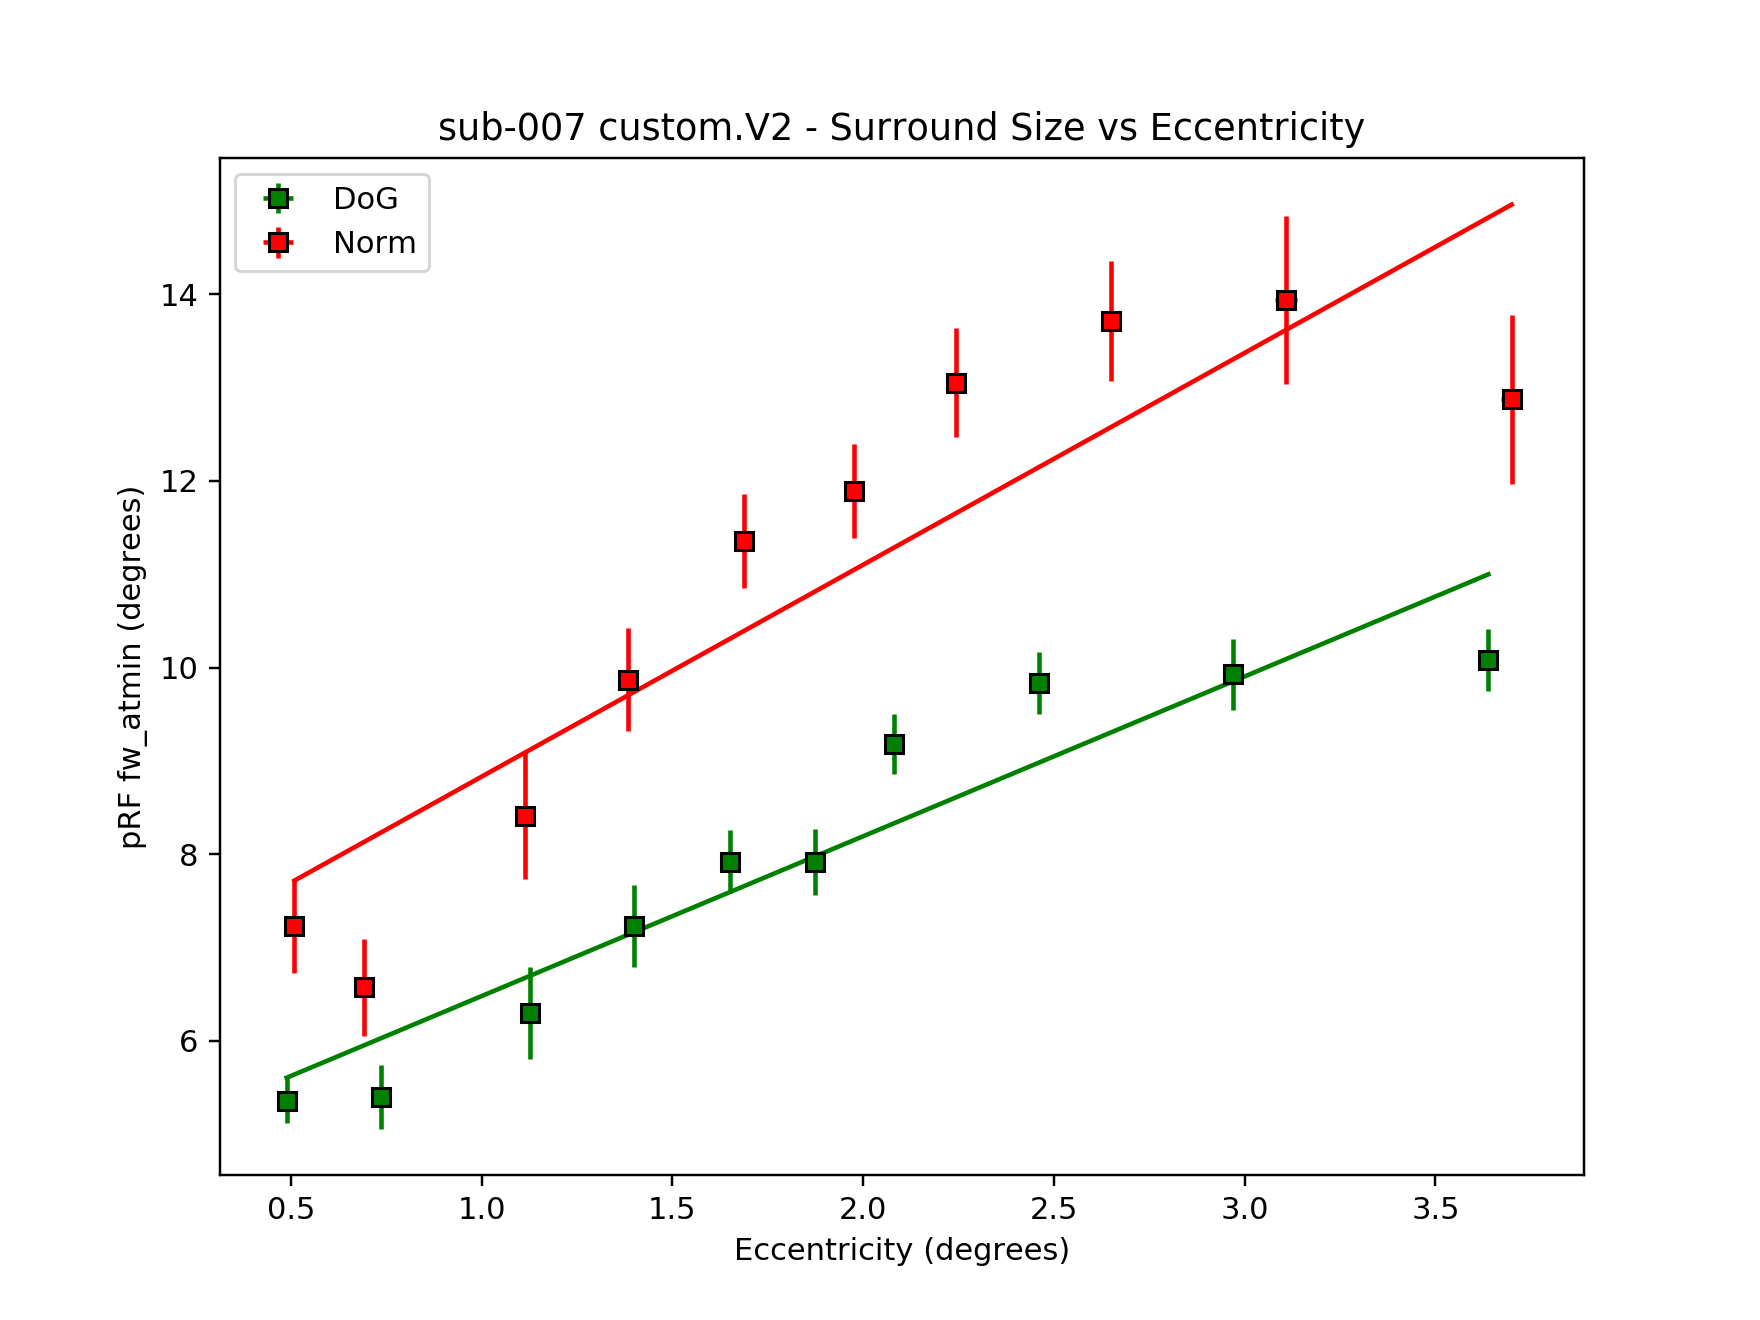

custom.V2 DoG 0.2667643771808398
custom.V2 Norm 0.24381729935717644


<IPython.core.display.Javascript object>


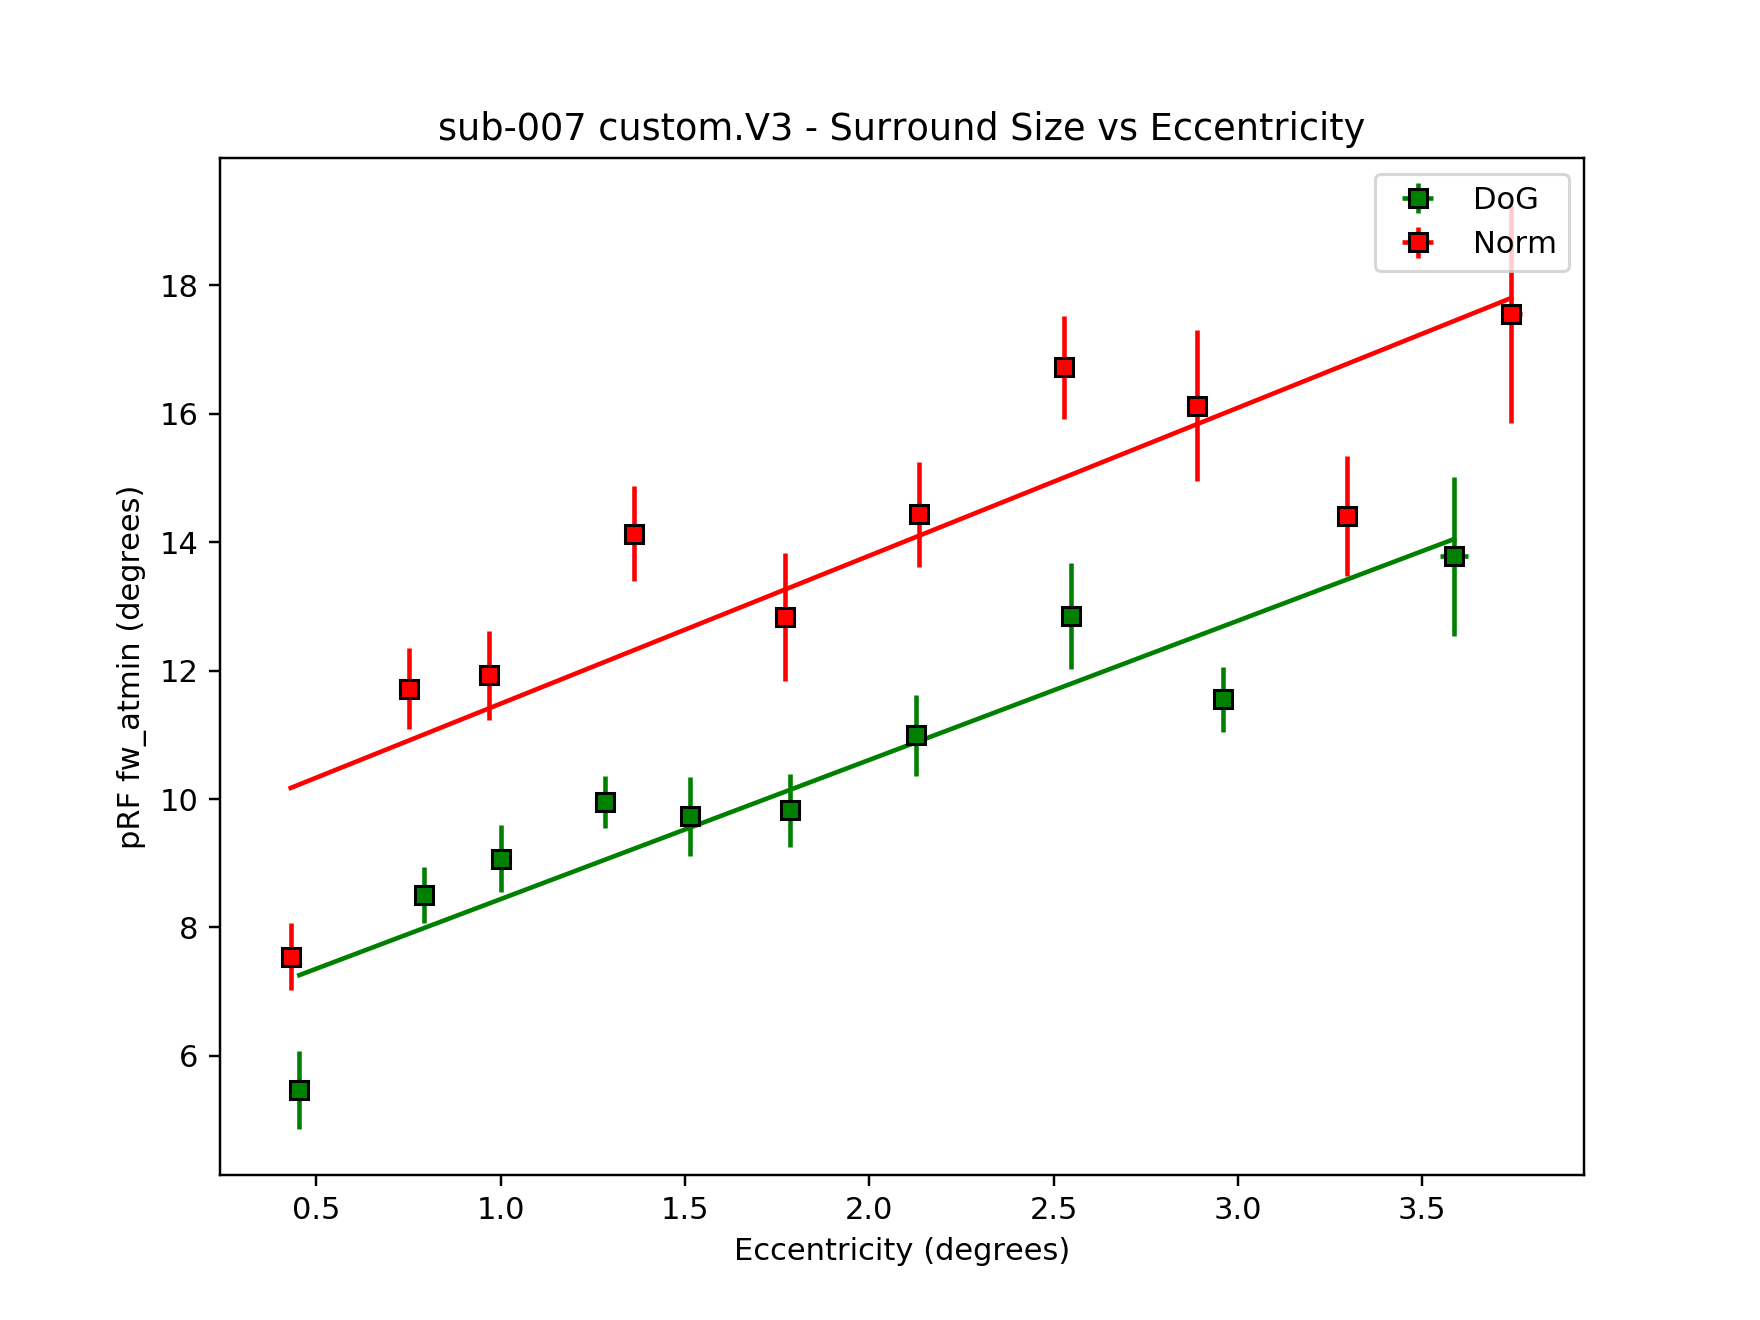

custom.V3 DoG 0.19179397263186992
custom.V3 Norm 0.19616427886253673


In [106]:
# binned eccentricity vs other parameters relationships

rsq_thresh = 0.3

colors = {}
colors['DoG'] = 'green'
colors['Norm'] = 'red'


fw_atmin_stats = {}
ecc_stats = {}

for roi in ['custom.V1', 'custom.V2', 'custom.V3']:#idx_rois:
    
    pl.figure(roi+" fw_atmin", figsize=(8, 6))
    
    pl.title(subj+' '+roi+" - Surround Size vs Eccentricity")
    
    fw_atmin_stats[roi] = {}
    ecc_stats[roi] = {}
    
    #same alpha for all
    #alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    #ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
    #split_ecc_bins = np.array_split(ecc_sorted, 20, axis=0)    
    
    for i, model in enumerate(['DoG','Norm']):
        
        #hacky. stop using arrays and use dictionaries to distinguish models instead
        i+=2
        
        fw_atmin_stats[roi][model]=[]
        ecc_stats[roi][model]=[]
        
        #model-specific alpha
        alpha_roi = (roi_mask(idx_rois[roi],alpha_dict[model])>rsq_thresh) * (fw_atmin[:,i-2]<w_max)
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)
    
        for ecc_quantile in split_ecc_bins:
            fw_atmin_stats[roi][model].append(weightstats.DescrStatsW(fw_atmin[alpha_roi,i-2][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

            ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))
            


        WLS = LinearRegression()
        WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi,i-2], sample_weight=rsq[alpha_roi,i])
        pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
               color=colors[model])
        
        print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi, i-2], sample_weight=rsq[alpha_roi,i])))
        
        plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
           [ss.mean for ss in fw_atmin_stats[roi][model]],
           yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_atmin_stats[roi][model]]).T,
           xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
           fmt='s', mfc=colors[model], mec='black', label=model, ecolor=colors[model])
        
        pl.xlabel('Eccentricity (degrees)')
        pl.ylabel('pRF fw_atmin (degrees)')
    
    pl.legend(loc=0)
    #pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
    #               roi+'_fw-atmin.png', dpi=200, bbox_inches='tight')
    
    


<IPython.core.display.Javascript object>


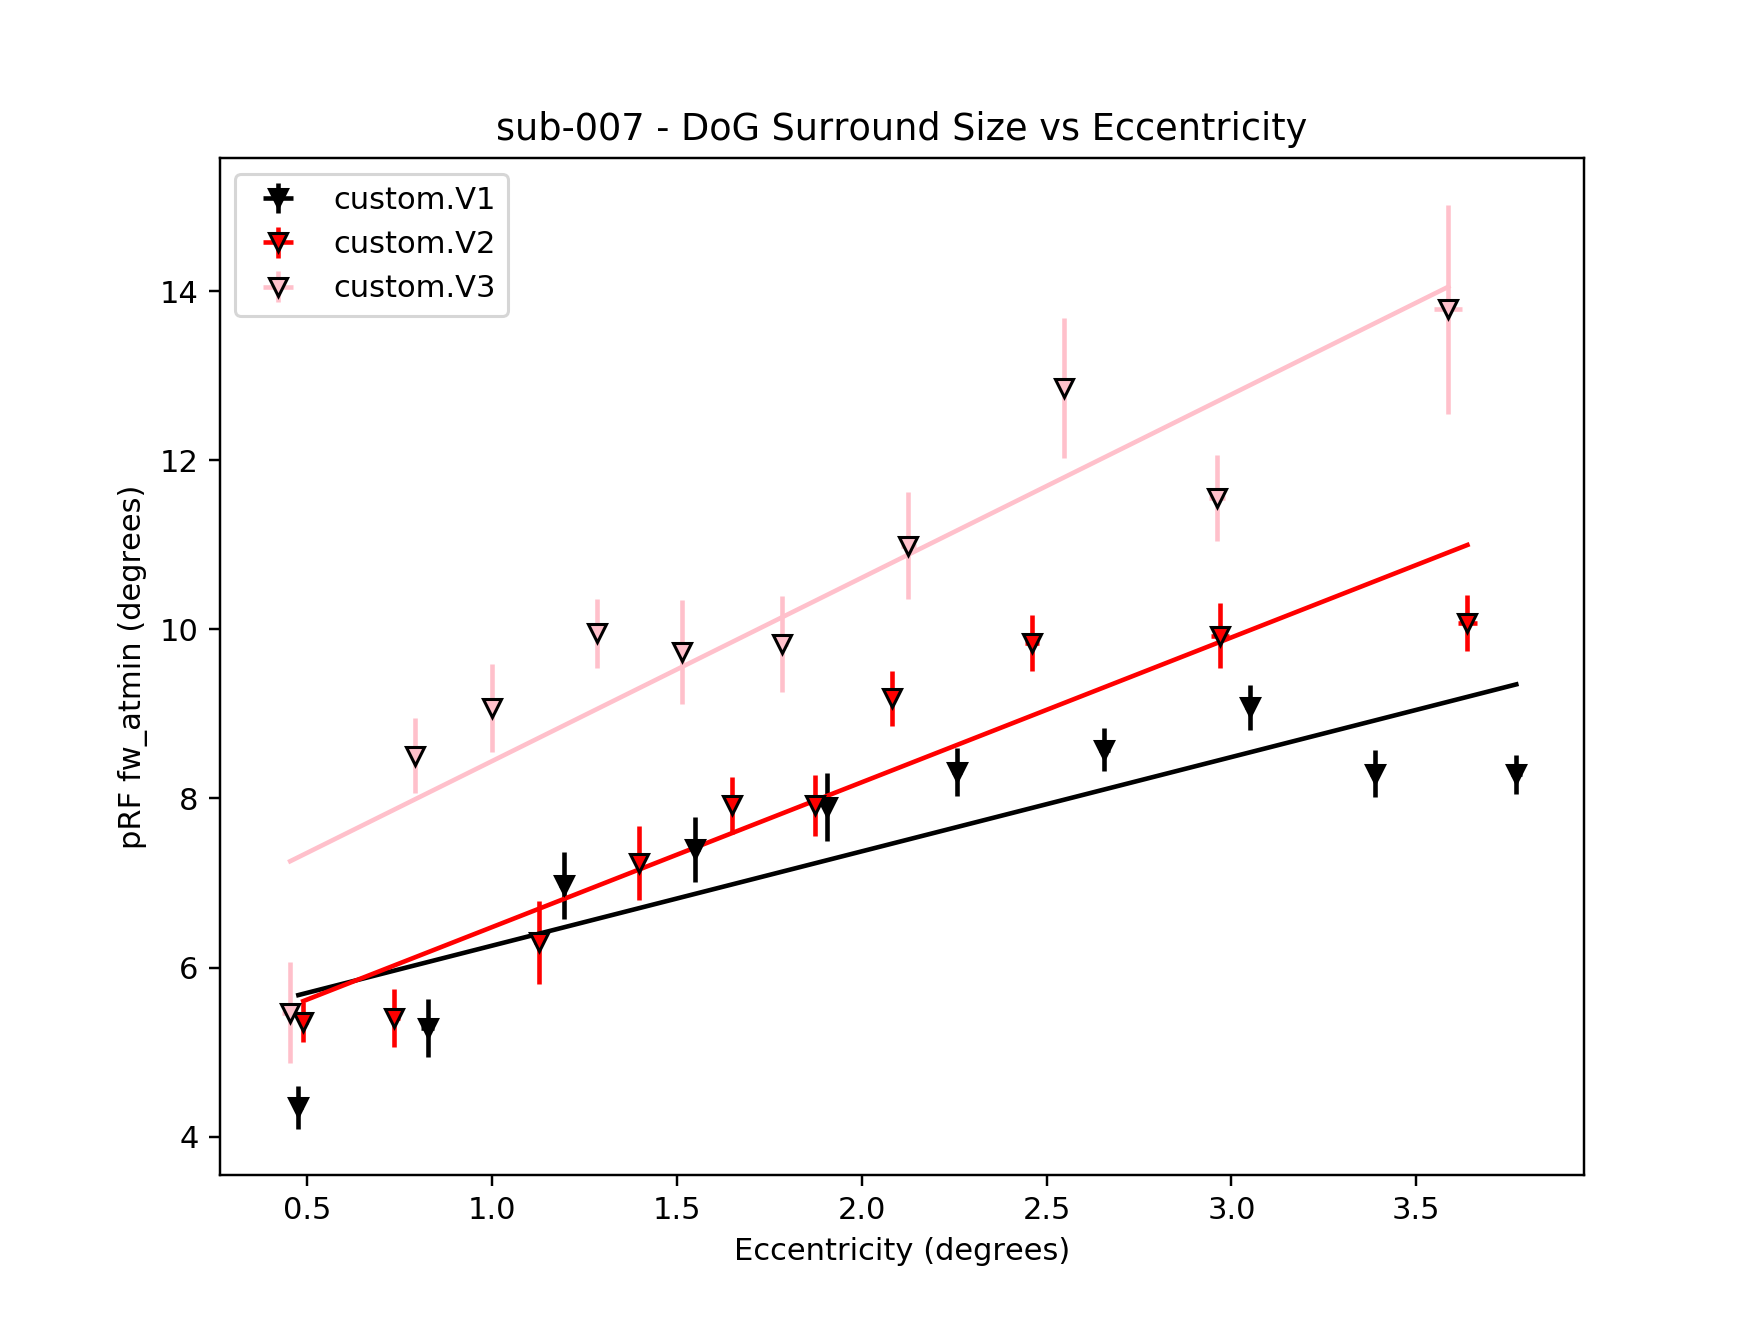

<IPython.core.display.Javascript object>


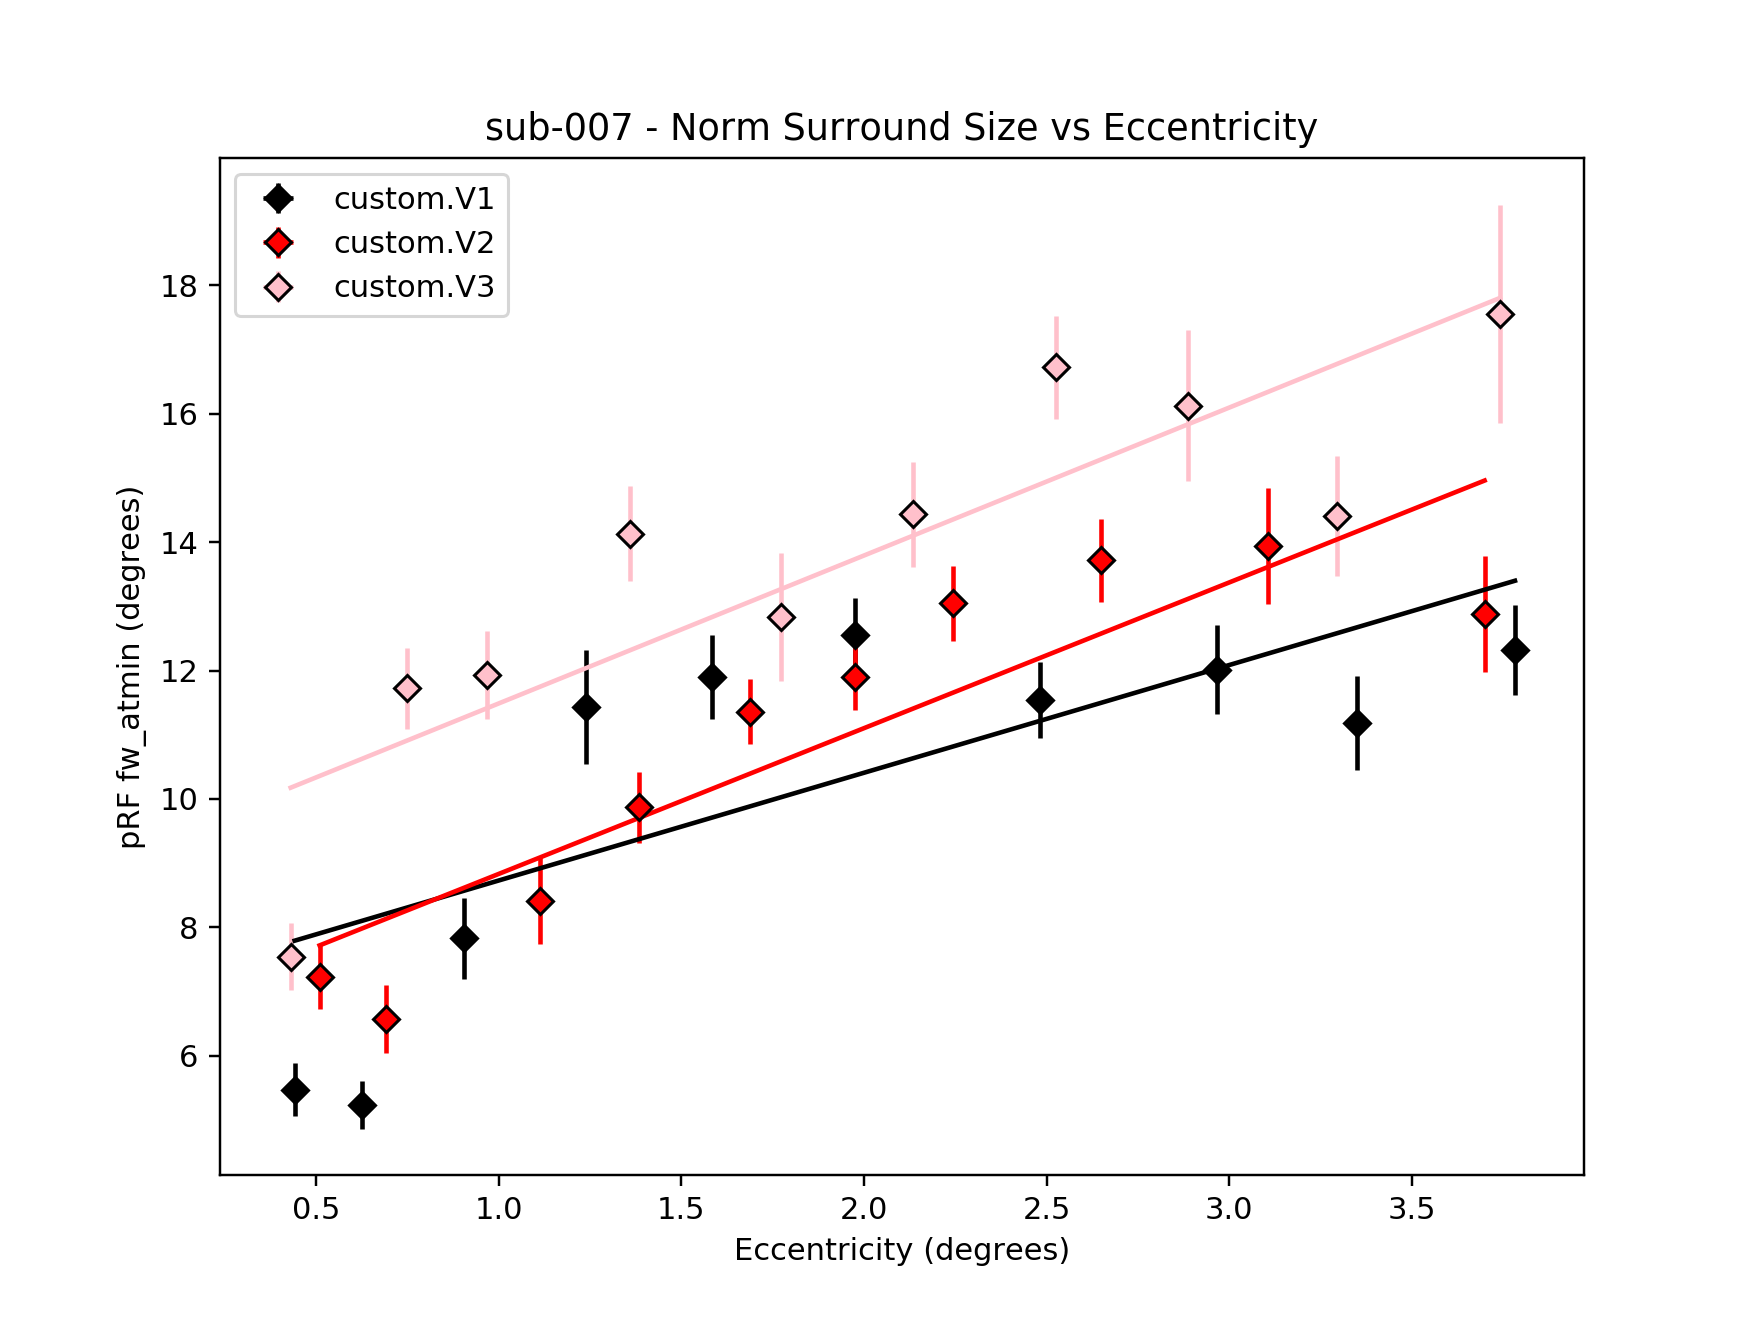

In [107]:
# binned eccentricity vs other parameters relationships

rsq_thresh = 0.3

colors = {}
colors['custom.V1']= 'black'
colors['custom.V2']= 'red'
colors['custom.V3']= 'pink'

symbol = {}
symbol['Gauss'] = 's'
symbol['CSS'] = 'o'
symbol['DoG'] = 'v'
symbol['Norm'] = 'D'

fw_atmin_stats = {}
ecc_stats = {}

for roi in colors:#idx_rois:
    
    fw_atmin_stats[roi] = {}
    ecc_stats[roi] = {}
    
    #same alpha for all
    #alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    #ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
    #split_ecc_bins = np.array_split(ecc_sorted, 20, axis=0)    
    
    for i, model in enumerate(['DoG','Norm']):
        
        #HACKY. stop using arrays and use dictionaries to distinguish models instead
        i+=2
        
        pl.figure(model+" fw_atmin", figsize=(8, 6))
        pl.title(subj+' - '+model+' Surround Size vs Eccentricity')
        
        fw_atmin_stats[roi][model]=[]
        ecc_stats[roi][model]=[]
        
        #model-specific alpha
        alpha_roi = (roi_mask(idx_rois[roi],alpha_dict[model])>rsq_thresh) * (fw_atmin[:,i-2]<w_max)
        
        
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)
        
        
        for ecc_quantile in split_ecc_bins:
            fw_atmin_stats[roi][model].append(weightstats.DescrStatsW(fw_atmin[alpha_roi,i-2][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

            ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))
            


        WLS = LinearRegression()
        WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi,i-2], sample_weight=rsq[alpha_roi,i])
        pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
               color=colors[roi])
        
        #print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi,i], sample_weight=rsq[alpha_roi,i])))
        
        plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
           [ss.mean for ss in fw_atmin_stats[roi][model]],
           yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_atmin_stats[roi][model]]).T,
           xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
           fmt=symbol[model], mfc=colors[roi], mec='black', label=roi, ecolor=colors[roi])
        
        pl.xlabel('Eccentricity (degrees)')
        pl.ylabel('pRF fw_atmin (degrees)')
        
        pl.legend(loc=0)
        #pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
        #           model+'_fw-atmin.png', dpi=200, bbox_inches='tight')
    
        
    


<IPython.core.display.Javascript object>


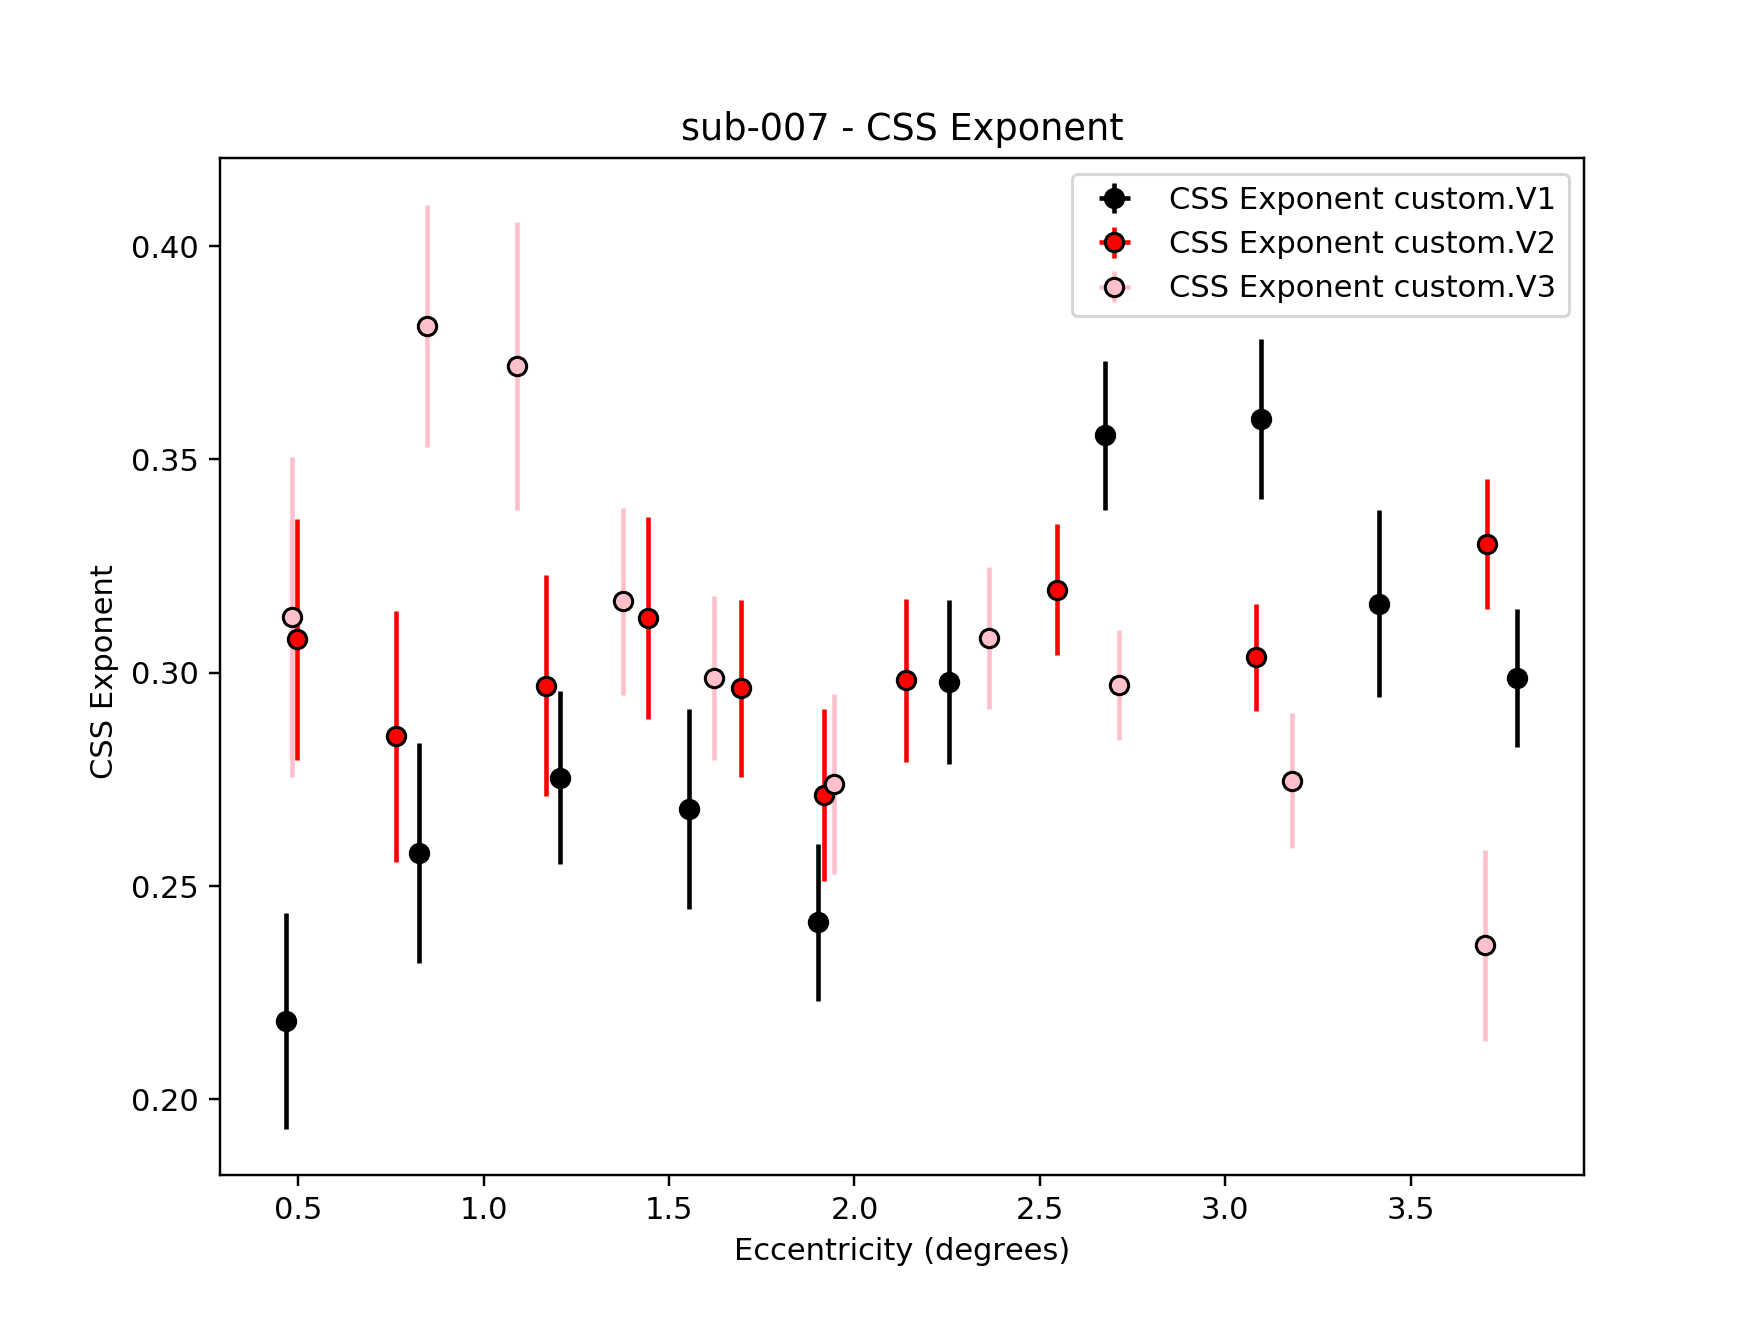

In [109]:
# binned eccentricity vs other parameters relationships
rsq_thresh = 0.3


colors = {}
colors['custom.V1']= 'black'
colors['custom.V2']= 'red'
colors['custom.V3']= 'pink'

symbol = {}
symbol['CSS Exponent'] = 'o'



css_exp_stats = {}
ecc_stats = {}

for roi in colors:#idx_rois:
    
    css_exp_stats[roi] = {}
    ecc_stats[roi] = {}
    
    alpha_roi = roi_mask(idx_rois[roi],alpha_css)>rsq_thresh
                         
    if alpha_roi.sum()>40:    
    
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)

        #note: here i indexes different params of same model (above it is same param in different models)
        #therefore ecc_stats is the same for all params
        for i, param in enumerate(['CSS Exponent']):
            pl.figure(param, figsize=(8, 6))
            pl.title(subj+' - '+param)
            
            css_exp_stats[roi][param]=[]
            ecc_stats[roi][param]=[]

            for ecc_quantile in split_ecc_bins:
                css_exp_stats[roi][param].append(weightstats.DescrStatsW(css_exp[alpha_roi][ecc_quantile[:,1]],
                                                                      weights=rsq[alpha_roi,1][ecc_quantile[:,1]]))

                ecc_stats[roi][param].append(weightstats.DescrStatsW(ecc[alpha_roi,1][ecc_quantile[:,1]],
                                                                      weights=rsq[alpha_roi,1][ecc_quantile[:,1]]))




            plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][param]],
               [ss.mean for ss in css_exp_stats[roi][param]],
               yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in css_exp_stats[roi][param]]).T,
               xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][param]]).T,
               fmt=symbol[param], mfc=colors[roi], mec='black', label=param+" "+roi, ecolor=colors[roi])
            #pl.yscale('log')
            pl.legend(loc=0)
            pl.xlabel('Eccentricity (degrees)')
            pl.ylabel('CSS Exponent ')
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
        
    
#pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
#                   'CSS-exponent.png', dpi=200, bbox_inches='tight')    
    

<IPython.core.display.Javascript object>


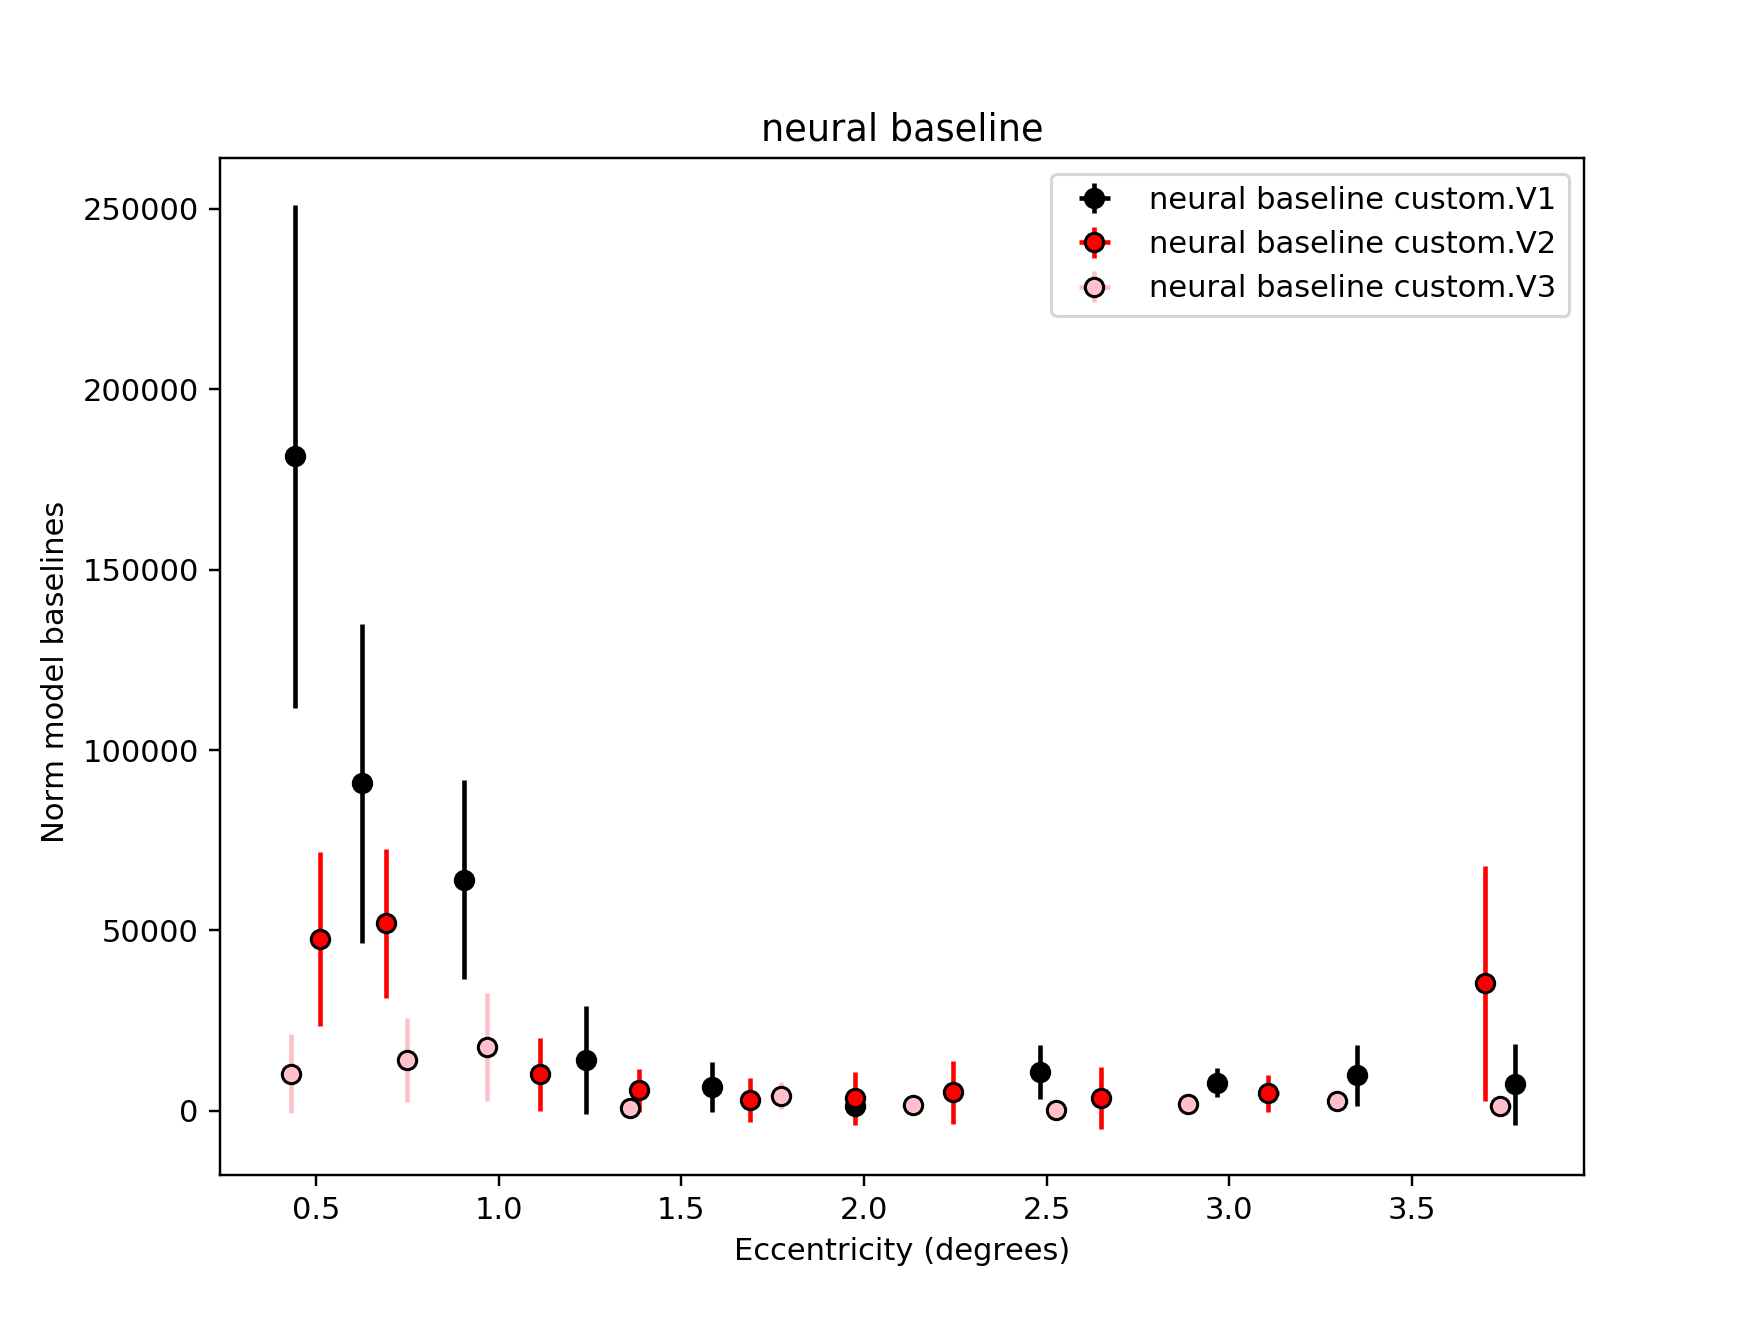

<IPython.core.display.Javascript object>


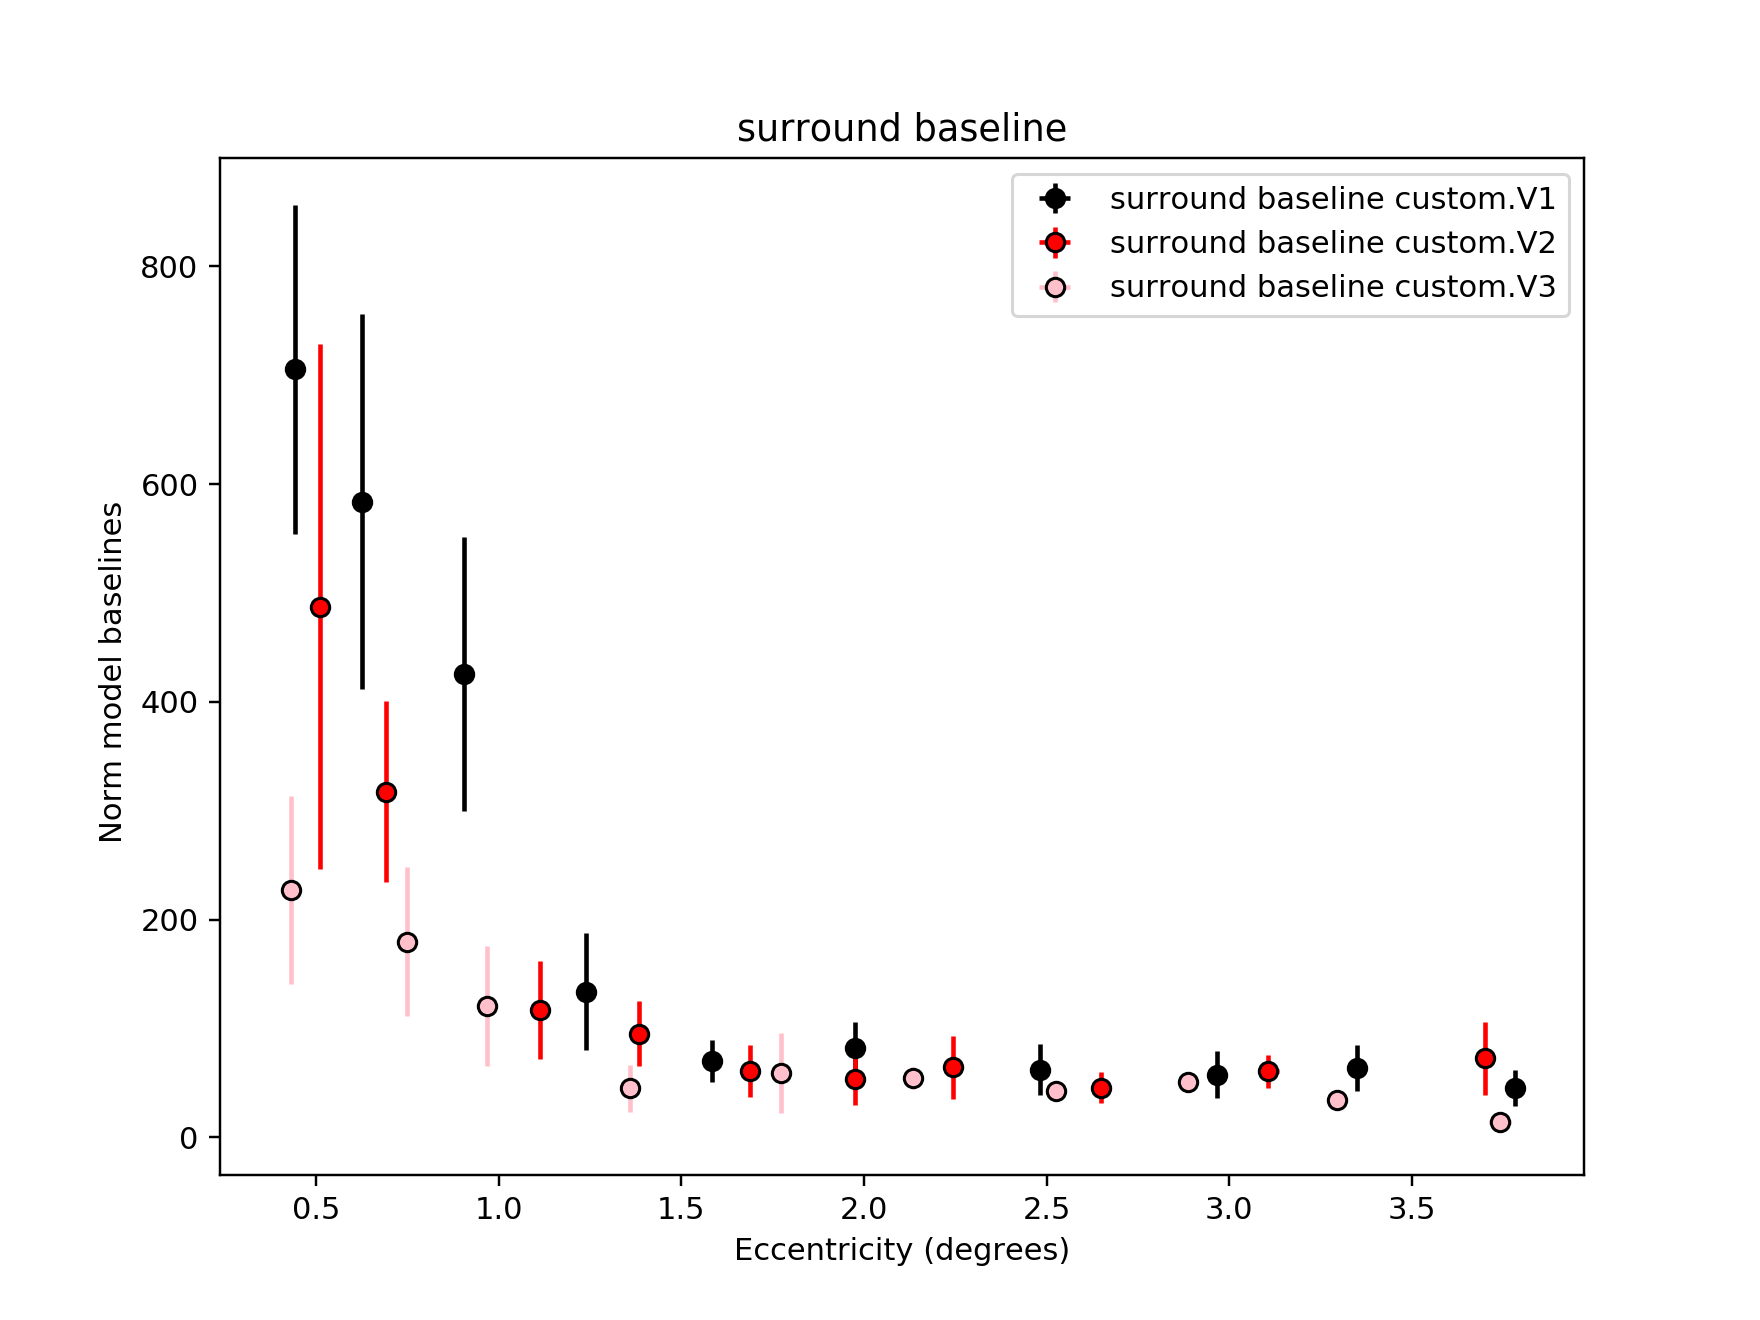

<IPython.core.display.Javascript object>


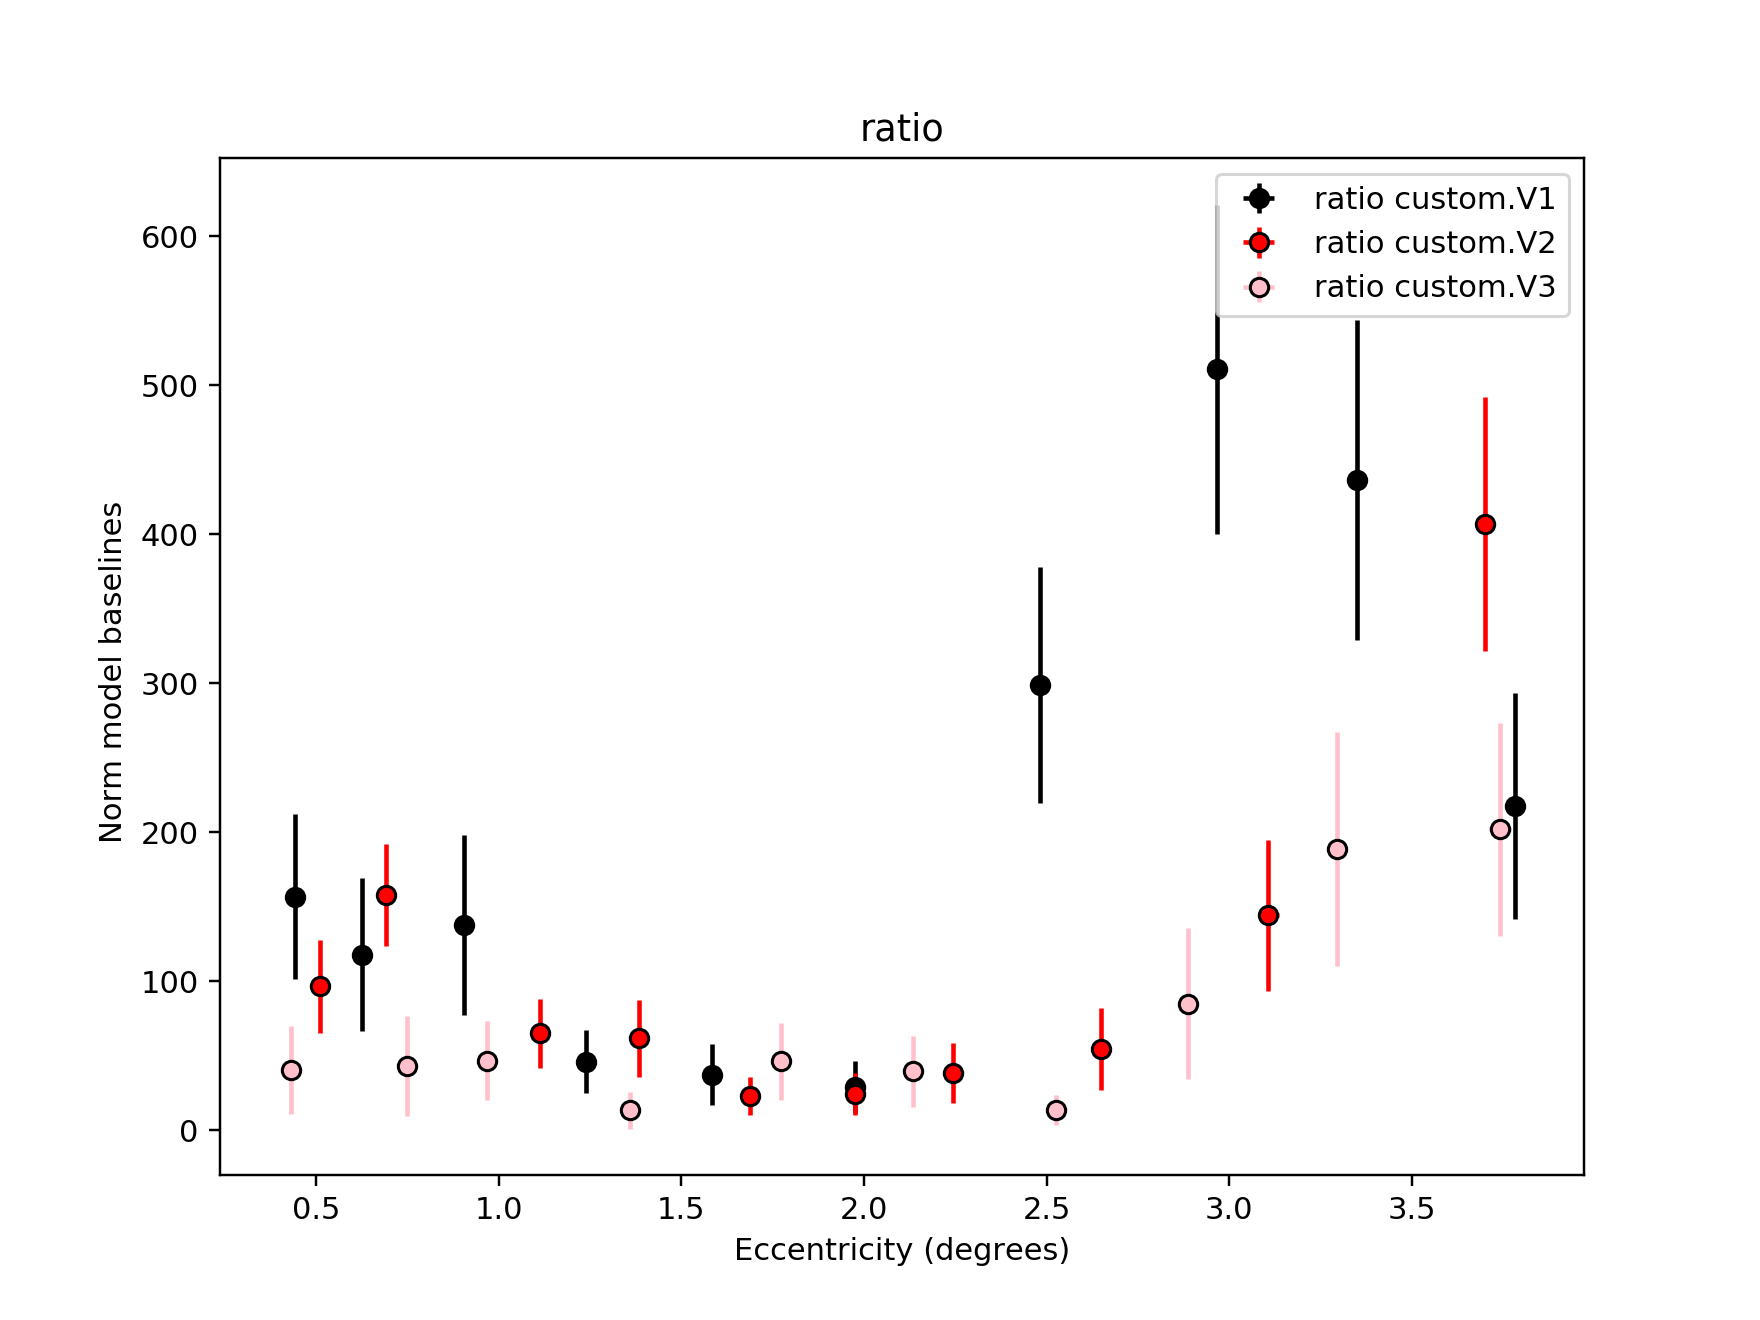

<IPython.core.display.Javascript object>


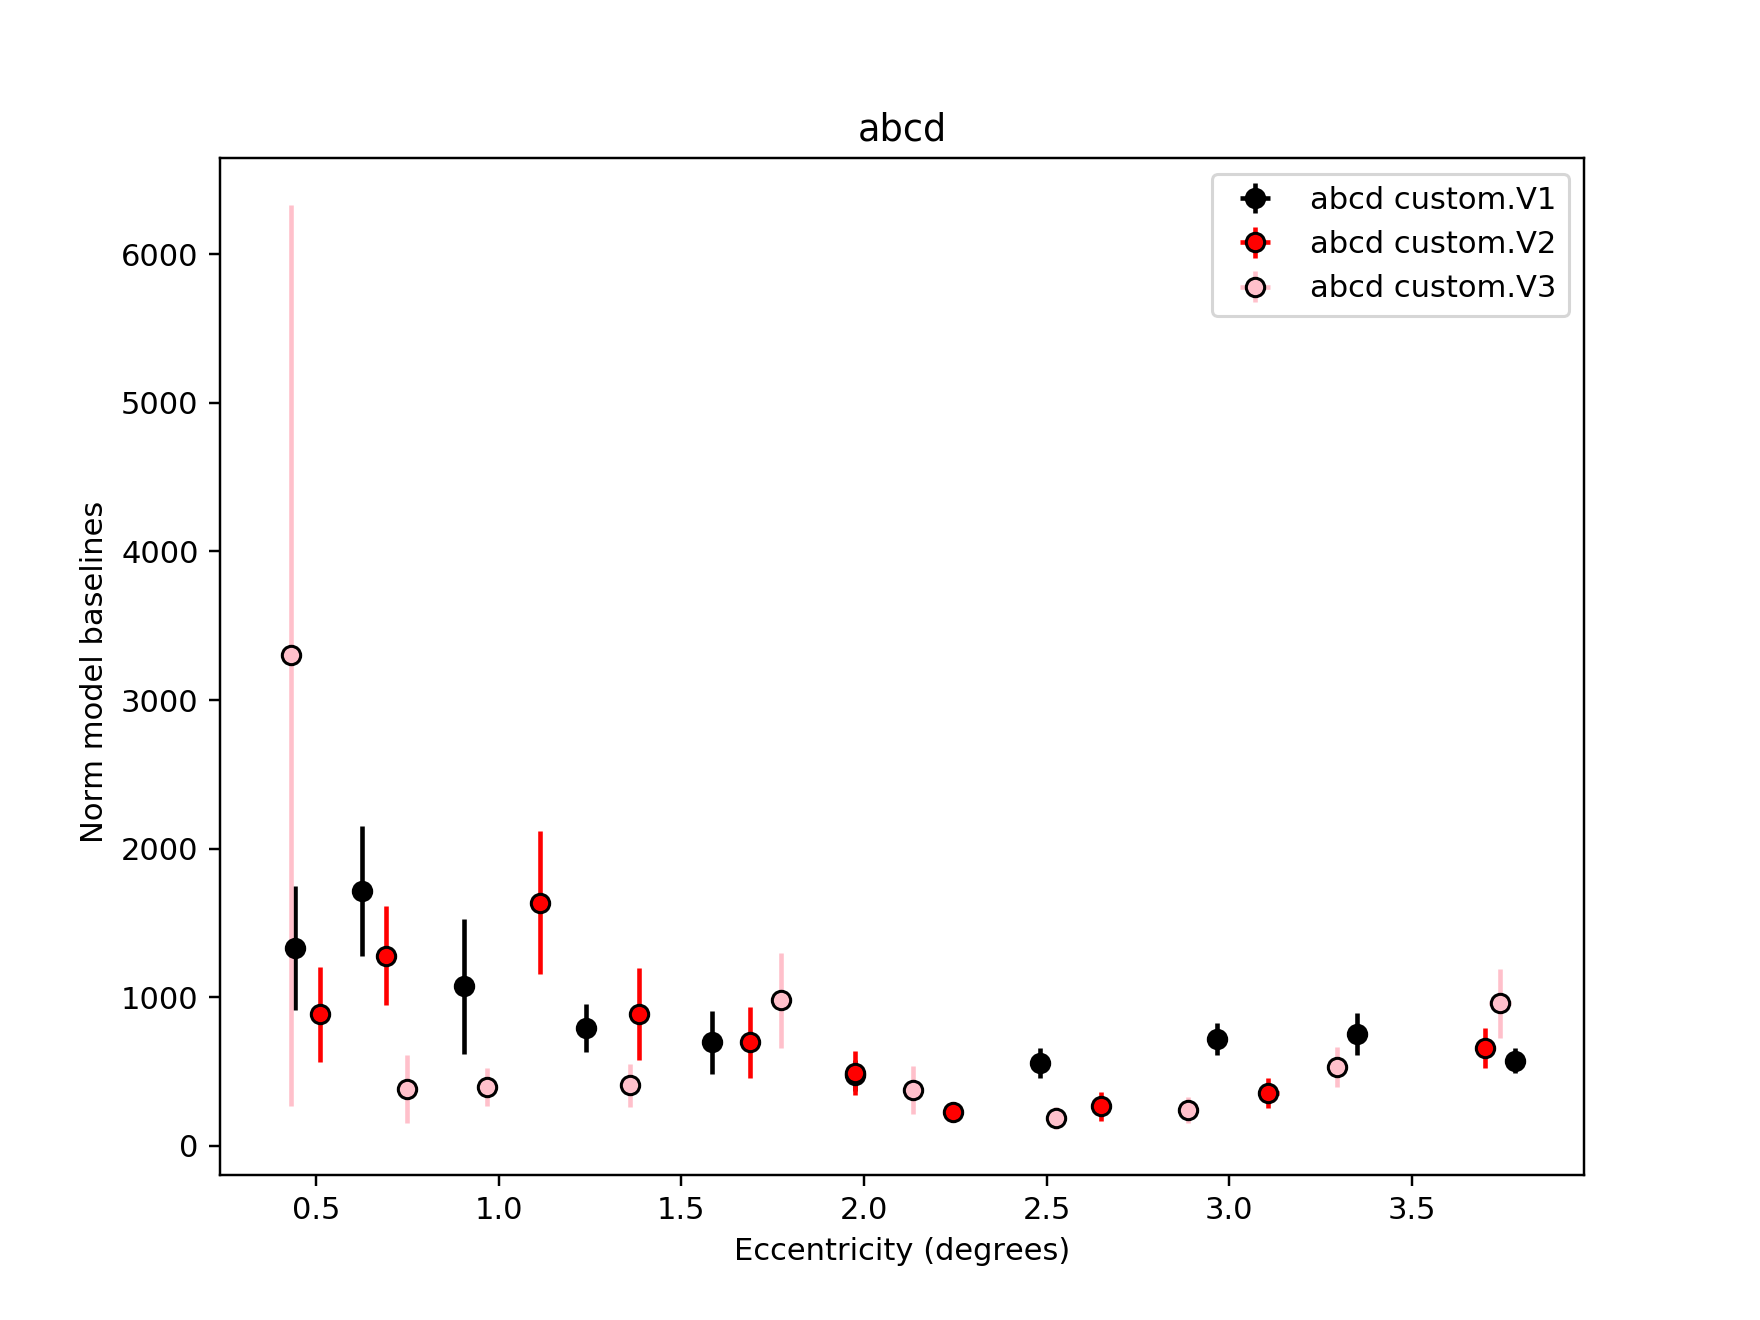

In [296]:
# binned eccentricity vs other parameters relationships
rsq_thresh = 0.3


colors = {}
colors['custom.V1']= 'black'
colors['custom.V2']= 'red'
colors['custom.V3']= 'pink'

symbol = {}
symbol['neural baseline'] = 'o'
symbol['surround baseline'] = 'o'
symbol['ratio'] = 'o'
symbol['abcd'] = 'o'


baselines_stats = {}
ecc_stats = {}

for roi in colors:#idx_rois:
    
    baselines_stats[roi] = {}
    ecc_stats[roi] = {}
    
    alpha_roi = (roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh) 
    if alpha_roi.sum()>40:    
    
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)

        #note: here i indexes different params of same model (above it is same param in different models)
        #therefore ecc_stats is the same for all params
        for i, param in enumerate(['neural baseline', 'surround baseline', 'ratio', 'abcd']):
            pl.figure(param, figsize=(8, 6))
            pl.title(param)
            
            baselines_stats[roi][param]=[]
            ecc_stats[roi][param]=[]

            for ecc_quantile in split_ecc_bins:
                baselines_stats[roi][param].append(weightstats.DescrStatsW(baselines[alpha_roi,i][ecc_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))

                ecc_stats[roi][param].append(weightstats.DescrStatsW(ecc[alpha_roi,3][ecc_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))




            plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][param]],
               [ss.mean for ss in baselines_stats[roi][param]],
               yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in baselines_stats[roi][param]]).T,
               xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][param]]).T,
               fmt=symbol[param], mfc=colors[roi], mec='black', label=param+" "+roi, ecolor=colors[roi])
            #pl.yscale('log')
            pl.legend(loc=0)
            pl.xlabel('Eccentricity (degrees)')
            pl.ylabel('Norm model baselines ')
            
            pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_Norm-'+
                   param+'.png', dpi=200, bbox_inches='tight')
            
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
    
    

<IPython.core.display.Javascript object>


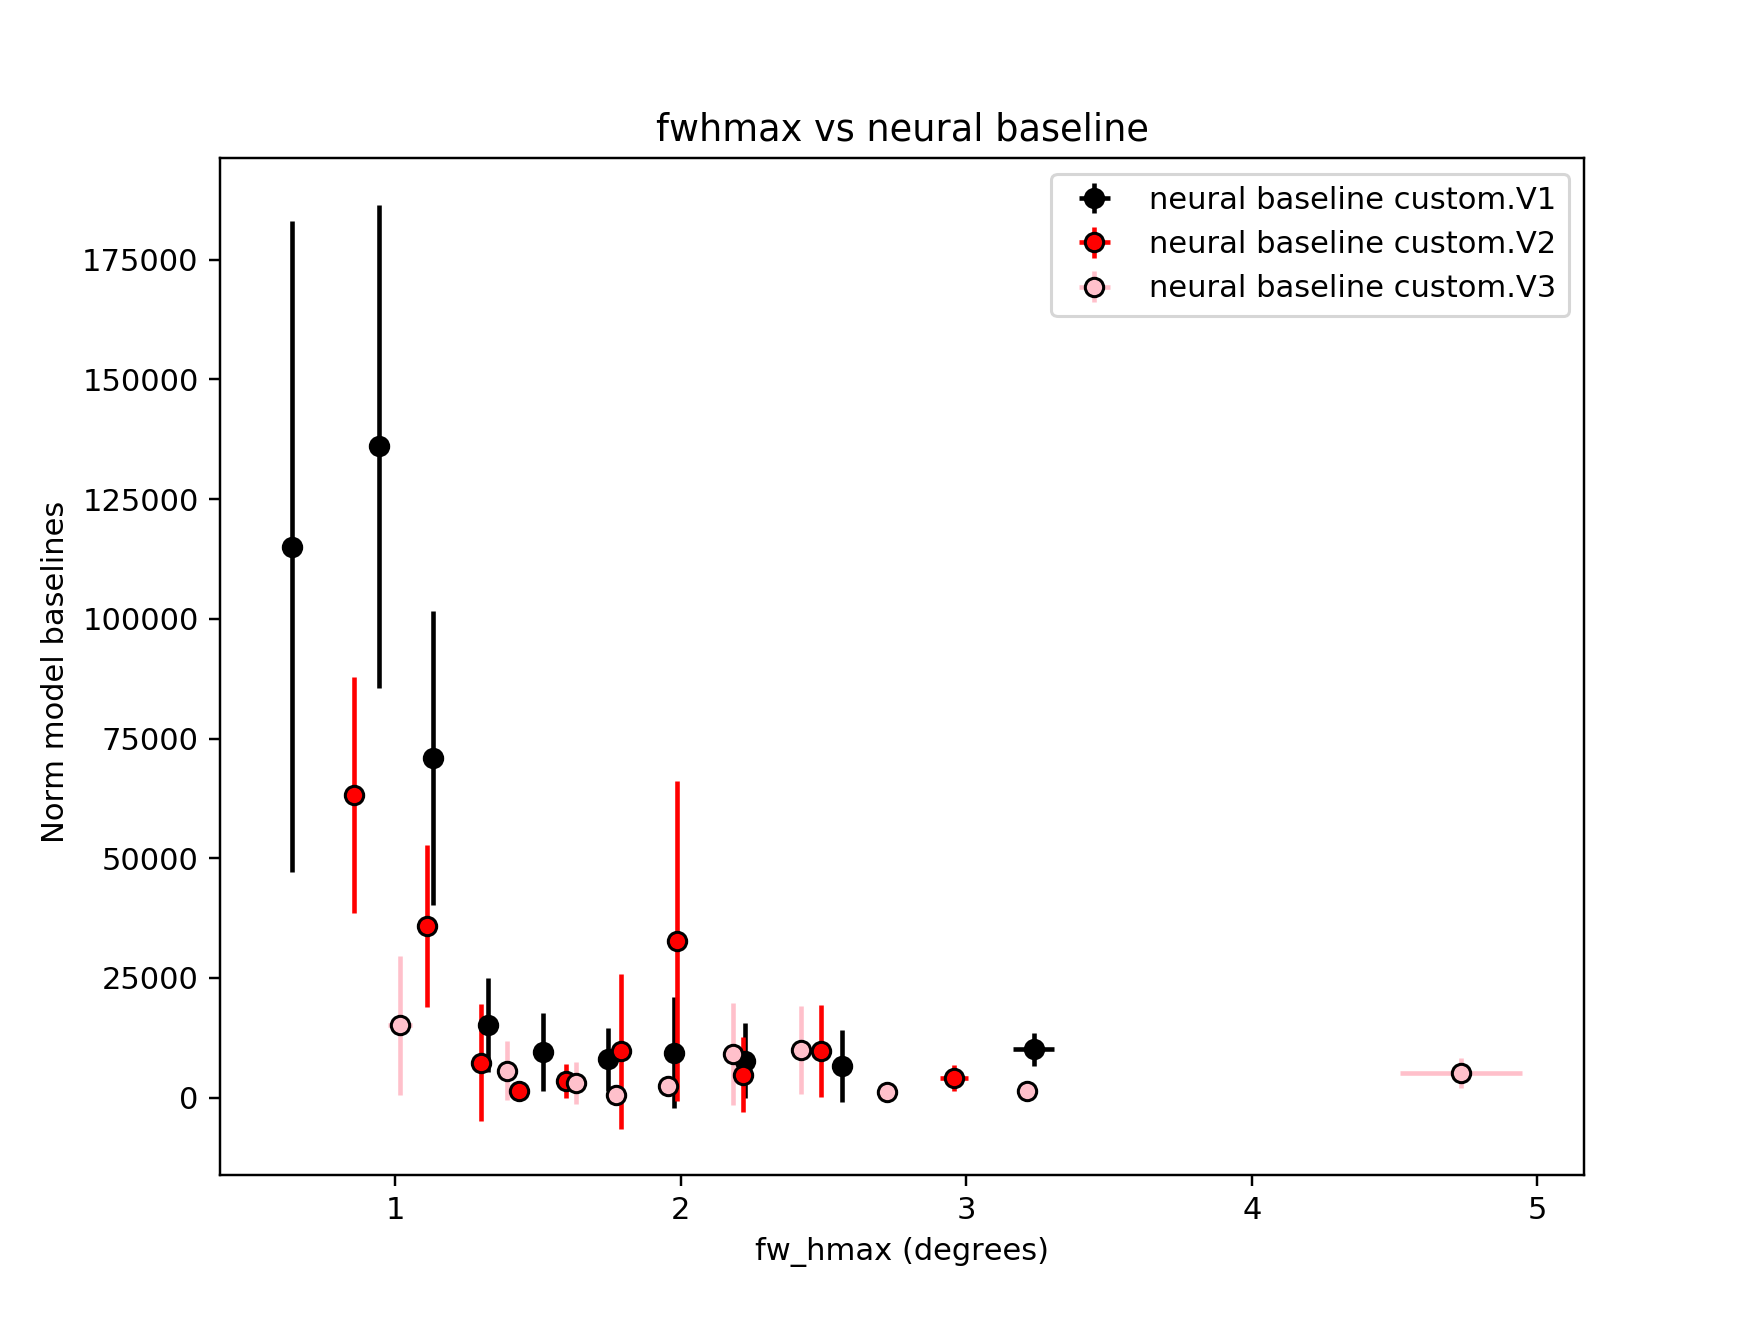

<IPython.core.display.Javascript object>


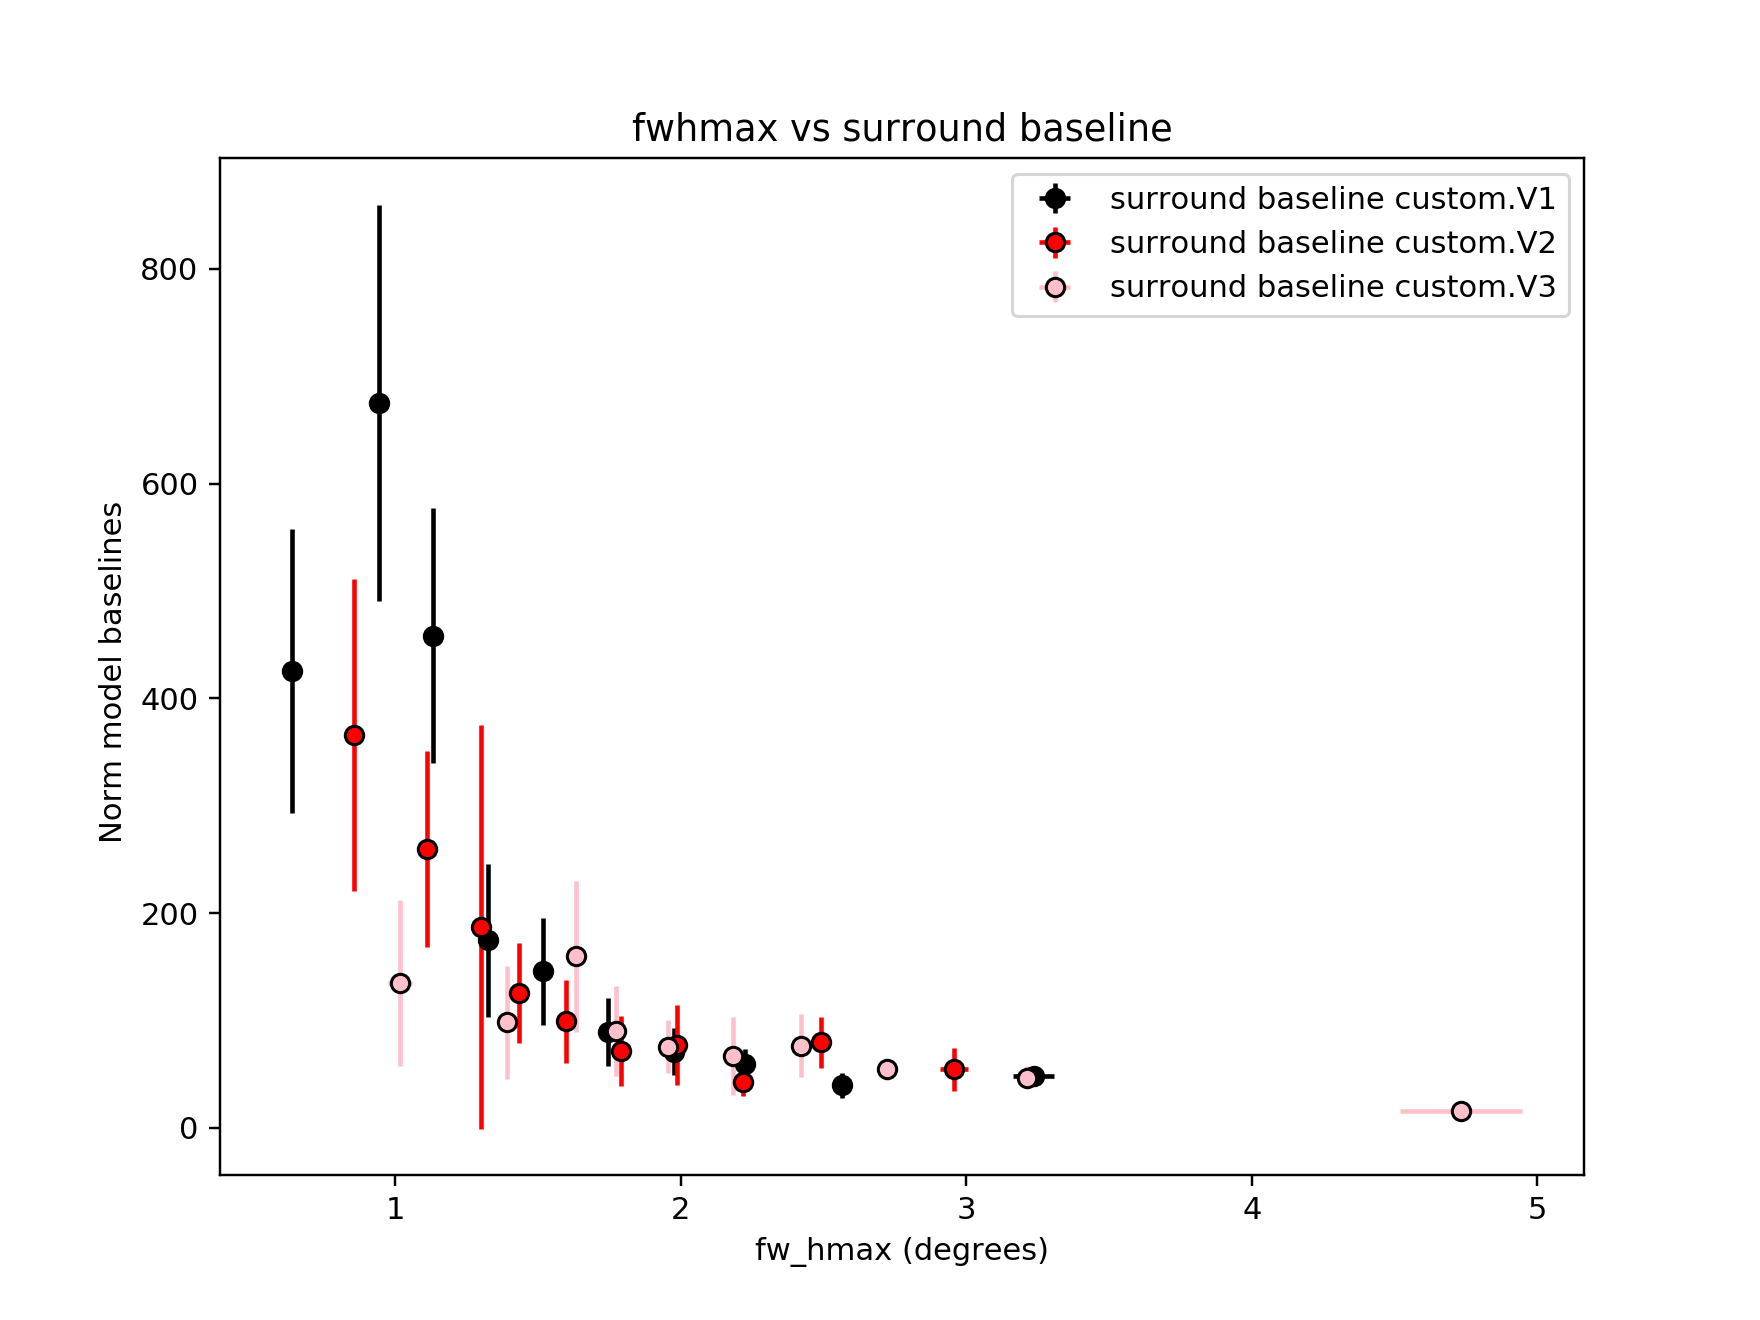

<IPython.core.display.Javascript object>


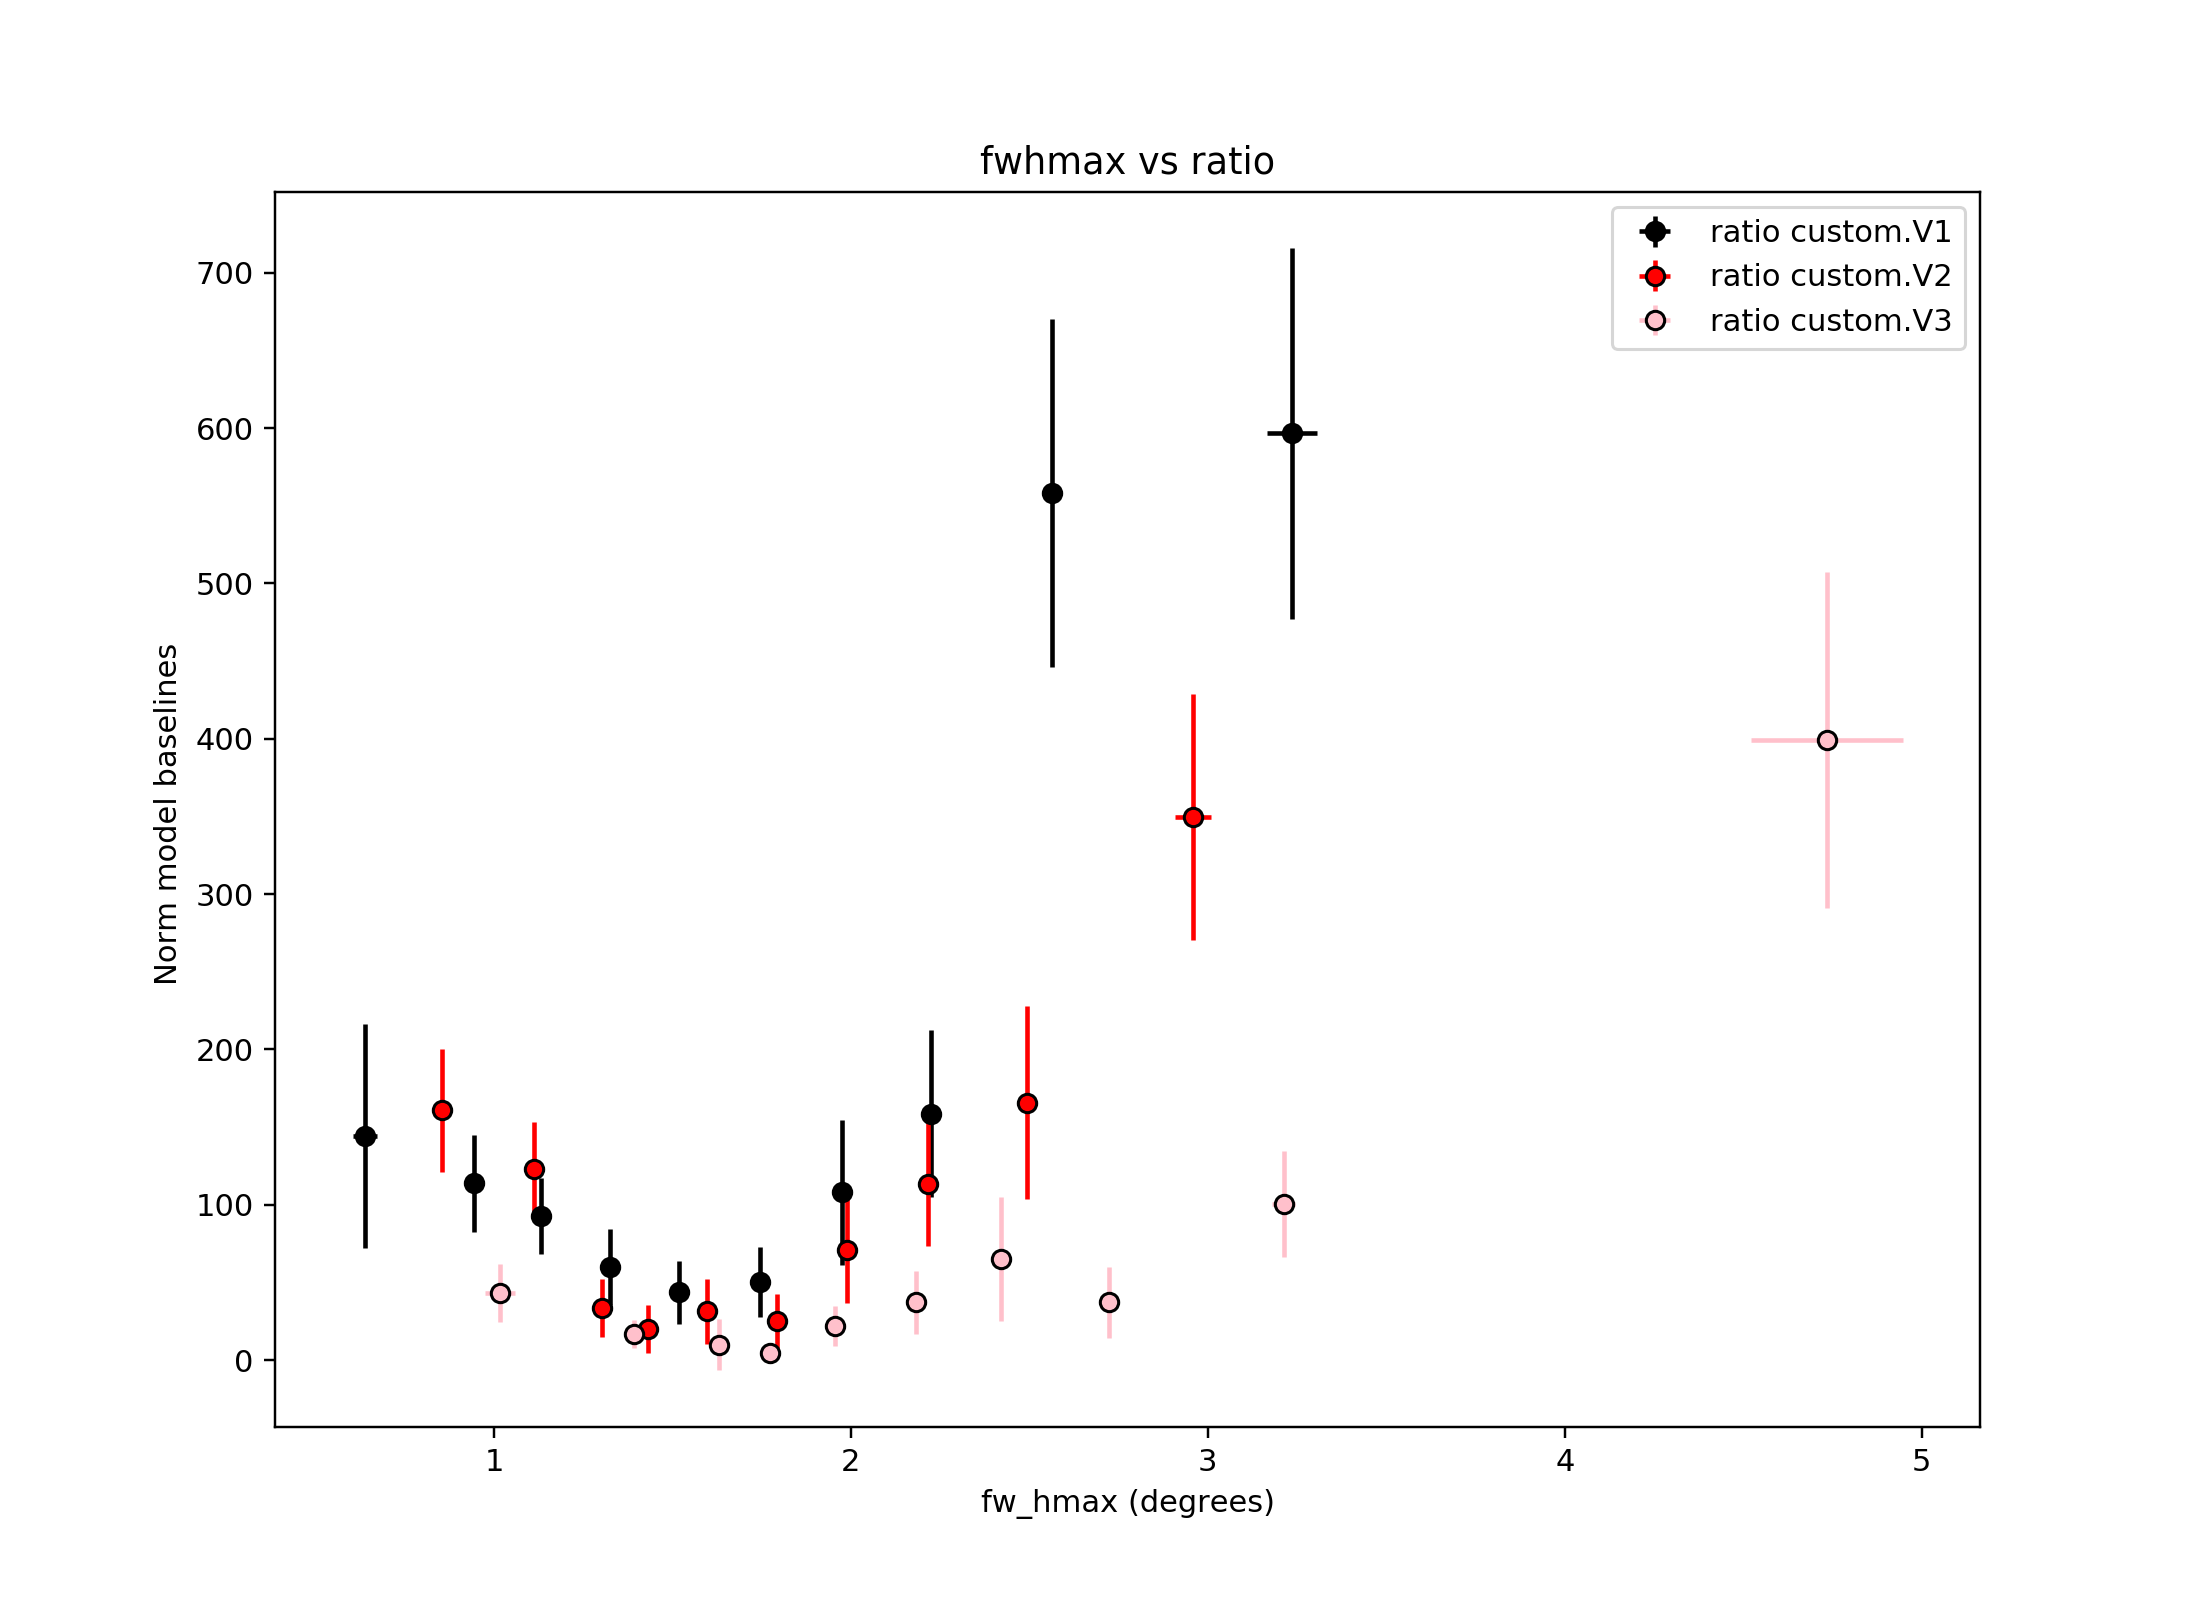

<IPython.core.display.Javascript object>


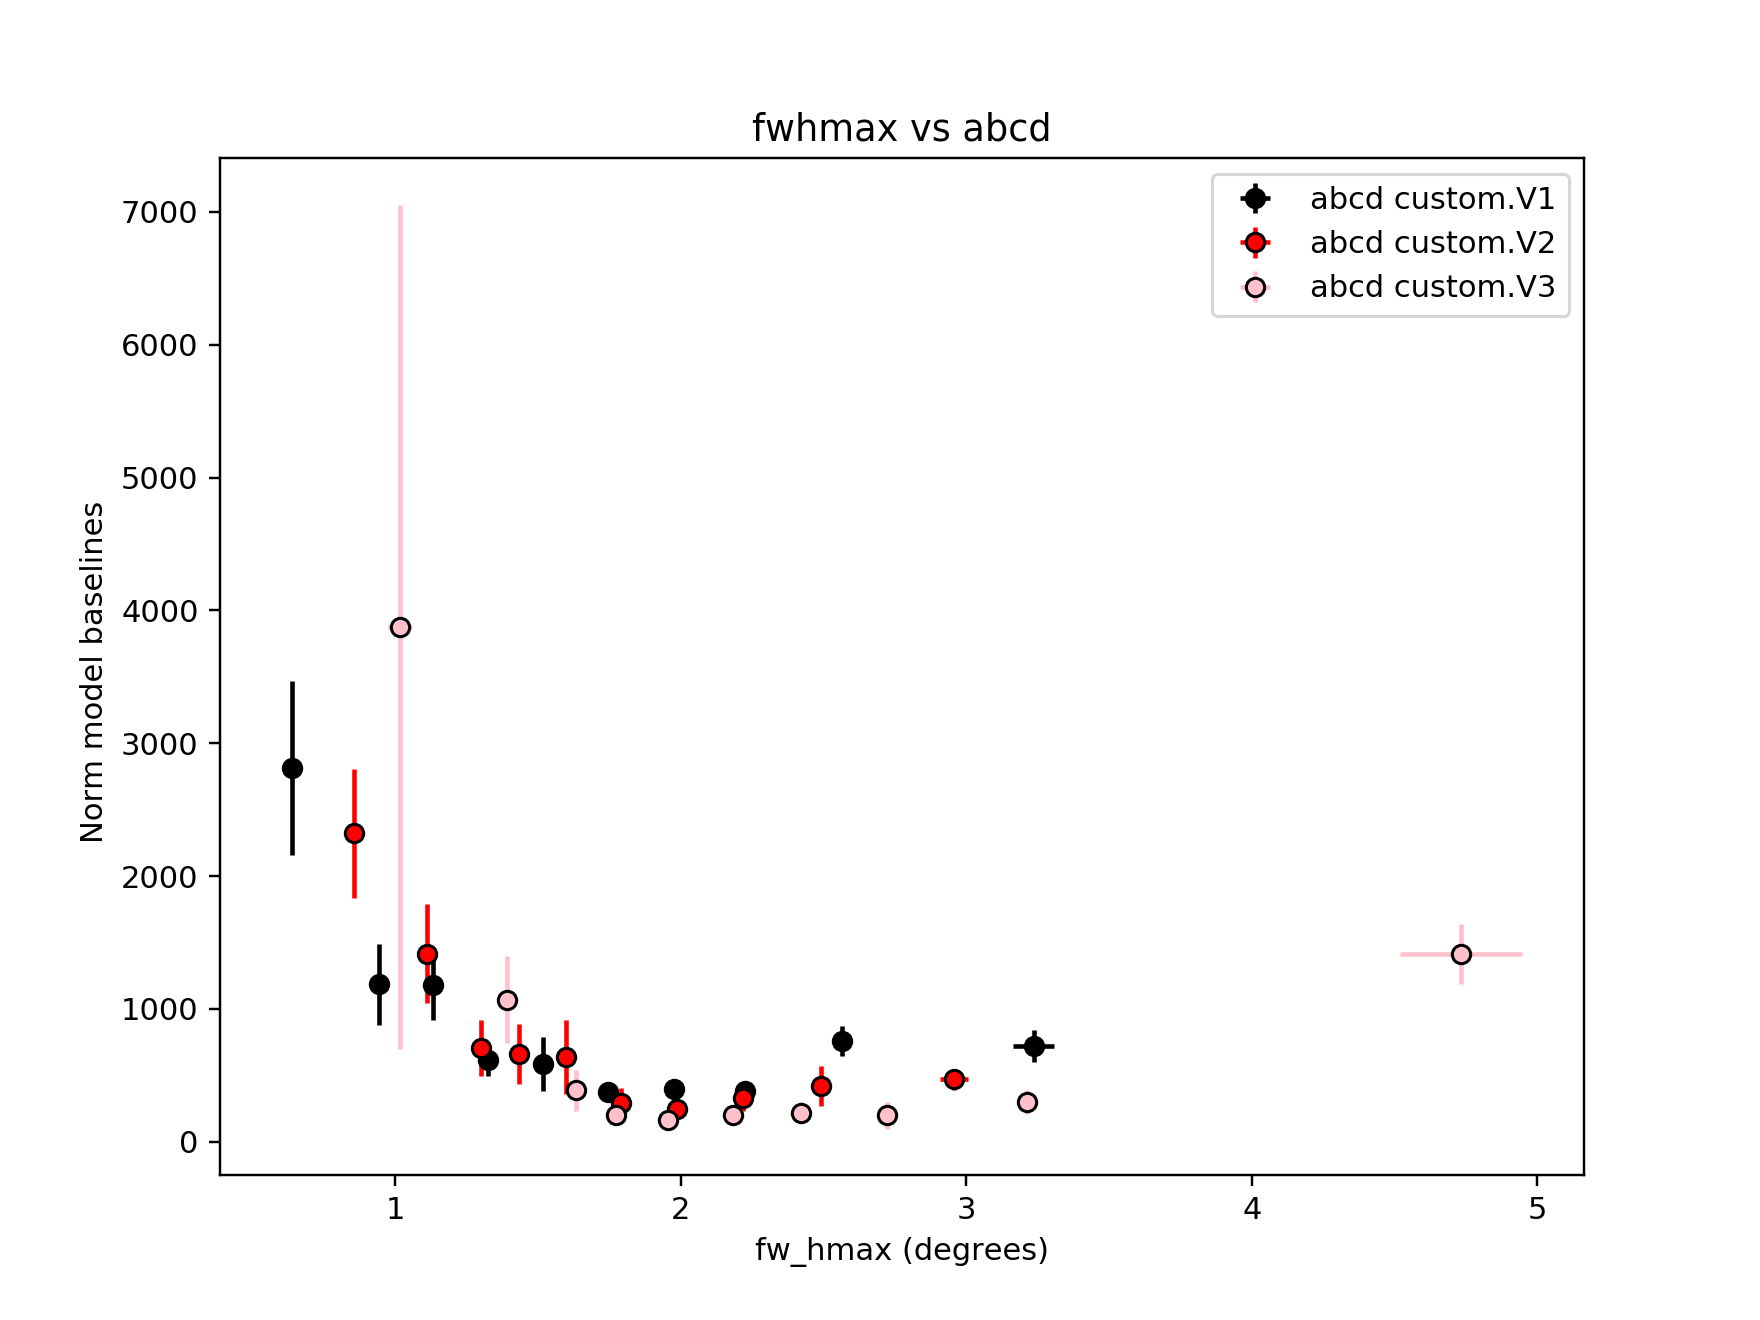

In [297]:
# binned fw_hmax vs other parameters relationships
rsq_thresh = 0.3

colors = {}
colors['custom.V1']= 'black'
colors['custom.V2']= 'red'
colors['custom.V3']= 'pink'

symbol = {}
symbol['neural baseline'] = 'o'
symbol['surround baseline'] = 'o'
symbol['ratio'] = 'o'
symbol['abcd'] = 'o'


baselines_stats = {}
fw_hmax_stats = {}

for roi in colors:#idx_rois:
    
    baselines_stats[roi] = {}
    fw_hmax_stats[roi] = {}
    
    alpha_roi = (roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh) 
    if alpha_roi.sum()>40:    
    
        fw_hmax_sorted = np.argsort(fw_hmax[alpha_roi], axis=0)
        split_fw_hmax_bins = np.array_split(fw_hmax_sorted, 10, axis=0)

        #note: here i indexes different params of same model (above it is same param in different models)
        #therefore fw_hmax_stats is the same for all params
        for i, param in enumerate(['neural baseline', 'surround baseline', 'ratio', 'abcd']):
            pl.figure("fwhmax vs "+param, figsize=(8, 6))
            pl.title("fwhmax vs "+param)
            
            baselines_stats[roi][param]=[]
            fw_hmax_stats[roi][param]=[]

            for fw_hmax_quantile in split_fw_hmax_bins:
                baselines_stats[roi][param].append(weightstats.DescrStatsW(baselines[alpha_roi,i][fw_hmax_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][fw_hmax_quantile[:,3]]))

                fw_hmax_stats[roi][param].append(weightstats.DescrStatsW(fw_hmax[alpha_roi,3][fw_hmax_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][fw_hmax_quantile[:,3]]))




            plot = pl.errorbar([ss.mean for ss in fw_hmax_stats[roi][param]],
               [ss.mean for ss in baselines_stats[roi][param]],
               yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in baselines_stats[roi][param]]).T,
               xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_hmax_stats[roi][param]]).T,
               fmt=symbol[param], mfc=colors[roi], mec='black', label=param+" "+roi, ecolor=colors[roi])
            #pl.yscale('log')
            pl.legend(loc=0)
            pl.xlabel('fw_hmax (degrees)')
            pl.ylabel('Norm model baselines ')
            
            pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_Norm-'+
                   param+'-vs-fw_hmax.png', dpi=200, bbox_inches='tight')
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
    
    

<IPython.core.display.Javascript object>


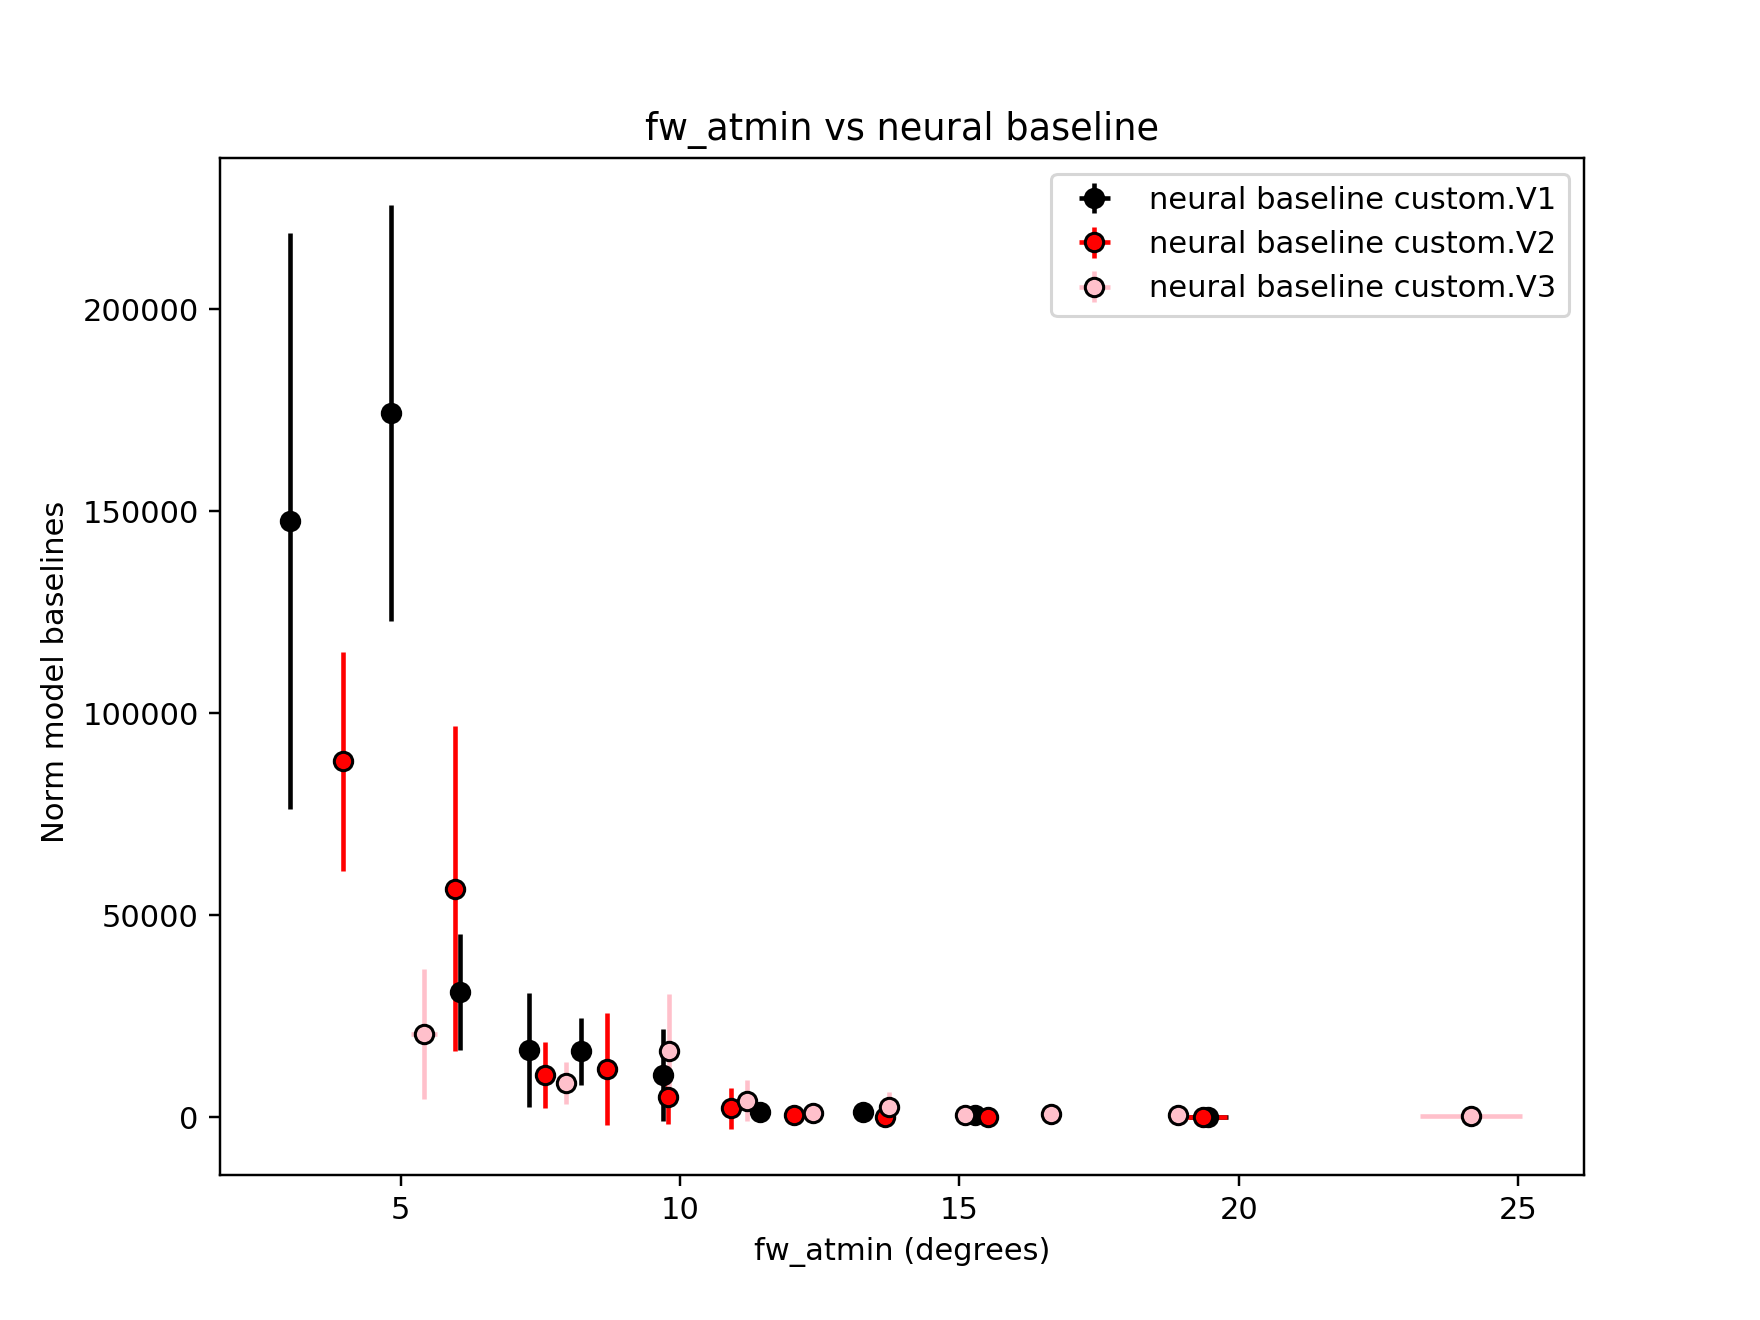

<IPython.core.display.Javascript object>


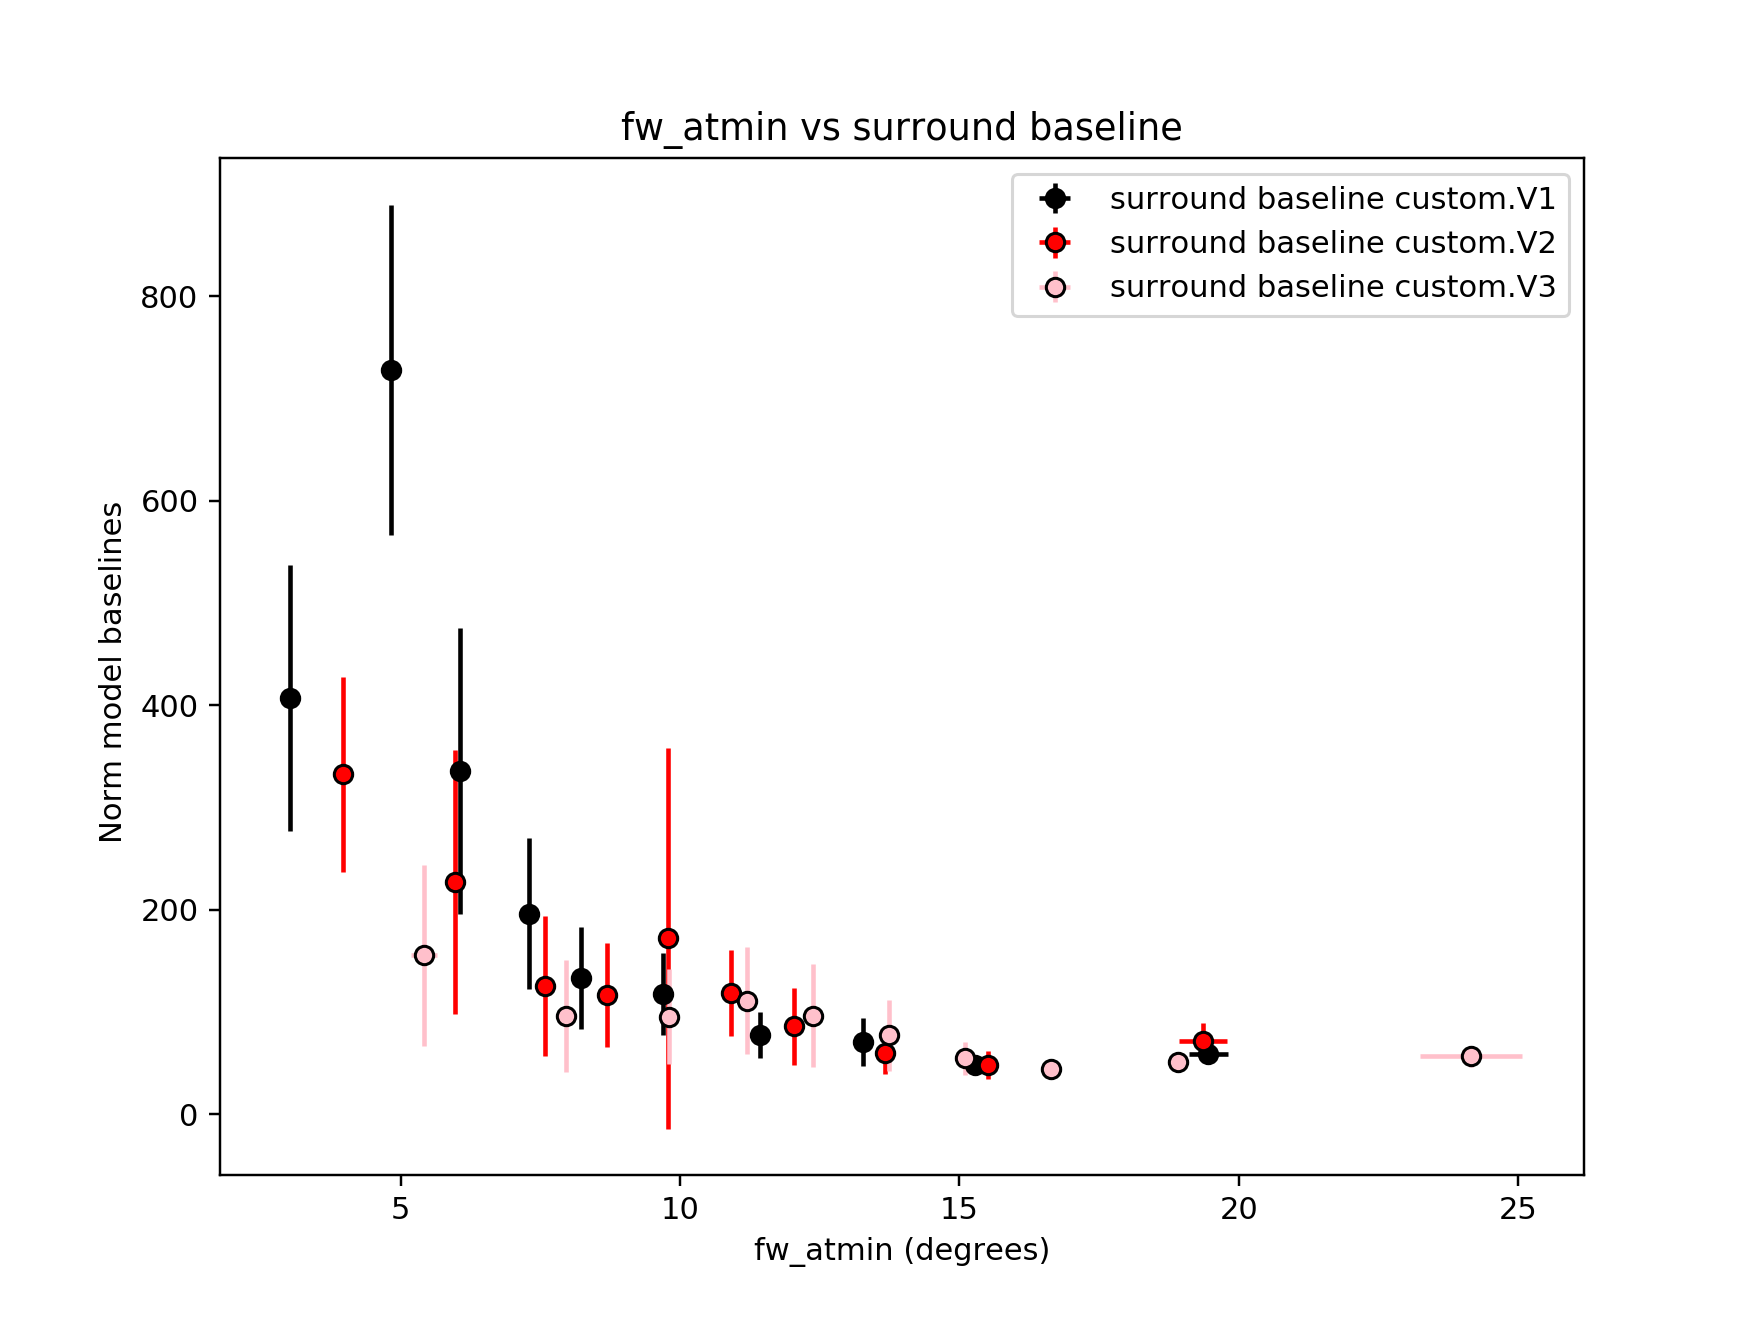

/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


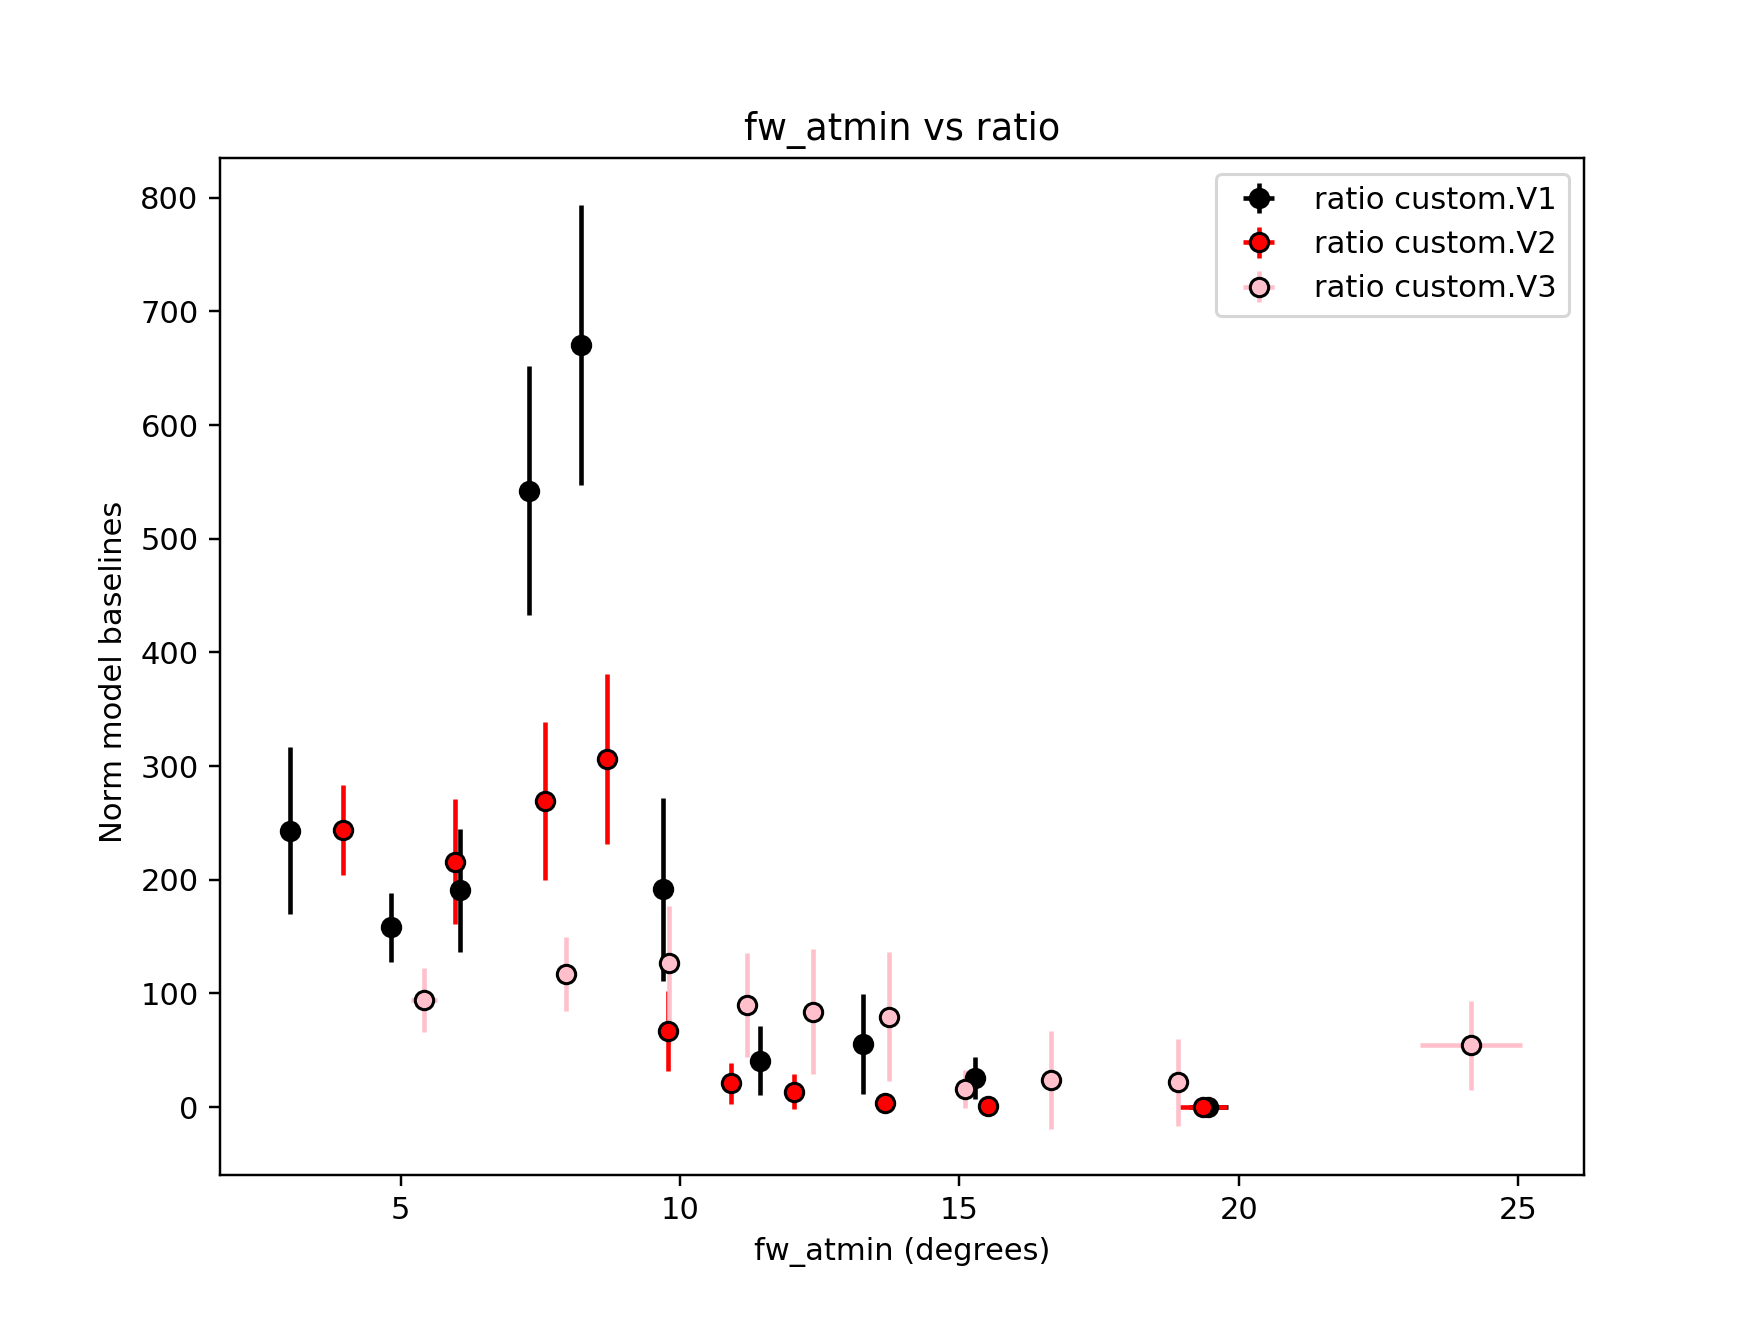

<IPython.core.display.Javascript object>


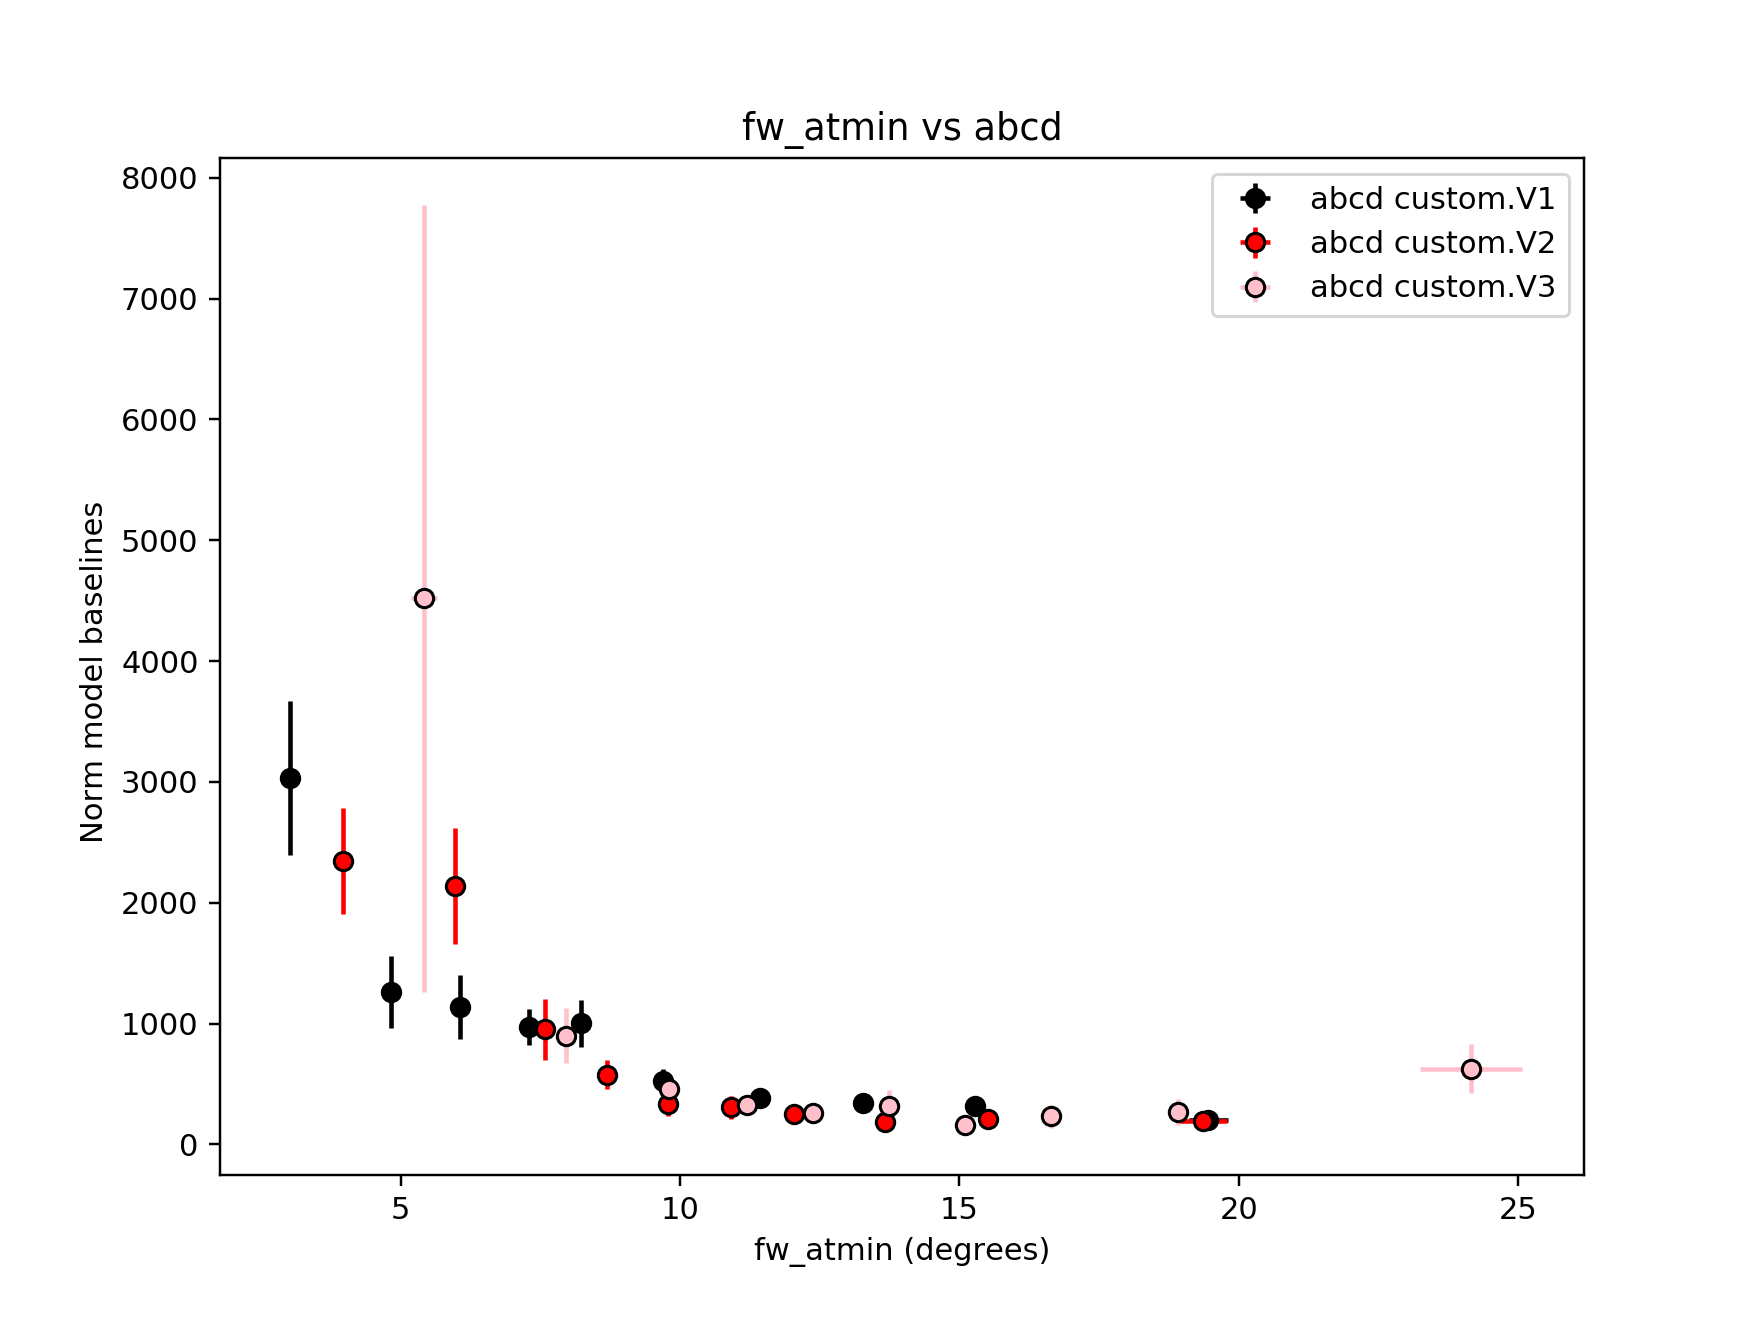

In [298]:
# binned fw_atmin vs other parameters relationships
rsq_thresh = 0.3

colors = {}
colors['custom.V1']= 'black'
colors['custom.V2']= 'red'
colors['custom.V3']= 'pink'

symbol = {}
symbol['neural baseline'] = 'o'
symbol['surround baseline'] = 'o'
symbol['ratio'] = 'o'
symbol['abcd'] = 'o'


baselines_stats = {}
fw_atmin_stats = {}

for roi in colors:#idx_rois:
    
    baselines_stats[roi] = {}
    fw_atmin_stats[roi] = {}
    
    alpha_roi = (roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh) 
    if alpha_roi.sum()>40:    
    
        fw_atmin_sorted = np.argsort(fw_atmin[alpha_roi], axis=0)
        split_fw_atmin_bins = np.array_split(fw_atmin_sorted, 10, axis=0)

        #NOTE: here i indexes different params of same model (above it is same param in different models)
        #therefore fw_atmin_stats is the same for all params
        for i, param in enumerate(['neural baseline', 'surround baseline', 'ratio', 'abcd']):
            pl.figure("fw_atmin vs "+param, figsize=(8, 6))
            pl.title("fw_atmin vs "+param)
            
            baselines_stats[roi][param]=[]
            fw_atmin_stats[roi][param]=[]

            for fw_atmin_quantile in split_fw_atmin_bins:
                baselines_stats[roi][param].append(weightstats.DescrStatsW(baselines[alpha_roi,i][fw_atmin_quantile[:,1]],
                                                                      weights=rsq[alpha_roi,3][fw_atmin_quantile[:,1]]))

                fw_atmin_stats[roi][param].append(weightstats.DescrStatsW(fw_atmin[alpha_roi,1][fw_atmin_quantile[:,1]],
                                                                      weights=rsq[alpha_roi,3][fw_atmin_quantile[:,1]]))




            plot = pl.errorbar([ss.mean for ss in fw_atmin_stats[roi][param]],
               [ss.mean for ss in baselines_stats[roi][param]],
               yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in baselines_stats[roi][param]]).T,
               xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_atmin_stats[roi][param]]).T,
               fmt=symbol[param], mfc=colors[roi], mec='black', label=param+" "+roi, ecolor=colors[roi])
            #pl.yscale('log')
            pl.legend(loc=0)
            pl.xlabel('fw_atmin (degrees)')
            pl.ylabel('Norm model baselines ')
            
            #pl.xlim(4,15)
            
            pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_Norm-'+
                   param+'-vs-fw_atmin.png', dpi=200, bbox_inches='tight')
            
            
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
    
    

<IPython.core.display.Javascript object>


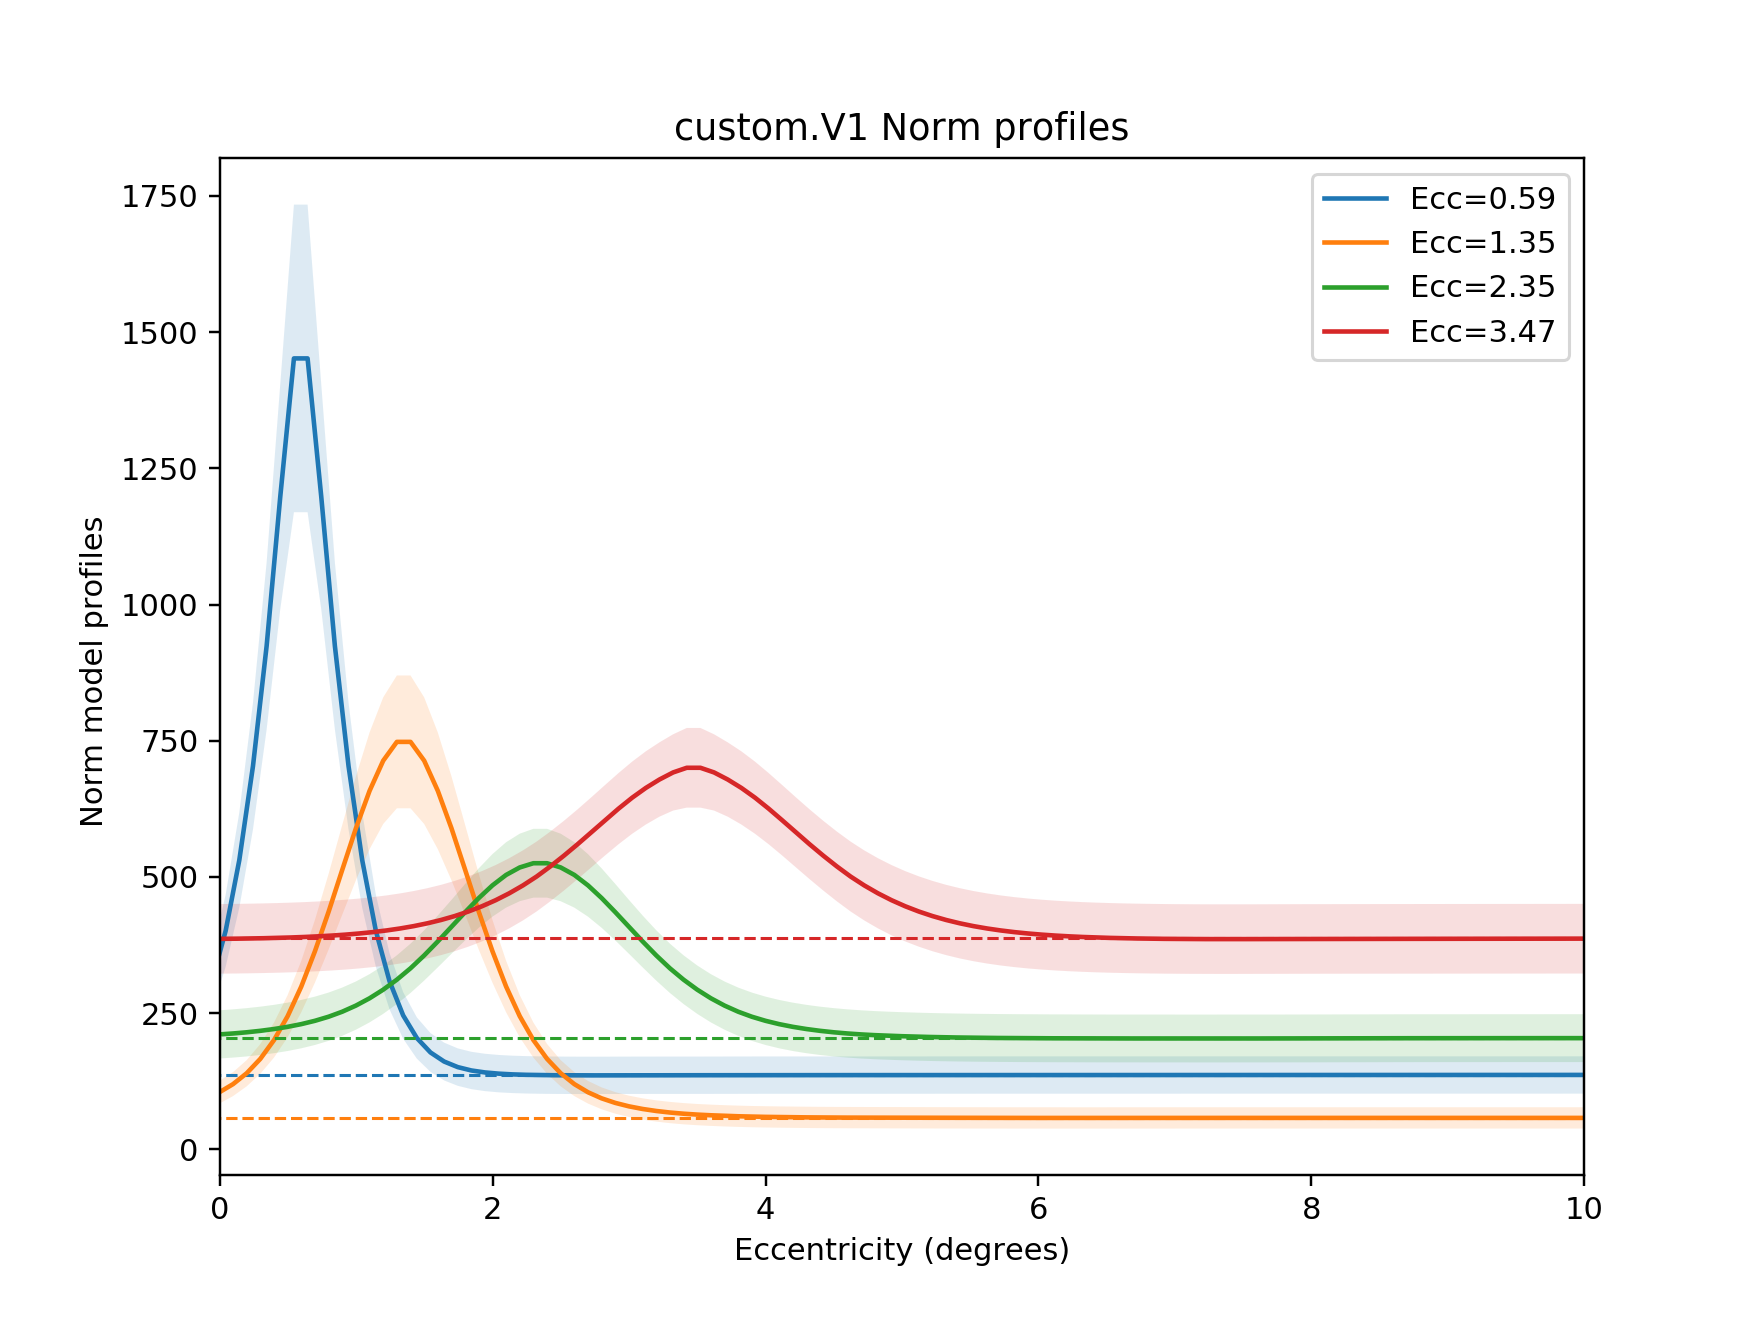

<IPython.core.display.Javascript object>


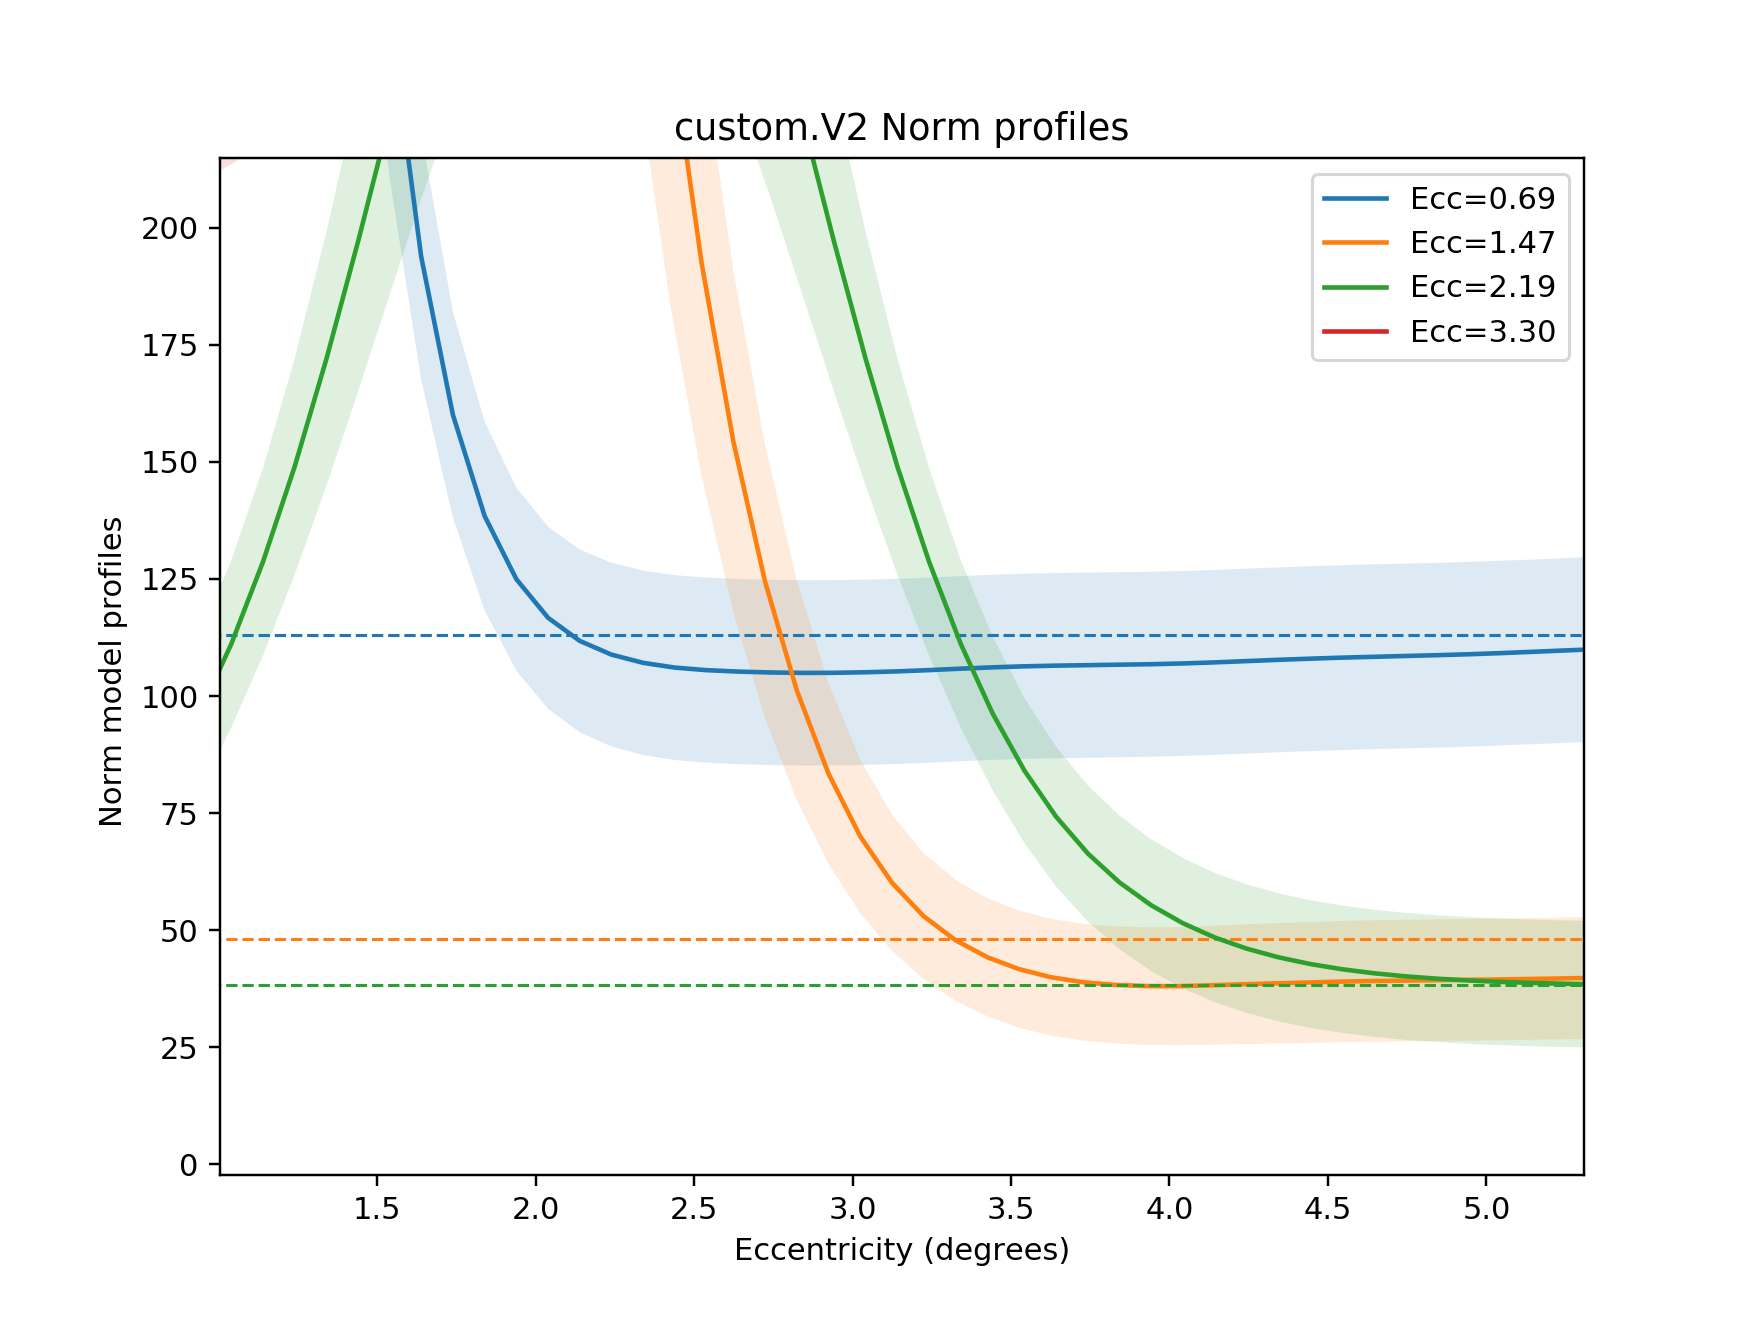

<IPython.core.display.Javascript object>


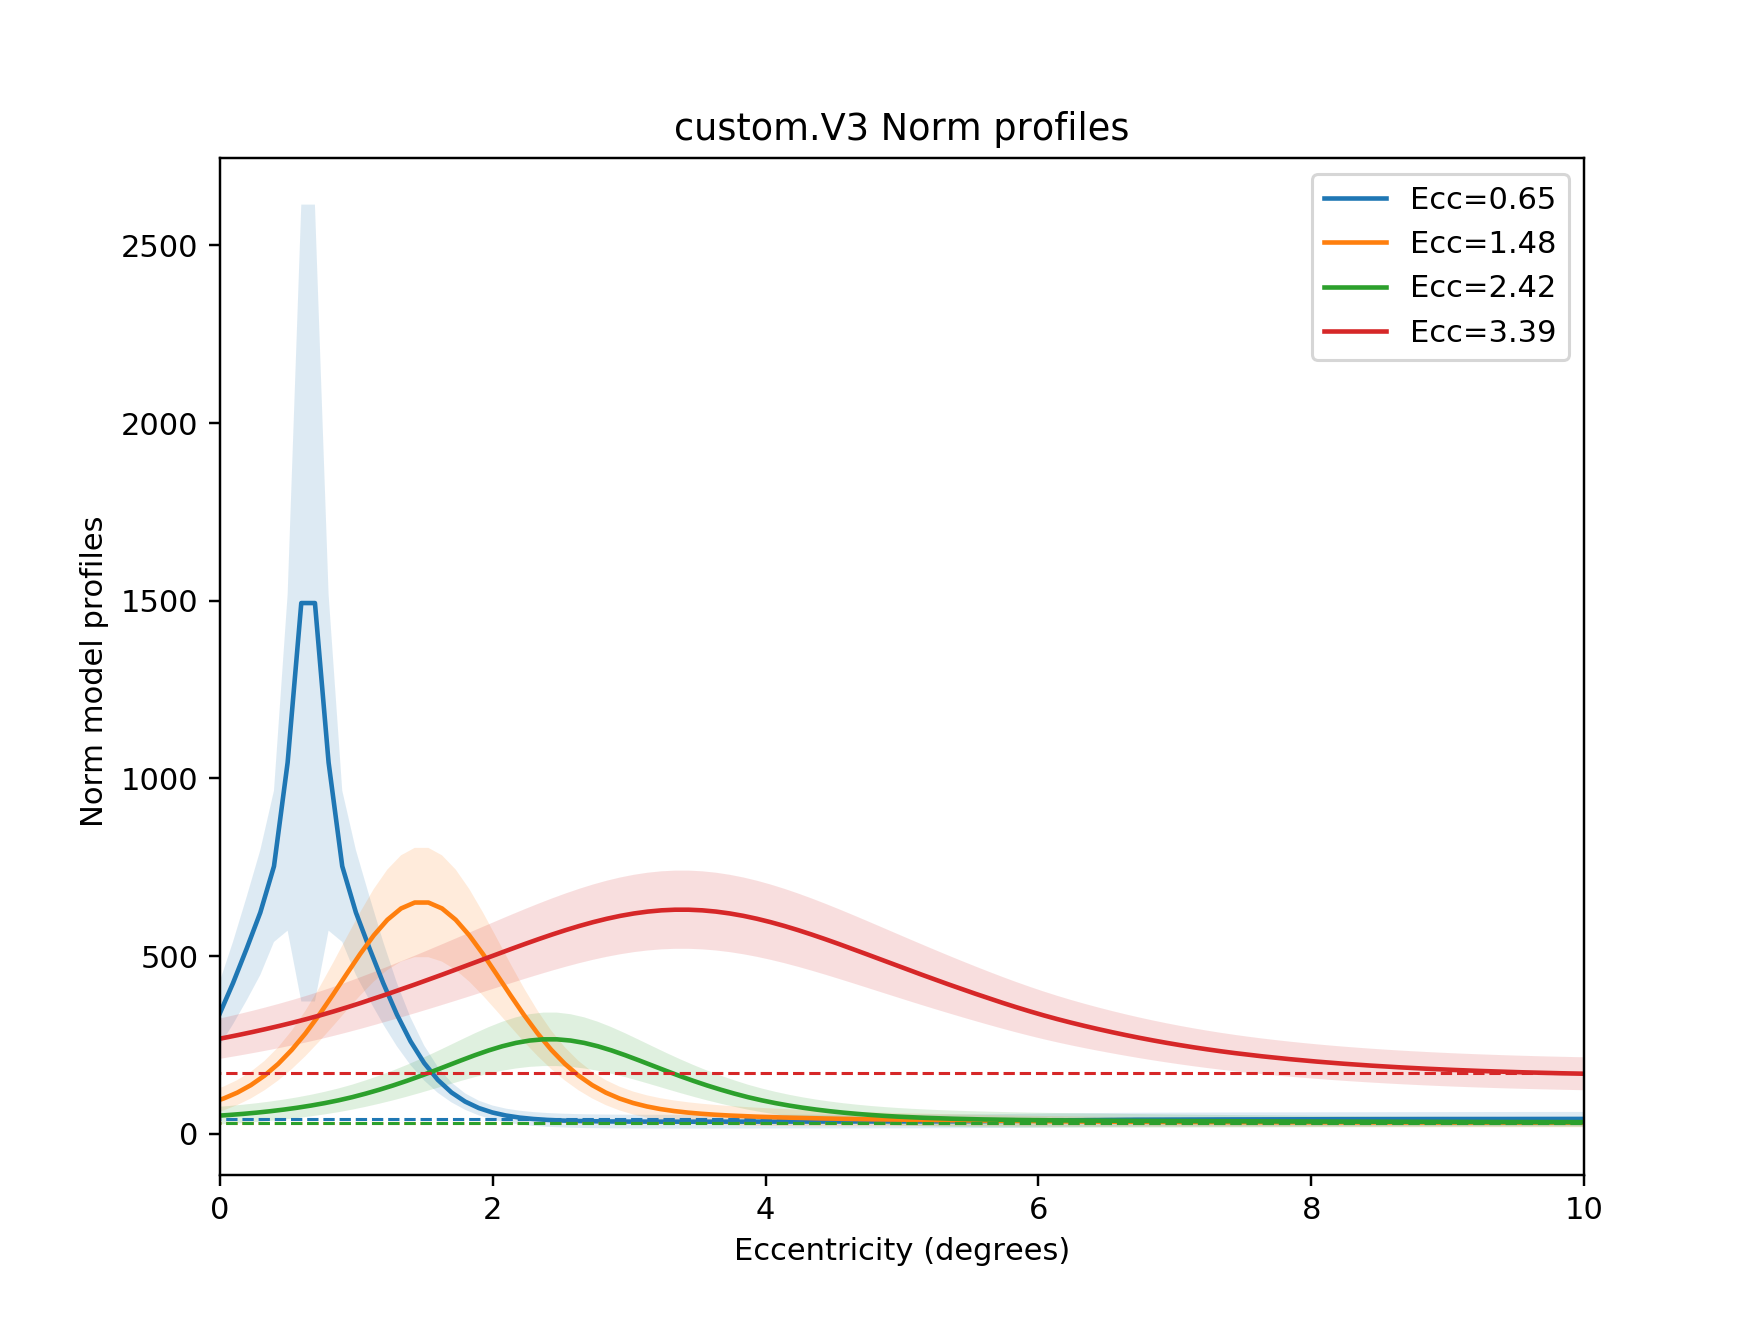

In [91]:
# binned eccentricity vs other parameters relationships
rsq_thresh = 0.3

ecc_stats = {}
profile_stats = {}


for roi in ['custom.V1', 'custom.V2', 'custom.V3']:#idx_rois:
    
    ecc_stats[roi] = {}
    profile_stats[roi] = {}
    
    alpha_roi = (roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh)
    if alpha_roi.sum()>40:    
        pl.figure(roi, figsize=(8, 6))
        pl.title(roi+' Norm profiles')
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        #mask_ecc_sorted=[]
        #for elem in ecc_sorted[:,3]:
        #    mask_ecc_sorted.append(np.sum(nonzerovar_mask[:elem]))
        #mask_ecc_sorted=np.array(mask_ecc_sorted)    
        split_ecc_bins = np.array_split(ecc_sorted, 4, axis=0)

        ecc_stats[roi] = []
        profile_stats[roi] = []

        for ecc_quantile in split_ecc_bins:

            #hacky as per usual: 3 is the norm model index in ecc and rsq dataset
            ecc_stats[roi].append(weightstats.DescrStatsW(ecc[alpha_roi,3][ecc_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))
            
            # different ways of calculating the profile VS eccentricity relationship
            #### weighted mean of parameters in each ecc bin
            #norm_bin_mean = weightstats.DescrStatsW(norm_params_full[alpha_roi,:][ecc_quantile[:,3]],
            #                                        weights=rsq[alpha_roi,3][ecc_quantile[:,3]]).mean   
            #bin_profile = fwhmax_fwatmin('Norm', norm_bin_mean, normalize_RFs, return_profiles=True)[1]
            #plot = pl.plot(np.linspace(-50,50,1000)+ecc_stats[roi][-1].mean, bin_profile,
            #              label=f'Ecc={ecc_stats[roi][-1].mean:.2f}')
            


            #### weighted mean of profiles in each eccentricity bin           
            profile_stats[roi].append(weightstats.DescrStatsW(norm_profiles[:,alpha_roi][:,ecc_quantile[:,3]].T,
                                                    weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))
            
            plot = pl.plot(np.linspace(-50,50,1000)+ecc_stats[roi][-1].mean, profile_stats[roi][-1].mean,
                          label=f'Ecc={ecc_stats[roi][-1].mean:.2f}')
            
            pl.fill_between(np.linspace(-50,50,1000)+ecc_stats[roi][-1].mean, profile_stats[roi][-1].zconfint_mean(alpha=0.05)[0],
                           profile_stats[roi][-1].zconfint_mean(alpha=0.05)[1], facecolor=plot[0].get_color(),
                           alpha=0.15)
            
            pl.plot(np.linspace(-50,50,1000), np.ones(1000)*plot[0].get_ydata()[-1], color=plot[0].get_color(),
                   linestyle='--', linewidth=1)

        pl.legend(loc=0)
        pl.xlim((0,10))
        pl.xlabel('Eccentricity (degrees)')
        pl.ylabel('Norm model profiles ')
            
        #pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
        #           roi+'_Norm-profiles.png', dpi=200, bbox_inches='tight')
            
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
    
    

In [11]:

pl.close('all')

<IPython.core.display.Javascript object>


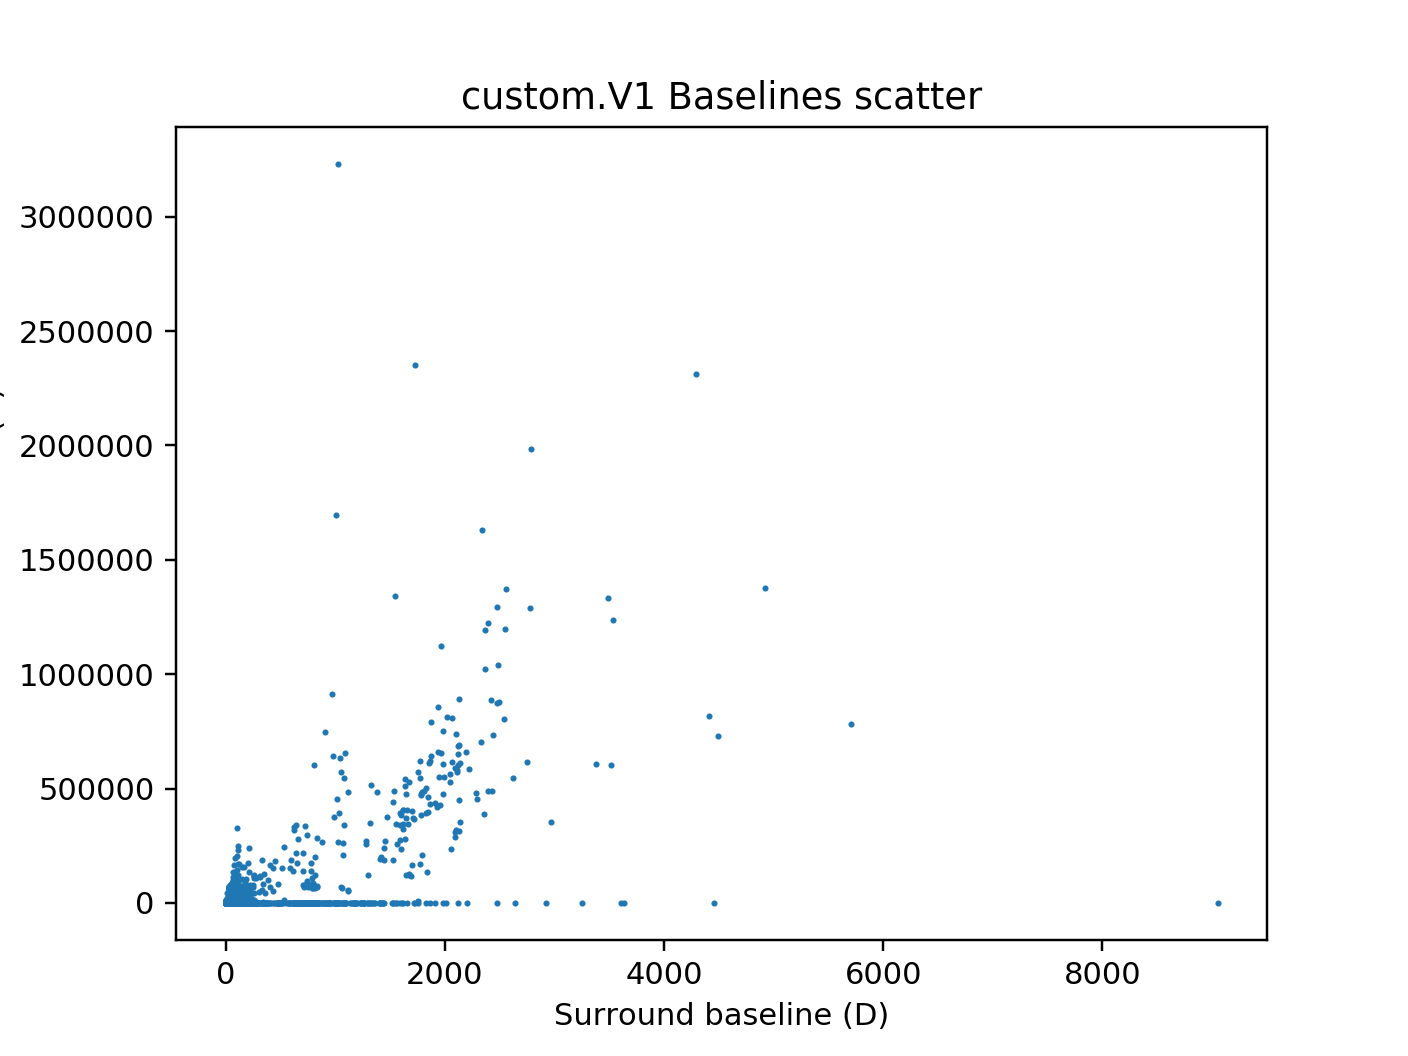

<IPython.core.display.Javascript object>


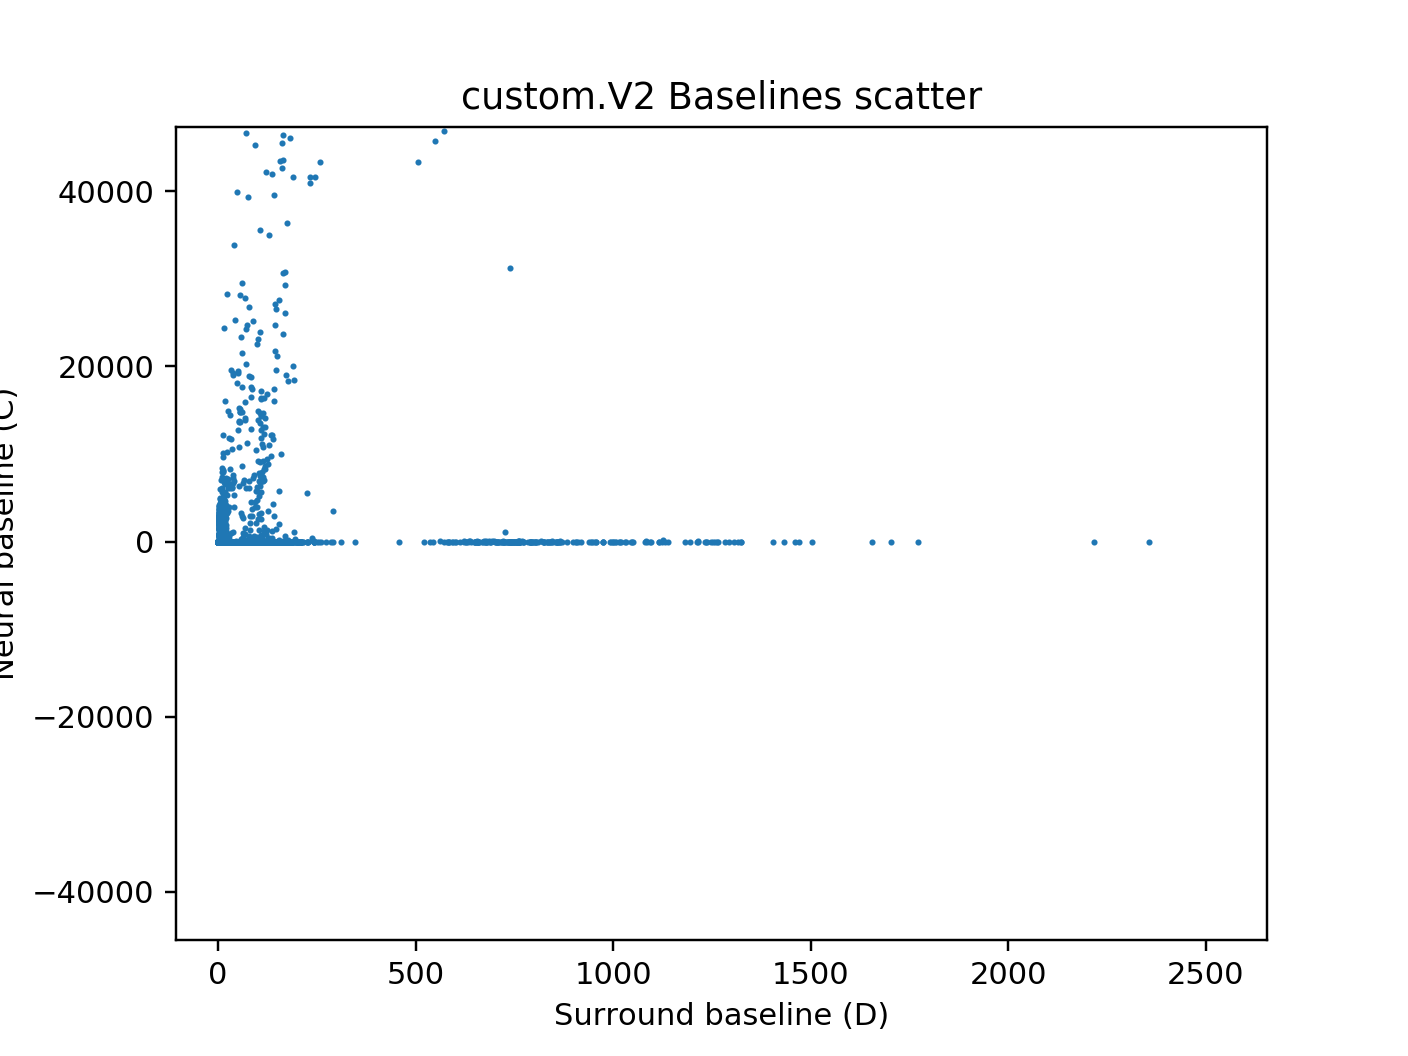

<IPython.core.display.Javascript object>


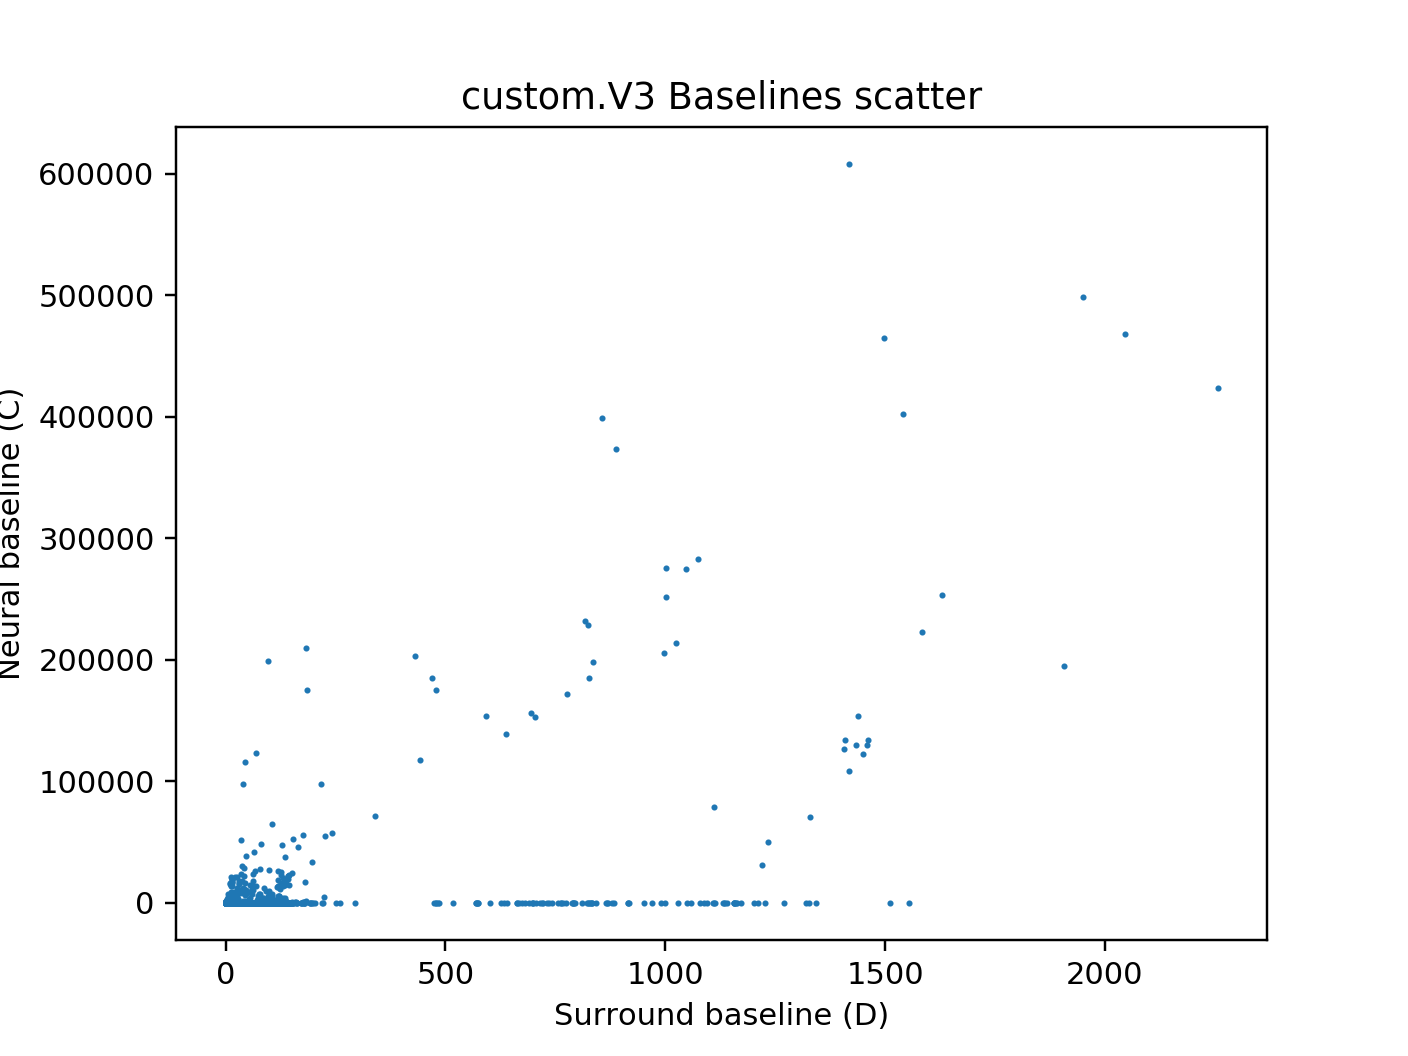

In [108]:
for roi in ['custom.V1', 'custom.V2', 'custom.V3']:
    alpha_roi = roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh
    
    pl.figure()
    pl.title(roi+" Baselines scatter")
    pl.ylabel("Neural baseline (C)")
    pl.xlabel("Surround baseline (D)")
    pl.scatter(baselines[alpha_roi,1], baselines[alpha_roi,0], s=1)

<IPython.core.display.Javascript object>


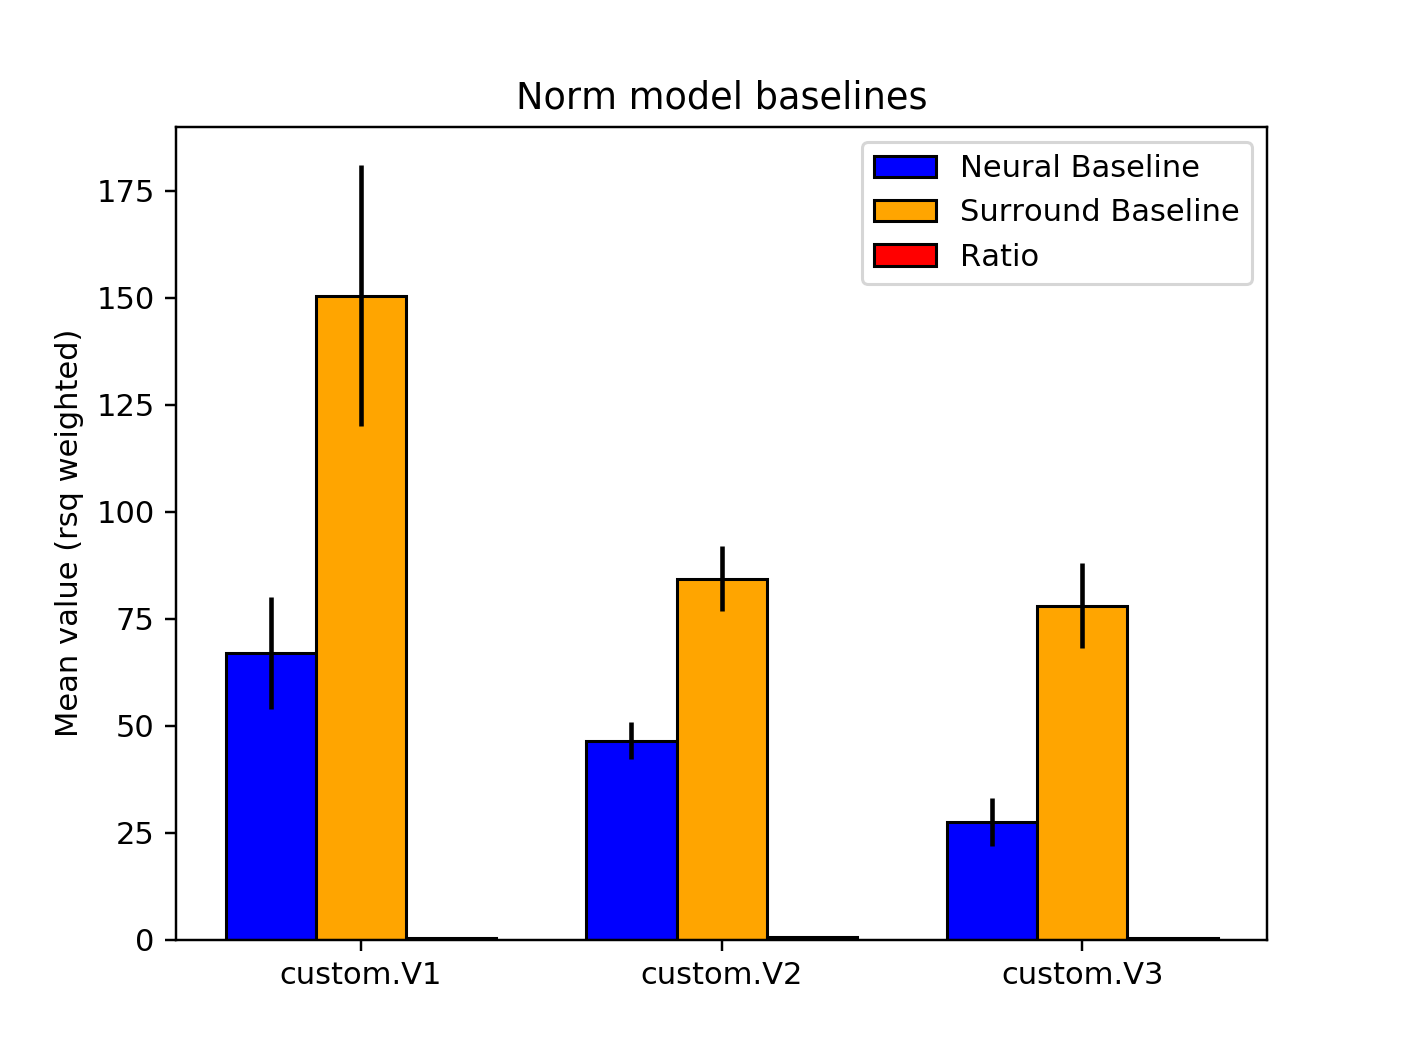

In [212]:
#plotting baseline average values per roi

pl.figure()
pl.title("Norm model baselines")
pl.ylabel("Mean value (rsq weighted)")

bar_positions = np.array([0,0.1,0.2])
x_ticks = []
x_labels = []

for roi in ['custom.V1', 'custom.V2', 'custom.V3']:
    alpha_roi = roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh
    if alpha_roi.sum()>40:
        
        height_1 = weightstats.DescrStatsW(baselines[alpha_roi,0],
                                                    weights=rsq[alpha_roi,3])
        height_2 = weightstats.DescrStatsW(baselines[alpha_roi,1],
                                                    weights=rsq[alpha_roi,3])
        height_3 = weightstats.DescrStatsW(baselines[alpha_roi,2],
                                                    weights=rsq[alpha_roi,3])
        
        p1=pl.bar(bar_positions, height=[height_1.mean, height_2.mean, height_3.mean], width=0.1,
                  yerr=np.array([np.abs(height_1.zconfint_mean(alpha=0.05)-height_1.mean),
                                np.abs(height_2.zconfint_mean(alpha=0.05)-height_2.mean),
                                np.abs(height_3.zconfint_mean(alpha=0.05)-height_3.mean)]).T, color=
                  ['blue','orange', 'red'], edgecolor='black')
        x_ticks.append(bar_positions.mean())
        x_labels.append(roi)
        bar_positions+=0.4
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
            
pl.xticks(x_ticks, x_labels)


pl.legend((p1[0],p1[1], p1[2]),('Neural Baseline','Surround Baseline', 'Ratio'),loc=0)


<IPython.core.display.Javascript object>


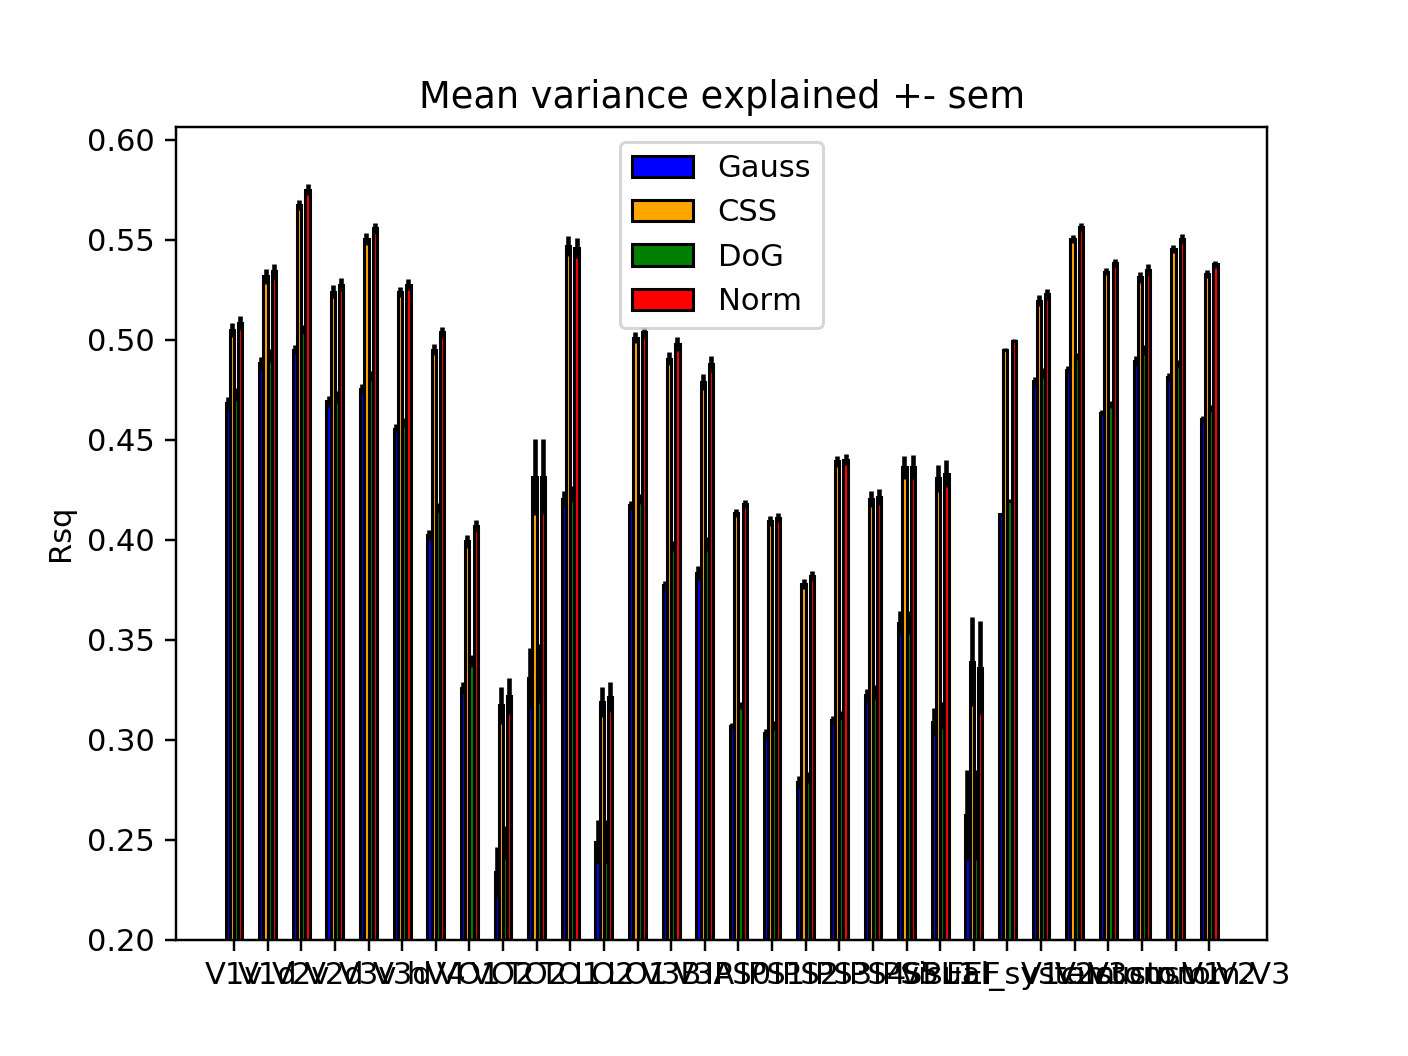

PHC1 has no vertices/voxels above specified rsq threshold
PHC2 has no vertices/voxels above specified rsq threshold


In [213]:
#plotting rsq per roi

pl.figure()
pl.title("Mean variance explained +- sem")
pl.ylabel("Rsq")

bar_positions = np.array([0,0.1,0.2,0.3])
x_ticks = []
x_labels = []

for roi in idx_rois:
    alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    if alpha_roi.sum()>1:        
        p1=pl.bar(bar_positions, height=np.mean(rsq[alpha_roi],axis=0), width=0.1,
                  yerr=sem(rsq[alpha_roi],axis=0), color=
                  ['blue','orange','green','red'],edgecolor='black')
        x_ticks.append(bar_positions.mean())
        x_labels.append(roi)
        bar_positions+=0.8
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
            
pl.xticks(x_ticks, x_labels)

pl.ylim(bottom=0.2)
pl.legend((p1[0],p1[1],p1[2],p1[3]),('Gauss','CSS','DoG','Norm'),loc=0)


In [214]:

for roi in idx_rois:
    print(roi)
    try:
        print(ks_2samp(rsq[roi_mask(idx_rois[roi],alpha)>rsq_thresh,1],rsq[roi_mask(idx_rois[roi],alpha)>rsq_thresh,3]))
    except:
        print(roi+" has no vertices/voxels above specified rsq threshold")


V1v
Ks_2sampResult(statistic=0.021524663677130046, pvalue=0.9585739196639628)
V1d
Ks_2sampResult(statistic=0.01307639366827254, pvalue=0.9996579659475293)
V2v
Ks_2sampResult(statistic=0.0425531914893617, pvalue=0.036619995719588676)
V2d
Ks_2sampResult(statistic=0.01818181818181818, pvalue=0.9721928684454606)
V3v
Ks_2sampResult(statistic=0.031781226903178125, pvalue=0.5016586829145746)
V3d
Ks_2sampResult(statistic=0.019653720168460457, pvalue=0.8037474871730668)
hV4
Ks_2sampResult(statistic=0.04057142857142857, pvalue=0.11218943760813471)
VO1
Ks_2sampResult(statistic=0.08707865168539326, pvalue=0.13449842443821505)
VO2
Ks_2sampResult(statistic=0.5, pvalue=0.7714285714285716)
PHC1
PHC1 has no vertices/voxels above specified rsq threshold
PHC2
PHC2 has no vertices/voxels above specified rsq threshold
TO2
Ks_2sampResult(statistic=0.08695652173913043, pvalue=0.9999989811527811)
TO1
Ks_2sampResult(statistic=0.027777777777777776, pvalue=0.9998945640423377)
LO2
Ks_2sampResult(statistic=0.25, p

In [ ]:
#the following cells are in case we want to quickly look at some specific model/data timecourse

In [111]:
analysis_settings = '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/analysis_settings_cartesius.yml'

local_files = '/Users/marcoaqil/prfpy_norm/analysis_settings.yml'

with open(analysis_settings) as f:
    analysis_info = yaml.safe_load(f)

with open(local_files) as f:
    analysis_info_local = yaml.safe_load(f)

    
screenshot_paths = analysis_info_local["screenshot_paths"]

n_pix = analysis_info["n_pix"]
discard_volumes = analysis_info["discard_volumes"]
#screenshot_paths = analysis_info["screenshot_paths"]
screen_size_cm = analysis_info["screen_size_cm"]
screen_distance_cm = analysis_info["screen_distance_cm"]
TR = analysis_info["TR"]
task_names = analysis_info["task_names"]
data_path = analysis_info["data_path"]
fitting_space = analysis_info["fitting_space"]
window_length = analysis_info["window_length"]
n_jobs = analysis_info["n_jobs"]
hrf = analysis_info["hrf"]
gradient_method = analysis_info["gradient_method"].lower()
verbose = analysis_info["verbose"]
rsq_threshold = analysis_info["rsq_threshold"]
models_to_fit = analysis_info["models_to_fit"]
n_batches = analysis_info["n_batches"]
fit_hrf = analysis_info["fit_hrf"]

dm_edges_clipping = analysis_info["dm_edges_clipping"]
baseline_volumes_begin_end = analysis_info["baseline_volumes_begin_end"]
min_percent_var = analysis_info["min_percent_var"]
pos_prfs_only = analysis_info["pos_prfs_only"]

normalize_RFs = normalize_RFs

In [112]:
#create stim
task_lengths, prf_stim, late_iso_dict = create_full_stim(screenshot_paths,
                n_pix,
                discard_volumes,
                baseline_volumes_begin_end,                                         
                dm_edges_clipping,
                screen_size_cm,
                screen_distance_cm,
                TR,
                task_names)

Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed


In [113]:
#initialize models 
gg = Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                          task_lengths=task_lengths,
                          normalize_RFs=normalize_RFs)

gg_css = CSS_Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                          task_lengths=task_lengths,
                          normalize_RFs=normalize_RFs)

gg_norm = Norm_Iso2DGaussianGridder(stimulus=prf_stim,
                                    hrf=hrf,
                                    filter_predictions=True,
                                    window_length=window_length,
                                    task_lengths=task_lengths,
                                    normalize_RFs=normalize_RFs)

gg_dog = DoG_Iso2DGaussianGridder(stimulus=prf_stim,
                                  hrf=hrf,
                                  filter_predictions=True,
                                  window_length=window_length,
                                  task_lengths=task_lengths,
                                  normalize_RFs=normalize_RFs)

<IPython.core.display.Javascript object>


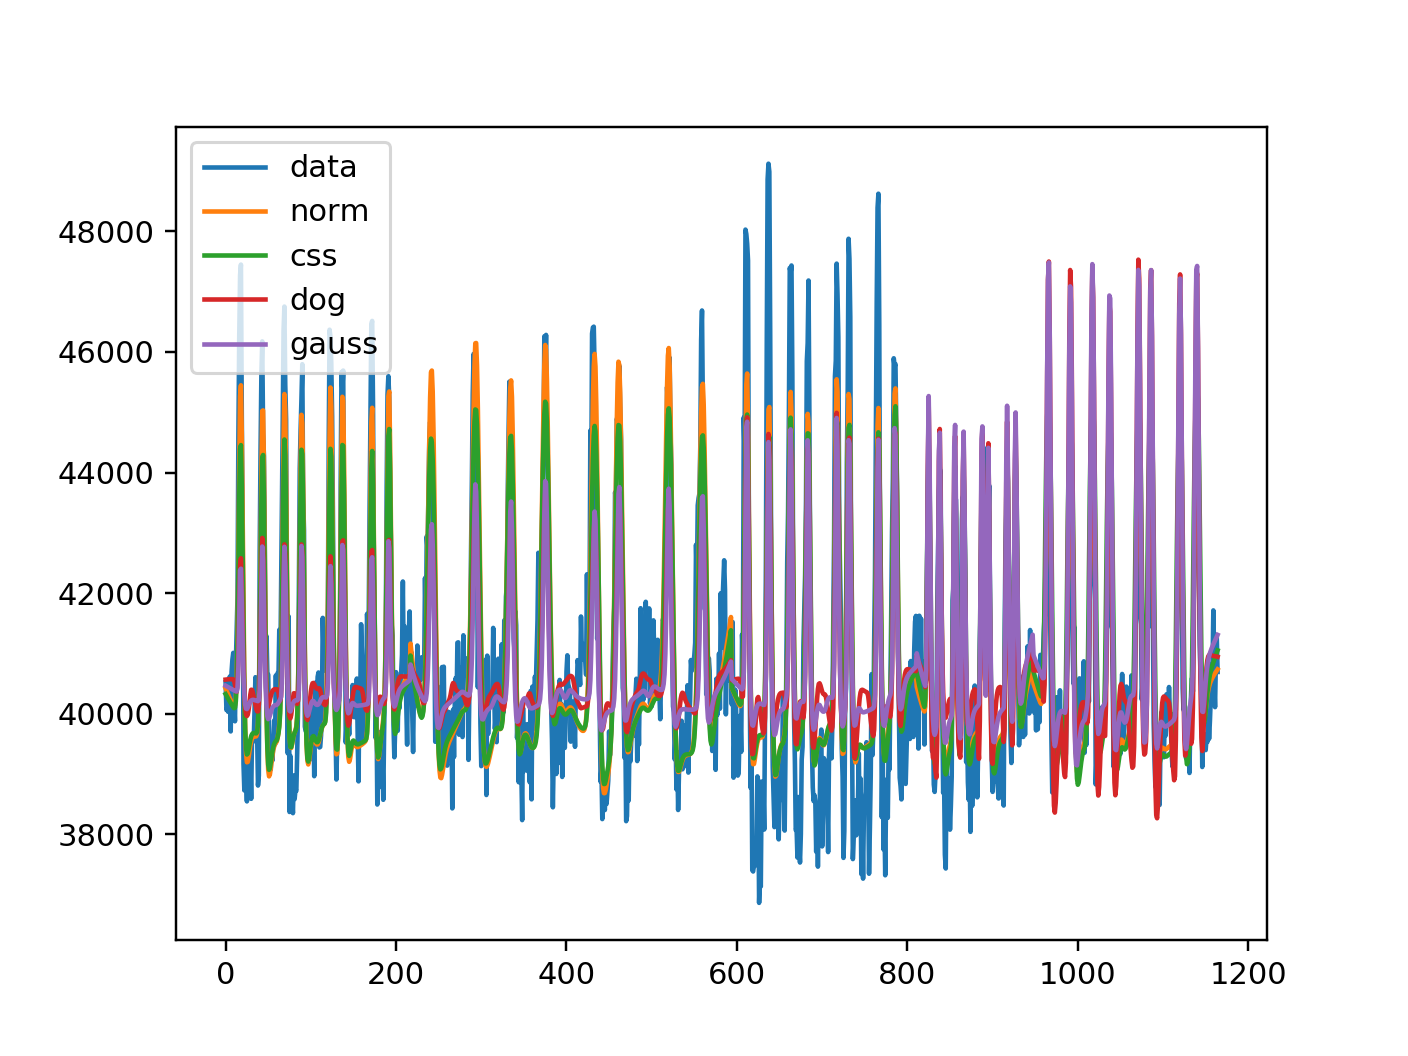

gauss rsq: 0.49033795768776856
css rsq: 0.7067623348679175
dog rsq: 0.5087380007331042
norm rsq: 0.7546809071012142
gauss params
[   -0.66092799    -1.49338474     0.54318488   161.94494612
 40262.28446158     0.49033796]
css params
[   -0.68677946    -1.57223766     0.1         4621.18863564
 39822.01547792     0.01099603     0.70676233]
dog params
[   -0.61540534    -1.48402621     0.78495421   100.92410796
 40496.58641734     2.39236455    42.76542866     0.508738  ]
norm params
[   -0.62504391    -1.48393274     1.01655819 13790.65607113
 39829.10679798     0.65782181     5.053146       0.00018037
     7.33388148     0.75468091]


In [114]:
%matplotlib notebook
rsq_thresh=0.3

roi = 'custom.V1'
alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh

#create timecourses
vox_num=np.argmax((rsq[:,3]-rsq[:,0])*alpha_roi)#50370



vox_num = np.sum(nonzerovar_mask[:vox_num])
tc_vox=timecourse[vox_num]




#norm_grid_tc=gg_norm.return_single_prediction(*list(norm_grid[vox_num,:-1]))
norm_tc=gg_norm.return_single_prediction(*list(norm_res[vox_num,:-1])) #/tc_vox.mean(-1) +99
gauss_tc=gg.return_single_prediction(*list(gauss[vox_num,:-1])) #/tc_vox.mean(-1) +99
css_tc=gg_css.return_single_prediction(*list(css_res[vox_num,:-1])) #/tc_vox.mean(-1) +99
dog_tc=gg_dog.return_single_prediction(*list(dog_res[vox_num,:-1])) #/tc_vox.mean(-1) +99
#norm_updated=gg_norm.return_single_prediction(*list(gf_norm.iterative_search_params[0])) #/tc_vox.mean(-1) +99
#css_updated=gg_css.return_single_prediction(*list(gf_css.iterative_search_params[0]))


#tc_vox/=tc_vox.mean(-1)
#tc_vox+=99

fig=pl.figure()
pl.plot(tc_vox, label='data')
pl.plot(norm_tc, label='norm')
pl.plot(css_tc,label='css')
pl.plot(dog_tc,label='dog')
pl.plot(gauss_tc,label='gauss')
#pl.plot(norm_updated,label='new norm')
#pl.plot(css_updated,label='new css')
pl.legend()

np.set_printoptions(suppress=True)

print("gauss rsq: "+str(1-np.sum((tc_vox-gauss_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("css rsq: "+str(1-np.sum((tc_vox-css_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("dog rsq: "+str(1-np.sum((tc_vox-dog_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("norm rsq: "+str(1-np.sum((tc_vox-norm_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
#print("new norm rsq: "+str(1-np.sum((tc_vox-norm_updated)**2)/(timecourse.shape[-1]*np.var(tc_vox))))

#print("new css rsq: "+str(1-np.sum((tc_vox-css_updated)**2)/(timecourse.shape[-1]*np.var(tc_vox))))


print("gauss params")
print(gauss[vox_num])
print("css params")
print(css_res[vox_num])
print("dog params")
print(dog_res[vox_num])
print("norm params")
print(norm_res[vox_num])
#print("new norm params")
#print(gf_norm.iterative_search_params[0])

#norm_res[vox_num] = gf_norm.iterative_search_params[0]

In [652]:
print(norm_tc[late_iso_dict['1R']].mean())
print(norm_tc[task_lengths[0]+late_iso_dict['1S']].mean())
print(norm_tc[np.sum(task_lengths[:2])+late_iso_dict['2R']].mean())
print(norm_tc[np.sum(task_lengths[:3])+late_iso_dict['4F']].mean())
print(norm_tc[np.sum(task_lengths[:4])+late_iso_dict['4R']].mean())

81296.62650324668
81484.42830762974
81318.6845042052
81333.0287499793
81383.69182436485


In [653]:
print(tc_vox[late_iso_dict['1R']].mean())
print(tc_vox[task_lengths[0]+late_iso_dict['1S']].mean())
print(tc_vox[np.sum(task_lengths[:2])+late_iso_dict['2R']].mean())
print(tc_vox[np.sum(task_lengths[:3])+late_iso_dict['4F']].mean())
print(tc_vox[np.sum(task_lengths[:4])+late_iso_dict['4R']].mean())

80890.47
80890.46
80890.45
80890.45
80890.45


In [134]:
from scipy.optimize import LinearConstraint, NonlinearConstraint

inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

gf_norm = Norm_Iso2DGaussianFitter(data=tc_vox.reshape(-1,tc_vox.shape[-1]),
                                       gridder=gg_norm,
                                       n_jobs=1)
gf_css = CSS_Iso2DGaussianFitter(data=tc_vox.reshape(-1,tc_vox.shape[-1]),
                                       gridder=gg_css,
                                       n_jobs=1)


constraints_dog = []
constraints_norm = []

#enforcing surround size larger than prf size
A_ssc_dog = np.array([[0,0,-1,0,0,0,1]])
A_ssc_norm = np.array([[0,0,-1,0,0,0,1,0,0]])

constraints_dog.append(LinearConstraint(A_ssc_dog,
                                                lb=0,
                                                ub=+inf))

constraints_norm.append(LinearConstraint(A_ssc_norm,
                                                lb=0,
                                                ub=+inf))

if pos_prfs_only:
        #enforcing positive central amplitude
    def positive_centre_prf_dog(x):
        if normalize_RFs:
            return x[3]/(2*np.pi*x[2]**2)-x[5]/(2*np.pi*x[6]**2)
        else:
            return x[3] - x[5]

    def positive_centre_prf_norm(x):
        if normalize_RFs:
            return (x[3]/(2*np.pi*x[2]**2)+x[7])/(x[5]/(2*np.pi*x[6]**2)+x[8]) - x[7]/x[8]
        else:
            return (x[3]+x[7])/(x[5]+x[8]) - x[7]/x[8]

    constraints_dog.append(NonlinearConstraint(positive_centre_prf_dog,
                                                lb=0,
                                                ub=+inf))
    constraints_norm.append(NonlinearConstraint(positive_centre_prf_norm,
                                            lb=0,
                                            ub=+inf))

In [139]:
start = norm_res[vox_num].reshape(-1,10)
#start = np.insert(start, -1, 1.0, axis=-1)
#start = np.insert(start, -1, 0.0, axis=-1)

gf_norm.iterative_fit(rsq_threshold=0, verbose=2,
                              starting_params=start,#gf_norm.iterative_search_params,#norm_grid[vox_num].reshape(-1,norm_grid[vox_num].shape[-1]),
                                      bounds=[(-2*ss, 2*ss),  # x
                                               (-2*ss, 2*ss),  # y
                                               (eps, 2*ss),  # prf size
                                               (0, 1e3),  # prf amplitude
                                               (0, 1e3),  # bold baseline
                                               (0, 1e3),  # surround amplitude
                                               (eps, 4*ss),  # surround size
                                               (0, 1e3),  # neural baseline
                                               (1e-6, 1e3)],#, # surround baseline
                                            # (0,10),
                                           #  (0,10)],  
                                       gradient_method='no',
                                       fit_hrf=False,
                                         constraints=constraints_norm)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Using no-gradient minimization


/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained

/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained

`xtol` termination condition is satisfied.
Number of iterations: 233, function evaluations: 2860, CG iterations: 971, optimality: 1.40e-03, constraint violation: 0.00e+00, execution time: 2.6e+01 s.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s finished


In [110]:
start = css_res[vox_num].reshape(-1,7)
start = np.insert(start, -1, 1.0, axis=-1)
start = np.insert(start, -1, 0.0, axis=-1)

gf_css.iterative_fit(rsq_threshold=0, verbose=True,
                              starting_params=start,
                             bounds=[(-2*ss, 2*ss),  # x
                                     (-2*ss, 2*ss),  # y
                                     (eps, 2*ss),  # prf size
                                     (-inf, +inf),  # prf amplitude
                                     (0, +inf),  # bold baseline
                                     (0.001, 3),
                                             (0,10),
                                             (0,10)],  # CSS exponent
                                       gradient_method='no',
                                       fit_hrf=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Using no-gradient minimization


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


In [140]:
np.set_printoptions(suppress=True)
#gf_norm.iterative_search_params[0,-2]=1
#gf_norm.iterative_search_params[0,-4]=6
#gf_norm.iterative_search_params[0,-5]=3

#gf_norm.iterative_search_params[0,3]=6000
#gf_norm.iterative_search_params[0,4]=80000
print(gf_norm.iterative_search_params[0])
print(norm_res[vox_num])
#print(gf_norm.iterative_search_params[0] - norm_res[vox_num])
print(norm_grid[vox_num])

[-1.90864622 -0.54262835  0.65769096  5.01762929 99.49533335  5.22638441
  3.33437673  0.00002053  4.296614    0.44628457]
[-2.02872056 -0.53325511  0.1         0.74908122 99.60595137  0.77030548
  3.27583029  0.          1.32961421  0.42361966]
[-2.03424079 -0.5114857   0.10000016  0.44797629 99.60430145  1.
  6.          0.          1.          0.42200074]


In [111]:
np.set_printoptions(suppress=True)
print(gf_css.iterative_search_params[0])

[-1.10835049  3.2156498   0.40423965  2.48661178 99.10868936  0.23713028
  3.24459895  0.          0.56925527]


In [37]:
anp = norm_res[:10,:-1]#gf_norm.iterative_search_params[0]
agp = gauss[:10,:-1]
acp = css_res[:10,:-1]#gf_css.iterative_search_params[0]
adp = dog_res[:10,:-1]


x=np.linspace(-20,20,1000)
gauss_profile = agp[...,3] * np.exp(-0.5*x[...,np.newaxis]**2 / agp[...,2]**2)

half_max = np.max(gauss_profile, axis=0)/2

css_profile = (acp[3] * (np.exp(-0.5*x**2 / acp[2]**2))**acp[5])
dog_profile = adp[3] * np.exp(-0.5*x**2 / adp[2]**2) - adp[5] * np.exp(-0.5*x**2 / adp[6]**2)
norm_profile = (anp[3] * np.exp(-0.5*x**2 / anp[2]**2) + anp[7]) / (anp[5] * np.exp(-0.5*x**2 / anp[6]**2) + anp[8])
pl.figure()
pl.plot(x,norm_profile,label='norm')
pl.plot(x,css_profile,label='css')
pl.plot(x,dog_profile,label='dog')
pl.plot(x,gauss_profile,label='gauss')
pl.legend()

ValueError: operands could not be broadcast together with shapes (1000,) (6,) 

In [42]:
print(half_max.shape)
x[np.argmin(np.abs(half_max-gauss_profile), axis=0)]

(10,)


array([-0.42042042, -0.5005005 , -0.54054054, -0.54054054, -0.54054054,
       -0.38038038, -0.54054054, -0.62062062, -0.38038038, -0.66066066])

In [43]:
agp

array([[2.39757873e+00, 2.60430189e-01, 3.50643828e-01, 1.13346322e+02,
        6.86608990e+04],
       [2.54802888e+00, 3.85879235e-01, 4.30552282e-01, 9.51115676e+01,
        6.96927229e+04],
       [2.58749607e+00, 4.17583105e-01, 4.51059228e-01, 9.68074753e+01,
        7.06364901e+04],
       [2.73111188e+00, 4.66150961e-01, 4.50371759e-01, 1.15703847e+02,
        6.45847187e+04],
       [2.61016573e+00, 6.21102360e-01, 4.65716762e-01, 8.71259269e+01,
        5.91878856e+04],
       [2.37924514e+00, 2.76602634e-01, 3.17047987e-01, 1.27025499e+02,
        6.82756637e+04],
       [2.47908634e+00, 3.93369349e-01, 4.68963855e-01, 6.84625191e+01,
        6.70114840e+04],
       [2.41922278e+00, 4.57514285e-01, 5.26847349e-01, 4.73289070e+01,
        6.53476156e+04],
       [2.41741948e+00, 4.29122585e-01, 3.24784667e-01, 1.23262778e+02,
        6.46082178e+04],
       [2.59173473e+00, 6.57237544e-01, 5.50875479e-01, 6.17278592e+01,
        6.71865053e+04]])

(10,)


<IPython.core.display.Javascript object>


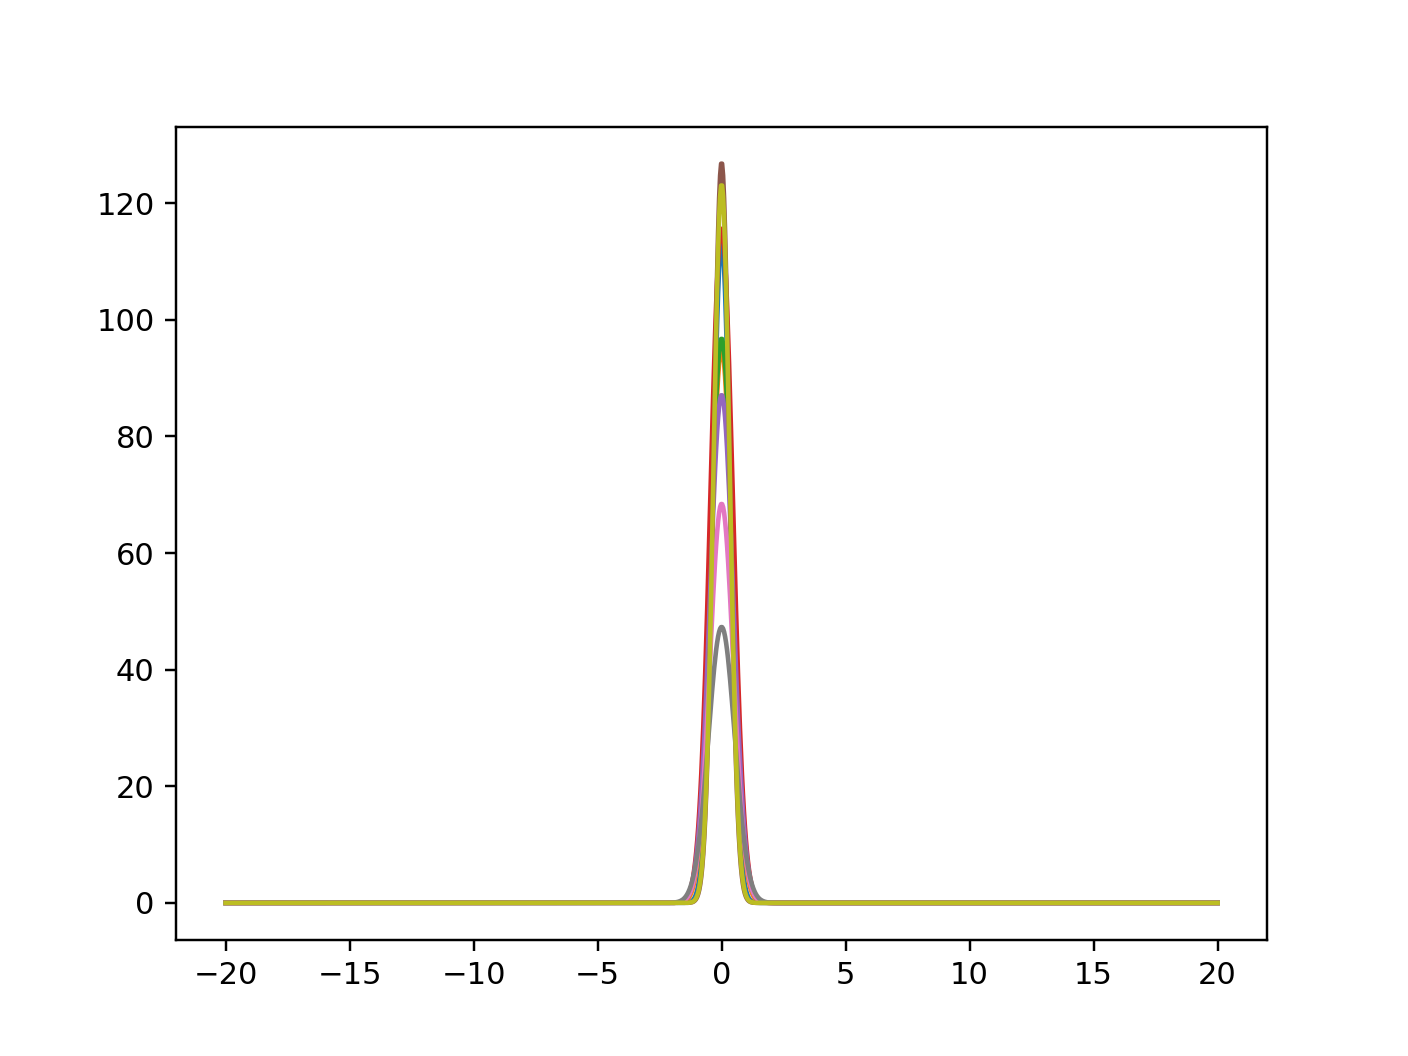

In [38]:
pl.figure()
for i in range(9):
    pl.plot(x,gauss_profile[:,i],label='gauss')

In [ ]:
###outdated cells

In [96]:
#correcting for low intensity TCs (lowest xx percentile per ROI) (unused)
tc_mean_full = np.zeros(nonzerovar_mask.shape)
tc_mean = timecourse.mean(-1)
tc_mean_full[nonzerovar_mask]=tc_mean

for roi in idx_rois:
    k_values = int(len(idx_rois[roi])/20)
    lowest_intensity = np.argpartition(tc_mean_full[idx_rois[roi]][tc_mean_full[idx_rois[roi]]>0], k_values)
    alpha[idx_rois[roi][tc_mean_full[idx_rois[roi]]>0][lowest_intensity[:k_values]]] = 0
    
    tc_mean_full[idx_rois[roi][tc_mean_full[idx_rois[roi]]>0][lowest_intensity[:k_values]]] = 0

#plotting histograms of mean signal intensity per ROI, after removing lowest intensity
for roi in idx_rois:
    pl.figure()
    pl.title(roi)
    pl.hist(tc_mean_full[idx_rois[roi]],bins=100)
    pl.show()
    #pl.close()

In [2]:
#load data fsaverage sub 001

gauss = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-gauss_space-fsaverage.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_gridparams-norm_space-fsaverage.npy") 
norm_an = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_analytic.npy")
#norm_num = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_numerical.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-dog_space-fsaverage.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-css_space-fsaverage.npy")
norm_unbound = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_unbounded.npy")
norm_combined=np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_norm-iterparams-combined_space-fsaverage.npy")
norm_powell=np.load("/Users/marcoaqil/PRFMapping/Cartesius results sub-001/sub-001_iterparams-norm_space-fsaverage_powell.npy")
norm_num_fix = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_num_bounds_fixed.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/sub-001_nonzerovar-mask_space-fsaverage.npy")

norm_res = norm_num_fix

#load data fsnative sub 001
gauss = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-gauss_space-fsnative.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-css_space-fsnative.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsnative.npy")
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_nonzerovar-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_timecourse_space-fsnative.npy')

#load data fsnative sub 006 (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-gauss_space-fsnative.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-css_space-fsnative.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-norm_space-fsnative.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_gridparams-norm_space-fsnative.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_gridparams-gauss_space-fsnative.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_nonlow-var-mask_space-fsnative.npy")

timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_timecourse_space-fsnative.npy')

#load data fsnative20191107120858 sub 006 SMALLER BOUNDS iterated fit (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-gauss_space-fsnative20191107120858.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-css_space-fsnative20191107120858.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-dog_space-fsnative20191107120858.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-norm_space-fsnative20191107120858.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_nonlow-var-mask_space-fsnative.npy")

timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_timecourse_space-fsnative.npy')

#load data fsnative sub 006 iterated with trust-constr minimizer (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-gauss_space-fsnative20191106094038.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-css_space-fsnative20191106094038.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-dog_space-fsnative20191106094038.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-norm_space-fsnative20191106094038.npy")

#nonzerovar_mask_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_nonlow-var-mask_space-fsnative.npy")

#timecourse_it = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_timecourse_space-fsnative.npy')

#load data fsnative sub 006 first surr constraints tc first (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-css_space-fsnative.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-norm_space-fsnative.npy")

#load data fsnative sub 006 first surr constraints tc first iterated (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative20191108021600.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-css_space-fsnative20191108021600.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-dog_space-fsnative20191108021600.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-norm_space-fsnative20191108021600.npy")

#load data fsnative sub 007 (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-gauss_space-fsnative.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-css_space-fsnative.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-norm_space-fsnative.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_gridparams-norm_space-fsnative.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_gridparams-gauss_space-fsnative.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_nonlow-var-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_timecourse_space-fsnative.npy')

In [901]:
#plot suppr idx on cortex (not very meaningful)
#suppression index (for norm also take into account baseline?)
suppr_idx = np.zeros((nonzerovar_mask.shape[0],2))
suppr_idx[nonzerovar_mask,0] = (dog_res[:,5] * dog_res[:,6]**2)/(dog_res[:,3] * dog_res[:,2]**2)
suppr_idx[nonzerovar_mask,1] = (norm_res[:,5] * norm_res[:,6]**2 + norm_res[:,7])/(norm_res[:,3] * norm_res[:,2]**2 + norm_res[:,8])

suppr_idx_dog = cortex.Vertex2D(np.log(suppr_idx[:,0]), alpha, subject=subj,
                                vmin=-25, vmax=10, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
suppr_idx_norm = cortex.Vertex2D(np.log(suppr_idx[:,1]), alpha, subject=subj,
                                 vmin=-12, vmax=2, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_suppr_idx = {'suppr_idx DoG':suppr_idx_dog.raw, 'suppr_idx Norm':suppr_idx_norm.raw}

cortex.webgl.show(ds_suppr_idx,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Started server on port 43369


<JS: window.viewer>

Stopping server
